## Final Project Submission

* Student name: **Wendy Kim**
* Student pace: **Part time**
* Instructor name: **Jeff Herman**
* Blog post URL: https://wendysjkim.github.io/arima_modeling_real_estate_investment_recommendations

In this project, I analyzed zipcode-level median housing sales data from Zillow. I used ARIMA modeling to identify 5 zipcodes with highest predicted rate of returns in the three biggest cities (by number of zipcodes).  

# 1. Setup

### 1a. Import Necessary Libraries and Data

In [1]:
# import necessary libraries
import warnings

import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as stats
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams

%matplotlib inline
plt.style.use('seaborn-colorblind')

In [2]:
#!pip install pyshp
import shapefile as shp 

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

In [3]:
df = pd.read_csv('zillow_data.csv')
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [5]:
df.describe() #data ranges from April 1996 to April 2018 (22 years)

RegionID    RegionName      SizeRank       1996-04       1996-05  \
count   14723.000000  14723.000000  14723.000000  1.368400e+04  1.368400e+04   
mean    81075.010052  48222.348706   7362.000000  1.182991e+05  1.184190e+05   
std     31934.118525  29359.325439   4250.308342  8.600251e+04  8.615567e+04   
min     58196.000000   1001.000000      1.000000  1.130000e+04  1.150000e+04   
25%     67174.500000  22101.500000   3681.500000  6.880000e+04  6.890000e+04   
50%     78007.000000  46106.000000   7362.000000  9.950000e+04  9.950000e+04   
75%     90920.500000  75205.500000  11042.500000  1.432000e+05  1.433000e+05   
max    753844.000000  99901.000000  14723.000000  3.676700e+06  3.704200e+06   

            1996-06       1996-07       1996-08       1996-09       1996-10  \
count  1.368400e+04  1.368400e+04  1.368400e+04  1.368400e+04  1.368400e+04   
mean   1.185374e+05  1.186531e+05  1.187803e+05  1.189275e+05  1.191205e+05   
std    8.630923e+04  8.646795e+04  8.665094e+04  8.687208e+04  8.715185e+04   
min    1.160000e+04  1.180000e+04  1.180000e+04  1.200000e+04  1.210000e+04   
25%    6.910000e+04  6.920000e+04  6.937500e+04  6.950000e+04  6.960000e+04   
50%    9.970000e+04  9.970000e+04  9.980000e+04  9.990000e+04  9.995000e+04   
75%    1.432250e+05  1.432250e+05  1.435000e+05  1.437000e+05  1.439000e+05   
max    3.729600e+06  3.754600e+06  3.781800e+06  3.813500e+06  3.849600e+06   

       ...       2017-07       2017-08       2017-09       2017-10  \
count  ...  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04   
mean   ...  2.733354e+05  2.748658e+05  2.764646e+05  2.780332e+05   
std    ...  3.603984e+05  3.614678e+05  3.627563e+05  3.644610e+05   
min    ...  1.440000e+04  1.450000e+04  1.470000e+04  1.480000e+04   
25%    ...  1.269000e+05  1.275000e+05  1.282000e+05  1.287000e+05   
50%    ...  1.884000e+05  1.896000e+05  1.905000e+05  1.914000e+05   
75%    ...  3.050000e+05  3.066500e+05  3.085000e+05  3.098000e+05   
max    ...  1.888990e+07  1.870350e+07  1.860530e+07  1.856940e+07   

            2017-11       2017-12       2018-01       2018-02       2018-03  \
count  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04   
mean   2.795209e+05  2.810953e+05  2.826571e+05  2.843687e+05  2.865114e+05   
std    3.656003e+05  3.670454e+05  3.695727e+05  3.717739e+05  3.724612e+05   
min    1.450000e+04  1.430000e+04  1.410000e+04  1.390000e+04  1.380000e+04   
25%    1.292500e+05  1.299000e+05  1.306000e+05  1.310500e+05  1.319500e+05   
50%    1.925000e+05  1.934000e+05  1.941000e+05  1.950000e+05  1.967000e+05   
75%    3.117000e+05  3.134000e+05  3.151000e+05  3.168500e+05  3.188500e+05   
max    1.842880e+07  1.830710e+07  1.836590e+07  1.853040e+07  1.833770e+07   

            2018-04  
count  1.472300e+04  
mean   2.880399e+05  
std    3.720544e+05  
min    1.380000e+04  
25%    1.324000e+05  
50%    1.981000e+05  
75%    3.211000e+05  
max    1.789490e+07  

[8 rows x 268 columns]

There are 14,723 zipcodes in total. Let's focus on top 3 cities with the most number of zipcodes. The top 3 cities with the most number of zipcodes are New York, Los Angeles and Houston.

### 1b. Subset to Top 3 Cities

In [6]:
# top 3 cities - NY, LA, Houston
df['City'].value_counts()[:5]

New York       114
Los Angeles     95
Houston         88
San Antonio     48
Washington      45
Name: City, dtype: int64

The data is consistent with the population size of each city.
http://worldpopulationreview.com/us-cities/

Largest Cities in the US by Population (2019)
1. New York City, NY (Population: 8,601,186)
2. Los Angeles, CA (Population: 4,057,841)
3. Chicago, IL (Population: 2,679,044)
4. Houston, TX (Population: 2,359,480)

In [7]:
# filter to top 3 cities
def subset_city(df, city):
    return df.loc[(df['City'] == city)]

ny = subset_city(df, 'New York')
la = subset_city(df, 'Los Angeles')
houston = subset_city(df, 'Houston')

top3 = pd.DataFrame(pd.concat([ny, la, houston], axis=0))
print(len(top3))
top3.head()

297


RegionID  RegionName      City State     Metro CountyName  SizeRank  \
6      61807       10467  New York    NY  New York      Bronx         7   
10     62037       11226  New York    NY  New York      Kings        11   
12     62087       11375  New York    NY  New York     Queens        13   
13     62045       11235  New York    NY  New York      Kings        14   
20     61625       10011  New York    NY  New York   New York        21   

     1996-04   1996-05   1996-06  ...   2017-07   2017-08   2017-09   2017-10  \
6   152900.0  152700.0  152600.0  ...    394400    400000    407300    411600   
10  162000.0  162300.0  162600.0  ...    860200    851000    853900    870000   
12  252400.0  251800.0  251400.0  ...   1022600   1033700   1048600   1066400   
13  190500.0  191000.0  191500.0  ...    767300    777300    788800    793900   
20       NaN       NaN       NaN  ...  12137600  12112600  12036600  12050100   

     2017-11   2017-12   2018-01   2018-02   2018-03   2018-04  
6     413200    414300    413900    411400    413200    417900  
10    885100    887800    890500    901700    930700    963200  
12   1081200   1088800   1092700   1089500   1084000   1084600  
13    796000    799700    806600    810600    813400    816200  
20  12016300  11946500  11978100  11849300  11563000  11478300  

[5 rows x 272 columns]

In [8]:
top3.tail()

RegionID  RegionName     City State    Metro CountyName  SizeRank  \
8230      91681       77032  Houston    TX  Houston     Harris      8231   
8357      91743       77094  Houston    TX  Houston     Harris      8358   
8897      75034       38851  Houston    MS      NaN  Chickasaw      8898   
11934     91699       77050  Houston    TX  Houston     Harris     11935   
14206     66105       19954  Houston    DE    Dover       Kent     14207   

        1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
8230    57100.0   57100.0   57000.0  ...   104800   105600   106500   108200   
8357   356300.0  357700.0  358800.0  ...   375100   374400   374100   374700   
8897        NaN       NaN       NaN  ...    74200    74500    74900    75300   
11934   49200.0   49500.0   49700.0  ...   104200   107000   109500   111200   
14206       NaN       NaN       NaN  ...   157000   156400   155700   154900   

       2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
8230    111200   113600   115600   117400   118800   119200  
8357    375300   375000   373400   372800   373600   373900  
8897     76100    74400    72000    72000    73800    74000  
11934   110800   110900   112900   114900   115400   115200  
14206   153200   152000   152500   153100   153200   153500  

[5 rows x 272 columns]

### 1c. Filter to Top 100 Zipcodes

I will further filter down the samples sizes to 100 zipcodes, by looking at the growth rates in the past 3 years.

In [9]:
top3_growth = top3.copy()
top3_growth['Growth'] = (top3_growth['2018-04']/top3_growth['2015-04'])-1
top3_growth.head()

RegionID  RegionName      City State     Metro CountyName  SizeRank  \
6      61807       10467  New York    NY  New York      Bronx         7   
10     62037       11226  New York    NY  New York      Kings        11   
12     62087       11375  New York    NY  New York     Queens        13   
13     62045       11235  New York    NY  New York      Kings        14   
20     61625       10011  New York    NY  New York   New York        21   

     1996-04   1996-05   1996-06  ...   2017-08   2017-09   2017-10   2017-11  \
6   152900.0  152700.0  152600.0  ...    400000    407300    411600    413200   
10  162000.0  162300.0  162600.0  ...    851000    853900    870000    885100   
12  252400.0  251800.0  251400.0  ...   1033700   1048600   1066400   1081200   
13  190500.0  191000.0  191500.0  ...    777300    788800    793900    796000   
20       NaN       NaN       NaN  ...  12112600  12036600  12050100  12016300   

     2017-12   2018-01   2018-02   2018-03   2018-04    Growth  
6     414300    413900    411400    413200    417900  0.196050  
10    887800    890500    901700    930700    963200  0.399390  
12   1088800   1092700   1089500   1084000   1084600  0.267648  
13    799700    806600    810600    813400    816200  0.304251  
20  11946500  11978100  11849300  11563000  11478300  0.085675  

[5 rows x 273 columns]

In [10]:
top3_growth['Growth'].describe()

count    297.000000
mean       0.274143
std        0.116818
min       -0.104003
25%        0.203097
50%        0.274070
75%        0.336676
max        0.623698
Name: Growth, dtype: float64

In [11]:
top3_growth = top3_growth.sort_values(by='Growth', ascending=False)[:100]
print(top3_growth['Growth'].describe())
top3_growth.head()

count    100.000000
mean       0.395042
std        0.074787
min        0.313553
25%        0.336277
50%        0.376214
75%        0.435559
max        0.623698
Name: Growth, dtype: float64


RegionID  RegionName         City State                           Metro  \
3648     91670       77021      Houston    TX                         Houston   
1224     95997       90016  Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
1191     95999       90018  Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
190      62043       11233     New York    NY                        New York   
5130     91669       77020      Houston    TX                         Houston   

       CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-08  \
3648       Harris      3649   45500.0   45200.0   44900.0  ...   107300   
1224  Los Angeles      1225  135700.0  135300.0  134900.0  ...   654900   
1191  Los Angeles      1192  133200.0  132900.0  132400.0  ...   618800   
190         Kings       191  124500.0  124500.0  124500.0  ...   788000   
5130       Harris      5131   39300.0   39300.0   39300.0  ...    88500   

      2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  \
3648   110500   114100   116300   117400   118600   120800   123200   124700   
1224   663500   672000   679900   692200   706500   715900   722000   727400   
1191   625800   632300   636700   640300   643100   646400   652700   658000   
190    787100   797100   808400   809800   800800   806100   829200   852300   
5130    90900    95100    96300    96500    97800    99200   101200   103800   

        Growth  
3648  0.623698  
1224  0.603969  
1191  0.579453  
190   0.571929  
5130  0.570348  

[5 rows x 273 columns]

In [12]:
top3_growth['City'].value_counts()

Los Angeles    38
New York       36
Houston        26
Name: City, dtype: int64

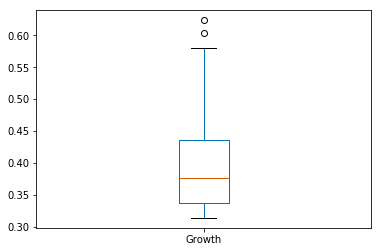

In [13]:
top3_growth['Growth'].plot(kind='box')

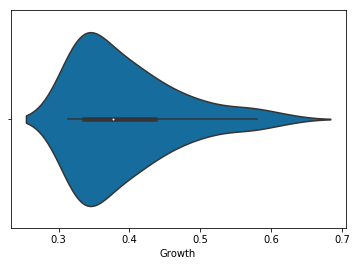

In [14]:
sns.violinplot(top3_growth['Growth'])

In [15]:
#top3_growth.to_csv('top3_growth.csv')

Each of the three cities are fairly evenly represented in the final dataset for ARIMA modeling.

# 2. Data Preprocessing

In [16]:
def get_datetimes(df):
    '''
    Converts string column names into datetime values.
    '''
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [17]:
def melt_data(df):
    '''
    Convergs the time-series data from wide format to long format.
    '''
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 
                                  'State', 'Metro', 'CountyName','SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [18]:
test = top3.loc[top3['RegionID'] == 61807]
test_melted = melt_data(test)
test_melted.head()

value
time                
1996-04-01  152900.0
1996-05-01  152700.0
1996-06-01  152600.0
1996-07-01  152400.0
1996-08-01  152300.0

In [19]:
test_melted.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=265, freq=None)

# 3. EDA and Visualization

### 3a. Number of Zipcodes By City

Text(0.5, 1.0, 'Number of Zipcodes by City')

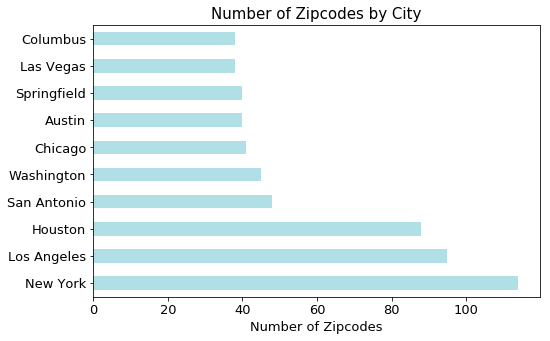

In [20]:
plt.figure(figsize=(8,5))
df['City'].value_counts()[:10].plot(kind='barh', color='powderblue')
plt.xlabel('Number of Zipcodes', size=13)
plt.xticks(size=13)
plt.yticks(size=13)
plt.title('Number of Zipcodes by City', size=15)

In [21]:
cities3 = pd.DataFrame(df.City.value_counts()[:3])
cities3.reset_index(inplace=True)
cities3_pop = pd.Series([8601186, 4057841, 2359480])
cities3 = pd.concat([cities3, cities3_pop], axis=1)
cities3.columns = ['City', 'Num_Zipcodes', 'Population']
cities3.head()

City  Num_Zipcodes  Population
0     New York           114     8601186
1  Los Angeles            95     4057841
2      Houston            88     2359480

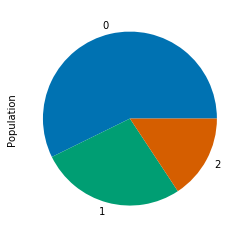

In [22]:
cities3['Population'].plot(kind='pie')

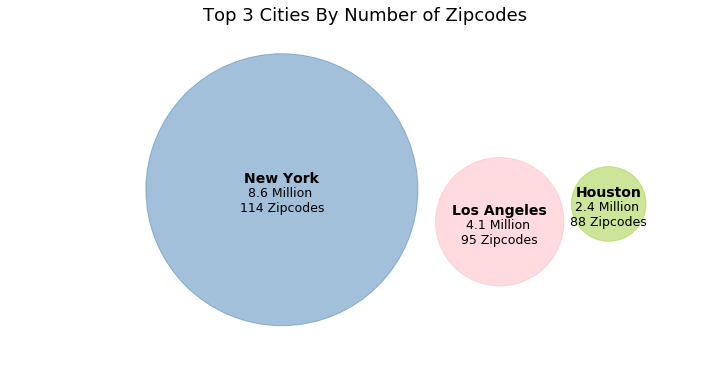

In [24]:
csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

plt.figure(figsize=(12,6))
x = [0.6, 0.8,0.9]
y = [1.04, 0.95, 1]
z = cities3.Population
plt.scatter(x, y, s=10*(z/100000)**2, alpha=0.5, c=['steelblue','lightpink', 'yellowgreen'])
labels = []
for i in range(3):
    labels.append('{} Million \n{} Zipcodes'.format(np.round(cities3.Population[i]/1000000,1), 
                                                                    cities3.Num_Zipcodes[i]))

    plt.annotate(cities3.City[i], (x[i], y[i]+0.02), ha='center', **{'fontsize':14, 
                                                                     'fontweight':'bold',
                                                                    'fontfamily':'Calibri'})
    plt.annotate(labels[i], (x[i], y[i]-0.06), ha='center', **{'fontsize':12.5,
                                                               'fontfamily':'Calibri'})

plt.axis('off')
plt.title('Top 3 Cities By Number of Zipcodes', size=18)
plt.show()

### 3b. Median Housing Sales in Top 3 US Cities

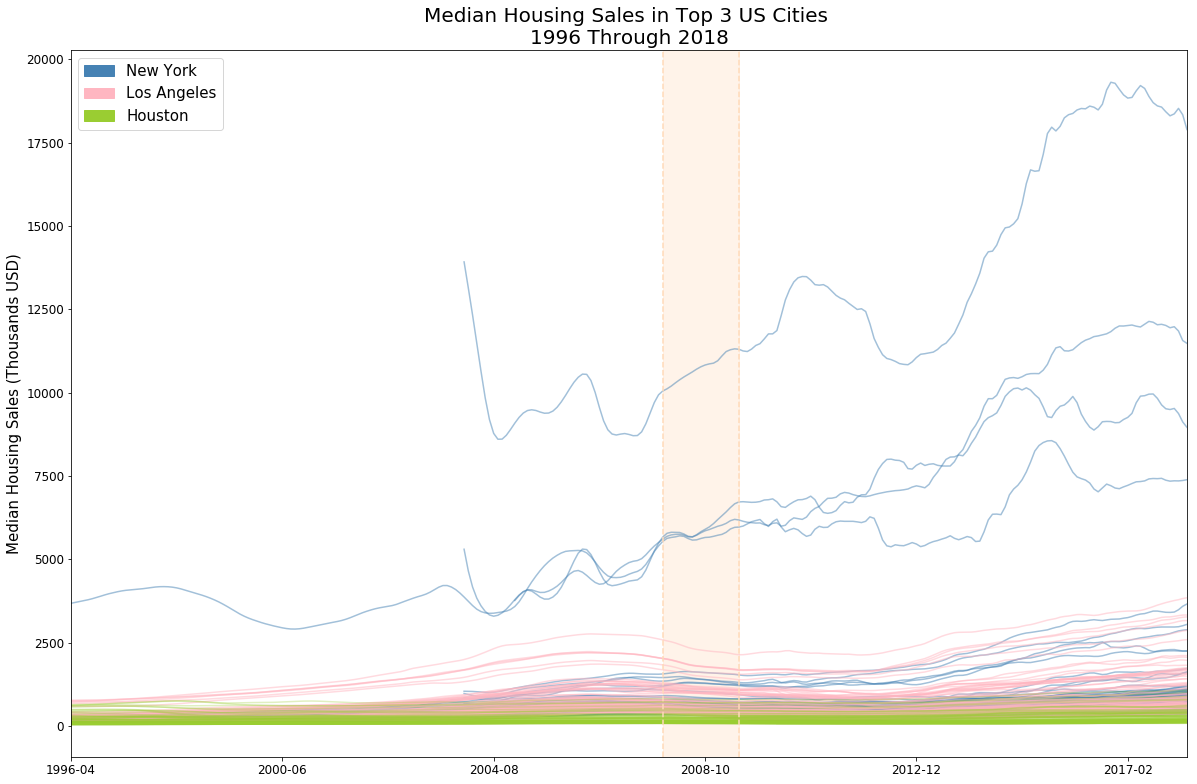

In [25]:
dates = list(df.columns.values[7:])
plt.figure(figsize=(20,13))

# plot price history by city
for i in range(len(ny)):
    (ny.iloc[i,7:]/1000).plot(c='steelblue', alpha=0.5)
for i in range(len(la)):   
    (la.iloc[i,7:]/1000).plot(c='lightpink', alpha=0.5)
for i in range(len(houston)):   
    (houston.iloc[i,7:]/1000).plot(c='yellowgreen', alpha=0.3)

#legend
legend_dict = {'New York' : 'steelblue', 
               'Los Angeles' : 'lightpink', 
               'Houston' : 'yellowgreen'}
patchList = []
for key in legend_dict:
        data_key = mpatches.Patch(color=legend_dict[key], label=key)
        patchList.append(data_key)
        
        
# Great Recession
plt.axvline(x=dates.index('2007-12'), c='peachpuff', linestyle='--')
plt.axvline(x=dates.index('2009-06'), c='peachpuff', linestyle='--')
plt.axvspan(dates.index('2007-12'), dates.index('2009-06'), color='peachpuff', alpha=0.3)

plt.title('Median Housing Sales in Top 3 US Cities \n1996 Through 2018', size=20)
plt.ylabel('Median Housing Sales (Thousands USD)', size=15)
plt.legend(handles=patchList, prop={'size': 15})
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

The highlighted period is the financial crisis between December 2007 and June 2009. There are 5 outliers in New York whose median housing sales are significantly higher than others.

In [26]:
ny.sort_values(by='2018-04', ascending=False)[:4][['RegionName', 'City', 'State']]

RegionName      City State
272       10021  New York    NY
20        10011  New York    NY
508       10014  New York    NY
21        10128  New York    NY

- 10021, 10128 : UES
- 10011 : Chelsea and Clinton
- 10014 : Greenwich Village and Soho

https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm

The outliers are among the most wealthiest neighborhoods in NYC. It is interesting how the median housing price in these areas increase even during the financial crisis.

In [27]:
# Exclude 5 Outliers
ny_excl5 = ny.sort_values(by='2018-04', ascending=False)[4:]

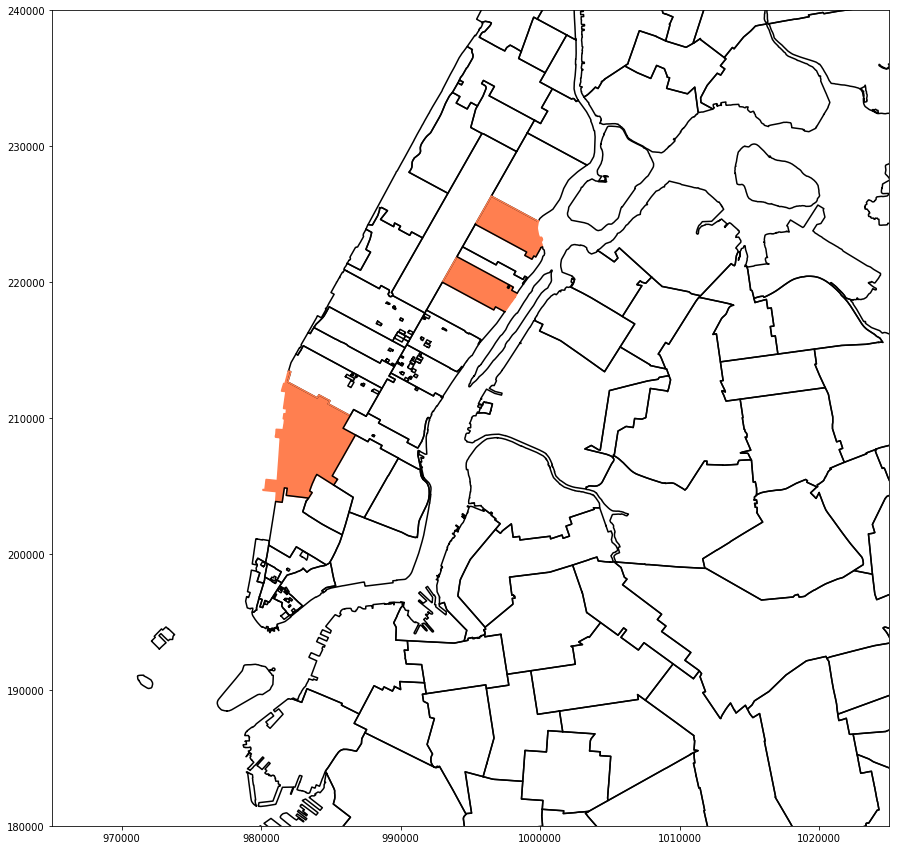

In [30]:
# Visualize the 5 NY Outliers
sf = shp.Reader("ZIP_CODE_040114.dbf")
fields = [field[0] for field in sf.fields[1:]]
outliers = list(ny.sort_values(by='2018-04', ascending=False)[:4]['RegionName'].astype(str))

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

for feature in sf.shapeRecords():
    geom = feature.shape.__geo_interface__
    atr = dict(zip(fields, feature.record))
    
    for i in range(len(feature.shape.parts)):
        i_start = feature.shape.parts[i]
        if i==len(feature.shape.parts)-1:
            i_end = len(feature.shape.points)
        else:
            i_end = feature.shape.parts[i+1]
            
        x = [i[0] for i in feature.shape.points[i_start:i_end]]
        y = [i[1] for i in feature.shape.points[i_start:i_end]]
        
        patches = []
        if atr['ZIPCODE'] in outliers:
            ax.plot(x,y, color='coral')
            patches.append(Polygon(np.array(feature.shape.points[i_start:i_end]), True))
            ax.add_collection(PatchCollection(patches, facecolor= 'coral'))
        else:
            ax.plot(x,y, color='black')
plt.xlim(965000 , 1025000)
plt.ylim(180000 , 240000)
plt.show()

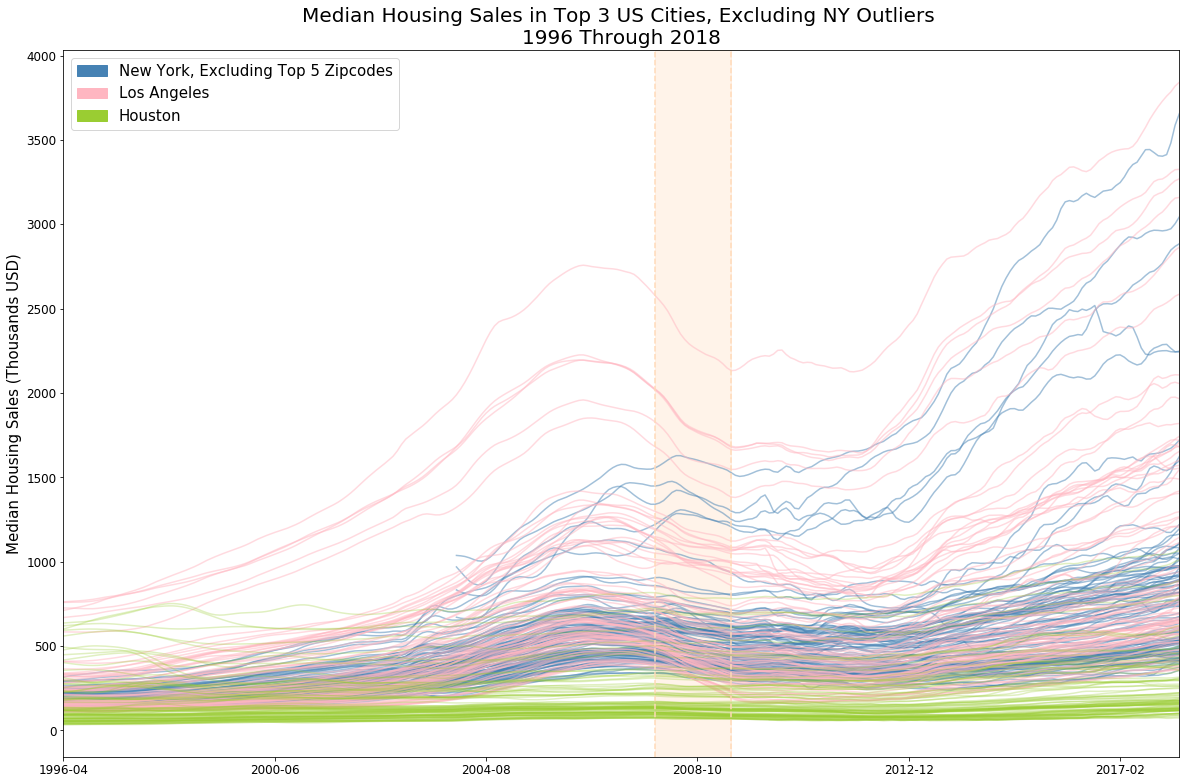

In [31]:
# Excluding 5 Outliers
dates = list(df.columns.values[7:])
plt.figure(figsize=(20,13))

# plot price history by city
for i in range(len(ny_excl5)):
    (ny_excl5.iloc[i,7:]/1000).plot(c='steelblue', alpha=0.5)
for i in range(len(la)):   
    (la.iloc[i,7:]/1000).plot(c='lightpink', alpha=0.5)
for i in range(len(houston)):   
    (houston.iloc[i,7:]/1000).plot(c='yellowgreen', alpha=0.3)

#legend
legend_dict = {'New York, Excluding Top 5 Zipcodes' : 'steelblue', 
               'Los Angeles' : 'lightpink', 
               'Houston' : 'yellowgreen'}
patchList = []
for key in legend_dict:
        data_key = mpatches.Patch(color=legend_dict[key], label=key)
        patchList.append(data_key)
        
        
# Great Recession
plt.axvline(x=dates.index('2007-12'), c='peachpuff', linestyle='--')
plt.axvline(x=dates.index('2009-06'), c='peachpuff', linestyle='--')
plt.axvspan(dates.index('2007-12'), dates.index('2009-06'), color='peachpuff', alpha=0.3)

plt.title('Median Housing Sales in Top 3 US Cities, Excluding NY Outliers \n1996 Through 2018', 
          size=20)
plt.ylabel('Median Housing Sales (Thousands USD)', size=15)
plt.legend(handles=patchList, prop={'size':15})
plt.xticks(size=12)
plt.yticks(size=12)


plt.show()

When we exclude the 5 outliers in New York, the general trend in housing sales seem much more reasonable. The housing prices in LA have the widest range. The housing prices in Houston is the most stable out of the three cities.

### 3c. Median Housing Sales in NYC

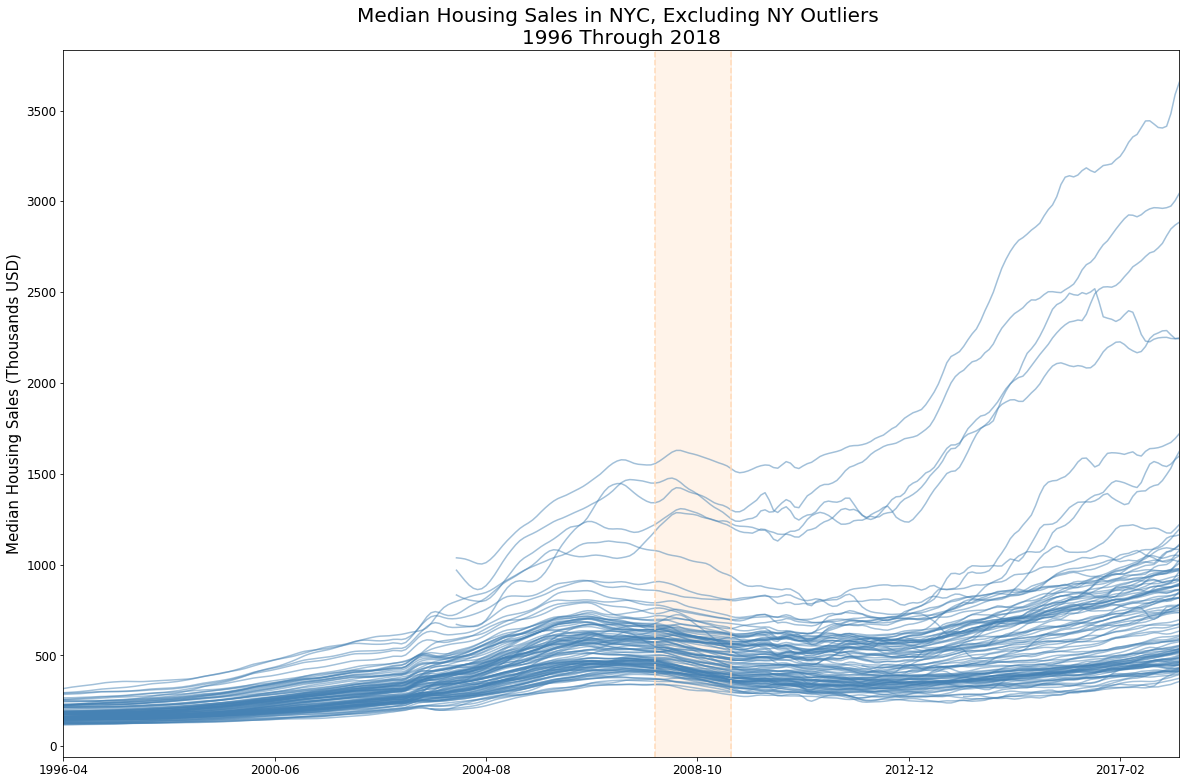

In [32]:
# Excluding 5 Outliers
dates = list(df.columns.values[7:])
plt.figure(figsize=(20,13))

# plot price history by city
for i in range(len(ny_excl5)):
    (ny_excl5.iloc[i,7:]/1000).plot(c='steelblue', alpha=0.5)
        
# Great Recession
plt.axvline(x=dates.index('2007-12'), c='peachpuff', linestyle='--')
plt.axvline(x=dates.index('2009-06'), c='peachpuff', linestyle='--')
plt.axvspan(dates.index('2007-12'), dates.index('2009-06'), color='peachpuff', alpha=0.3)

plt.title('Median Housing Sales in NYC, Excluding NY Outliers \n1996 Through 2018', size=20)
plt.ylabel('Median Housing Sales (Thousands USD)', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

In [33]:
dates.index('2008-04')

144

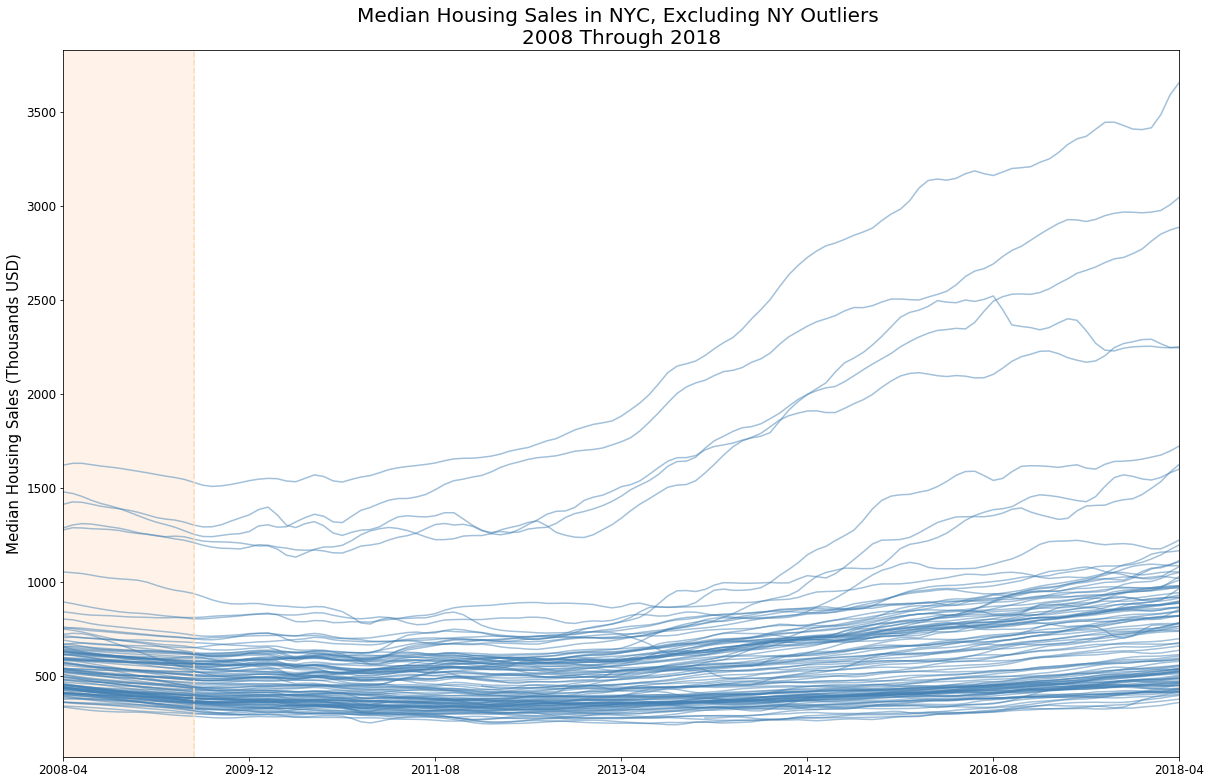

In [34]:
# Excluding 5 Outliers
dates = list(df.columns.values[7:])
plt.figure(figsize=(20,13))

# plot price history by city
for i in range(len(ny_excl5)):
    (ny_excl5.iloc[i,151:]/1000).plot(c='steelblue', alpha=0.5)
        
# Great Recession
plt.axvline(x=dates.index('2009-06')-144, c='peachpuff', linestyle='--')
plt.axvspan(dates.index('2008-04')-144, dates.index('2009-06')-144, color='peachpuff', alpha=0.3)

plt.title('Median Housing Sales in NYC, Excluding NY Outliers \n2008 Through 2018', size=20)
plt.ylabel('Median Housing Sales (Thousands USD)', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

### 3d. Median Housing Sales in LA

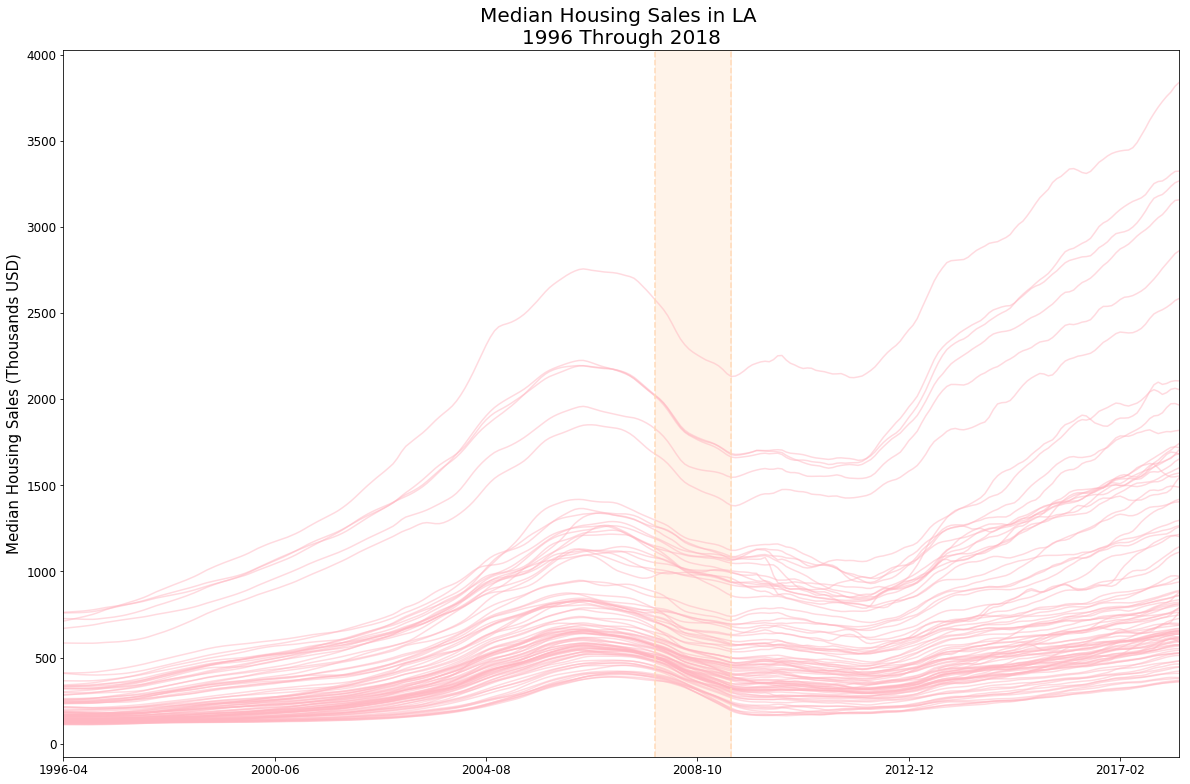

In [35]:
dates = list(df.columns.values[7:])
plt.figure(figsize=(20,13))

# plot price history by city
for i in range(len(la)):   
    (la.iloc[i,7:]/1000).plot(c='lightpink', alpha=0.5)
        
# Great Recession
plt.axvline(x=dates.index('2007-12'), c='peachpuff', linestyle='--')
plt.axvline(x=dates.index('2009-06'), c='peachpuff', linestyle='--')
plt.axvspan(dates.index('2007-12'), dates.index('2009-06'), color='peachpuff', alpha=0.3)

plt.title('Median Housing Sales in LA \n1996 Through 2018', size=20)
plt.ylabel('Median Housing Sales (Thousands USD)', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

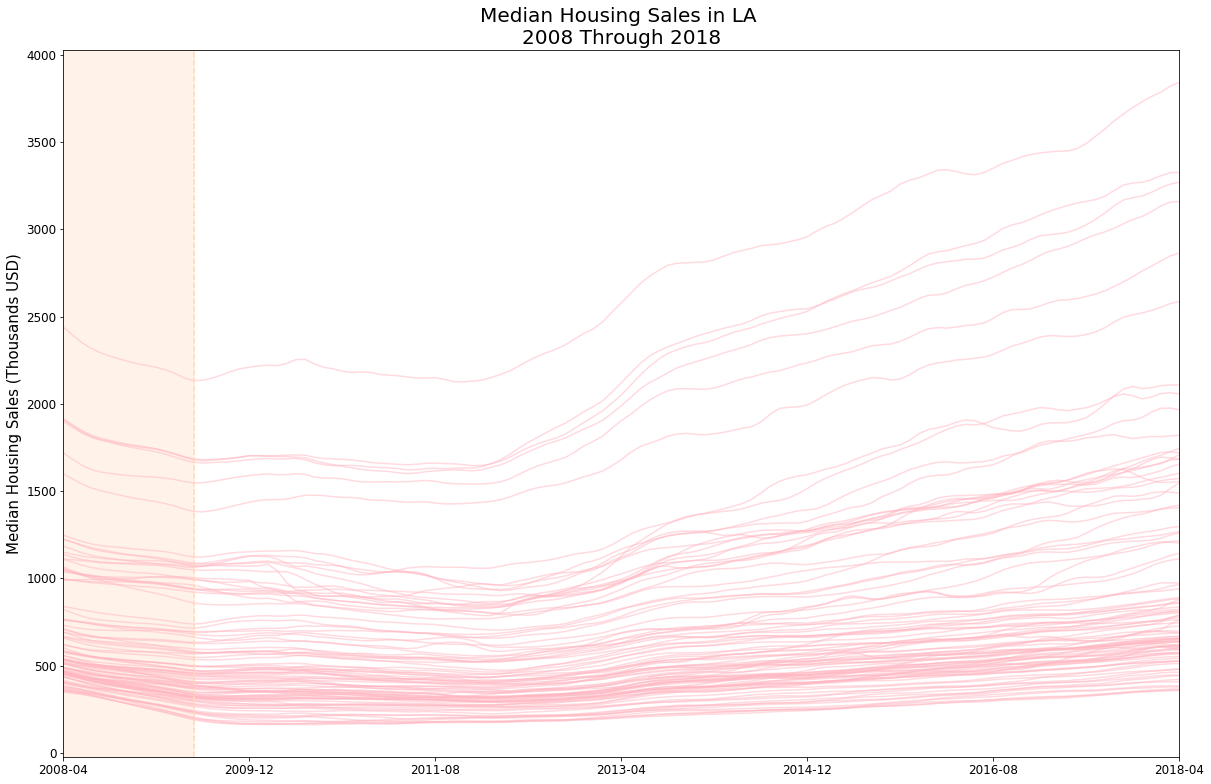

In [36]:
dates = list(df.columns.values[7:])
plt.figure(figsize=(20,13))

# plot price history by city
for i in range(len(la)):   
    (la.iloc[i,151:]/1000).plot(c='lightpink', alpha=0.5)
        
# Great Recession
plt.axvline(x=dates.index('2009-06')-144, c='peachpuff', linestyle='--')
plt.axvspan(dates.index('2007-12')-144, dates.index('2009-06')-144, color='peachpuff', alpha=0.3)

plt.title('Median Housing Sales in LA \n2008 Through 2018', size=20)
plt.ylabel('Median Housing Sales (Thousands USD)', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

### 3e. Median Housing Sales in Houston

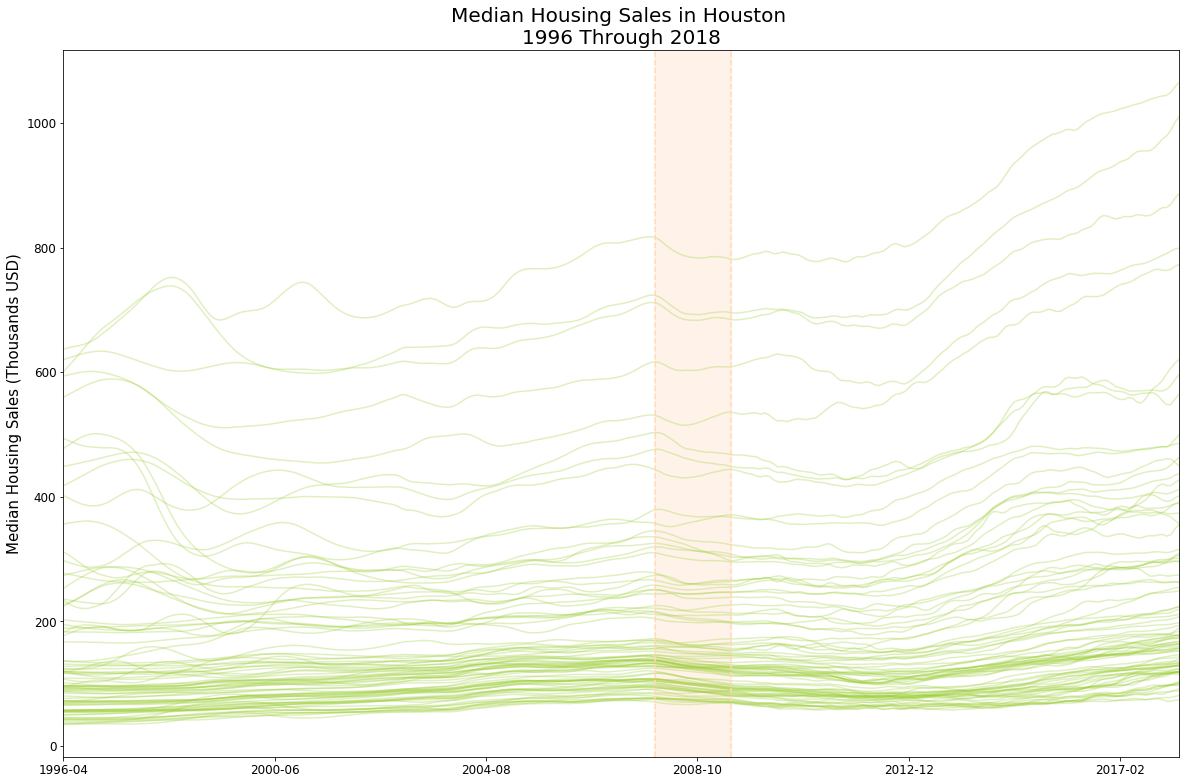

In [37]:
dates = list(df.columns.values[7:])
plt.figure(figsize=(20,13))

# plot price history by city
for i in range(len(houston)):   
    (houston.iloc[i,7:]/1000).plot(c='yellowgreen', alpha=0.3)
        
# Great Recession
plt.axvline(x=dates.index('2007-12'), c='peachpuff', linestyle='--')
plt.axvline(x=dates.index('2009-06'), c='peachpuff', linestyle='--')
plt.axvspan(dates.index('2007-12'), dates.index('2009-06'), color='peachpuff', alpha=0.3)

plt.title('Median Housing Sales in Houston \n1996 Through 2018', size=20)
plt.ylabel('Median Housing Sales (Thousands USD)', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

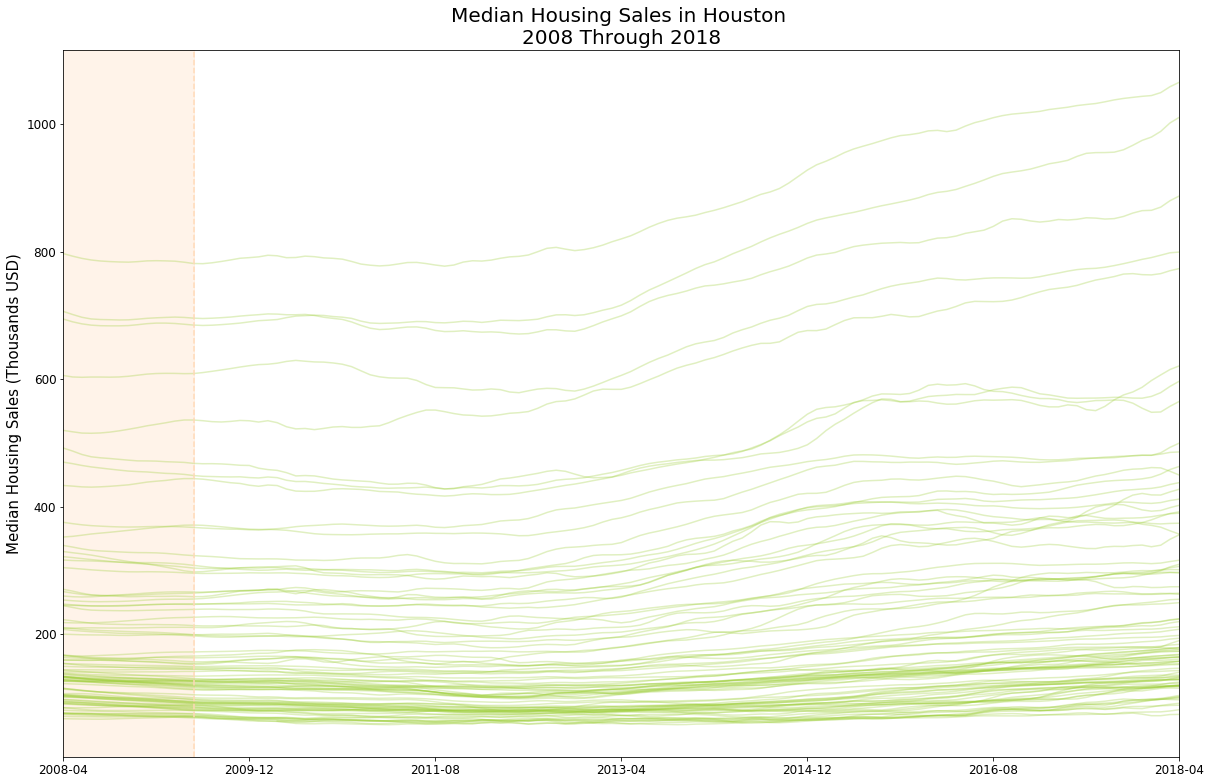

In [38]:
dates = list(df.columns.values[7:])
plt.figure(figsize=(20,13))

# plot price history by city
for i in range(len(houston)):   
    (houston.iloc[i,151:]/1000).plot(c='yellowgreen', alpha=0.3)
        
# Great Recession
# plt.axvline(x=dates.index('2007-12'), c='peachpuff', linestyle='--')
plt.axvline(x=dates.index('2009-06')-144, c='peachpuff', linestyle='--')
plt.axvspan(dates.index('2007-12')-144, dates.index('2009-06')-144, color='peachpuff', alpha=0.3)

plt.title('Median Housing Sales in Houston \n2008 Through 2018', size=20)
plt.ylabel('Median Housing Sales (Thousands USD)', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

# 4. ARIMA Modeling

### 4a. Setup Functions

Below are some functions I would use to identify the optimal parameters for ARIMA modeling, and to obtain predictions from a chosen ARIMA model.

In [39]:
#evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima(X, arima_order, plots=False):
    '''
    For given dataframe and specified order (p, d, q),
    returns mean squared error, AIC, and ARIMA model output.
    Uses SARIMAX with no seasonal order and constant specified.
    When plots=True, shows SARIMAReslts.plot_diagnostics.
    '''
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = train
    
    # make predictions
    # SARIMAX function would return same result as ARIMA function, when specified trend='c'
    predictions = []
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history,
                                      order=arima_order,
                                      freq = 'MS',
                                      enforce_stationarity = False,
                                      enforce_invertibility= False)
        output = model.fit(disp=0)
        yhat = output.forecast()[0]
        predictions.append(yhat)
        history = history.append(test.iloc[t])
        
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    aic = output.aic
  
    # show plots
    if plots == True:
        print(output.summary())
        
        output.plot_diagnostics(figsize=(10,8)).show()

        plt.figure(figsize=(8,5))
        plt.plot(test, label='Actual')
        plt.plot(test.index, predictions, color='red', label='Prediction')
        plt.legend()
        plt.show()

    return error, aic, output

In [40]:
# evaluate combinations of p, d and q values for an ARIMA model
# select parameters based on smallest MSE
def evaluate_models(data, p_values, d_values, q_values):
    '''
    For given data, lists of p, d, and q values,
    evaluates combinations of p, d, and q values for an ARIMA model.
    Optimal parameters are chosen based on smallest MSE.
    Returns chosen parameters, MSE, AIC, and output of the fitted model.
    '''
    data = data.astype('float32')
    best_score, best_cfg, best_aic = float('inf'), None, None
    best_output = None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima(data, order)[0]
                    aic = evaluate_arima(data, order)[1]
                    output = evaluate_arima(data, order)[2]
                    if mse < best_score:
                        best_score, best_cfg, best_aic = mse, order, aic
                        best_output = output
                    print('ARIMA{} MSE={} AIC={}'.format(order, mse, aic))
                except:
                    continue
    print('Best ARIMA{} MSE={} AIC={}'.format(best_cfg, best_score, best_aic))
    return best_cfg, best_score, best_aic, best_output

In [41]:
# subset data
def subset_data(zipcode, date_since=None):
    test = top3.loc[top3['RegionID'] == zipcode]
    test_melted = melt_data(test)
    
    if date_since == None:
        data = test_melted
    else:
        data = test_melted.loc[date_since:]
        
    return data

In [42]:
def to_tuple(string):
    return tuple(int(x) for x in string[1:-1].split(','))

In [43]:
def get_predictions(data):
    '''
    For given dataframe, loops through each zipcode and optimal ARIMA parameters
    and calculates projected values (and ROIs) in 1, 3 and 5 years.
    Returns results as dataframe.
    '''
    futures = []
    for i in range(len(data)):
        zipcode = data['RegionID'].iloc[i]
        X = subset_data(zipcode, date_since='2009-07-01')
        arima_order = to_tuple(data['Parameters'].iloc[i])

        model = sm.tsa.statespace.SARIMAX(X,
                                      order=arima_order,
                                      freq = 'MS',
                                      enforce_stationarity = False,
                                      enforce_invertibility= False)
        output = model.fit(disp=0)
        future = output.get_forecast(steps=60).predicted_mean
        futures.append([zipcode, 
                       arima_order,
                       X.value.iloc[-1],
                       future.loc['2019-04-01'], 
                       future.loc['2021-04-01'],
                       future.loc['2023-04-01']])


    futures = pd.DataFrame(futures)    
    futures.columns = ['RegionID', 'Parameters', '2018-04-01', '2019-04-01','2021-04-01', '2023-04-01']
    
    futures['ROI_1'] = futures['2019-04-01']/futures['2018-04-01'] - 1
    futures['ROI_3'] = futures['2021-04-01']/futures['2018-04-01'] - 1
    futures['ROI_5'] = futures['2023-04-01']/futures['2018-04-01'] - 1
    
    return futures

### 4b. Run ARIMA Grid Search for Optimal Parameters

I ran ARIMA grid search for each zipcode, to identify optimal ARIMA parameters. I selected ARIMA paramters as those with the smallest mean squared errors.

In [44]:
warnings.filterwarnings('ignore')

In [16]:
#############################################################################
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0,3)
q_values = range(0,3)

# p_values = d_values = q_values = range(0,2)
#############################################################################

results = []
i = 1
for zipcode in top3_growth['RegionID']:
    print()
    print('{}. RegionID {} Running.....'.format(i, zipcode))
    cfg, mse, aic, output = evaluate_models(subset_data(zipcode, date_since='2009-07-01'), 
                             p_values, 
                             d_values, 
                             q_values)
    results.append((zipcode, cfg, mse, aic, output))
    i += 1
    
    if i % 5 == 1:
        pd.DataFrame(results).to_csv('ARIMA_results_range0_2.csv')
        
results = pd.DataFrame(results)
results.columns = ['RegionID', 'Parameters', 'MSE', 'AIC', 'Output']
results.to_csv('ARIMA_results_range0_2.csv')
results.head()


1. RegionID 91670 Running.....
ARIMA(0, 0, 0) MSE=9459028648.64865 AIC=2650.1022728469025
ARIMA(0, 0, 1) MSE=3260246513.240048 AIC=2552.6281751169186
ARIMA(0, 0, 2) MSE=1401764153.8759553 AIC=2512.1413913695087
ARIMA(0, 1, 0) MSE=2640270.2702702703 AIC=1755.4798065063396
ARIMA(0, 1, 1) MSE=833984.5278210787 AIC=1634.9798309347623
ARIMA(0, 1, 2) MSE=439389.8885350766 AIC=1578.5036888031752
ARIMA(0, 2, 0) MSE=519189.18918918876 AIC=1622.6498169604806
ARIMA(0, 2, 1) MSE=379134.43007574504 AIC=1593.8406313546982
ARIMA(0, 2, 2) MSE=388692.16604991554 AIC=1570.3701408887484
ARIMA(1, 0, 0) MSE=2200641.471675913 AIC=1760.087600553033
ARIMA(1, 0, 1) MSE=681727.287511948 AIC=1641.8650692846095
ARIMA(1, 0, 2) MSE=382313.1737432942 AIC=1606.4032782298439
ARIMA(1, 1, 0) MSE=542724.2470556657 AIC=1632.55960803714
ARIMA(1, 1, 1) MSE=431021.6133521068 AIC=1602.5878341318896
ARIMA(1, 1, 2) MSE=388004.0108563953 AIC=1574.6706300847238
ARIMA(1, 2, 0) MSE=477324.78068528377 AIC=1620.1953445133934
ARIMA(1

ARIMA(0, 2, 1) MSE=2079650.0905080163 AIC=1744.977729572601
ARIMA(0, 2, 2) MSE=1712174.0477028321 AIC=1688.7187255173822
ARIMA(1, 0, 0) MSE=11744369.904107546 AIC=1989.6097965361969
ARIMA(1, 0, 1) MSE=3595852.137829875 AIC=1869.5712511229185
ARIMA(1, 0, 2) MSE=1926540.0348109596 AIC=1802.7341496321233
ARIMA(1, 1, 0) MSE=2575310.5588168367 AIC=1792.7045598620853
ARIMA(1, 1, 1) MSE=2253126.7377488837 AIC=1764.6763368152422
ARIMA(1, 1, 2) MSE=1613678.1402261055 AIC=1700.9473240623497
ARIMA(1, 2, 0) MSE=2213570.0235317205 AIC=1755.076900298033
ARIMA(1, 2, 1) MSE=1771200.7457859735 AIC=1716.3429767106431
ARIMA(1, 2, 2) MSE=1567853.728378174 AIC=1686.7622138835786
ARIMA(2, 0, 0) MSE=2467487.9795394563 AIC=1789.9478612700898
ARIMA(2, 0, 1) MSE=2470346.677123688 AIC=1796.4901919613844
ARIMA(2, 0, 2) MSE=1864421.7336642887 AIC=1752.463374627902
ARIMA(2, 1, 0) MSE=2253274.7074693837 AIC=1753.0943625207299
ARIMA(2, 1, 1) MSE=1741918.7089431083 AIC=1729.0672812717767
ARIMA(2, 1, 2) MSE=1506927.755

ARIMA(1, 1, 2) MSE=670330.217428036 AIC=1624.1492623036997
ARIMA(1, 2, 0) MSE=1107994.936206275 AIC=1691.6134423753485
ARIMA(1, 2, 1) MSE=822925.3033940721 AIC=1658.89150086782
ARIMA(1, 2, 2) MSE=739785.7284104212 AIC=1623.8848457962513
ARIMA(2, 0, 0) MSE=1090801.672953538 AIC=1689.5355550909767
ARIMA(2, 0, 1) MSE=803136.0823844742 AIC=1663.0628300510468
ARIMA(2, 0, 2) MSE=654020.7244042912 AIC=1638.3415636061304
ARIMA(2, 1, 0) MSE=997222.5073353441 AIC=1657.97927503081
ARIMA(2, 1, 1) MSE=819151.796128519 AIC=1647.3497395324875
ARIMA(2, 1, 2) MSE=696006.9961852498 AIC=1624.087738310444
ARIMA(2, 2, 0) MSE=781389.9381298871 AIC=1640.0852875693174
ARIMA(2, 2, 1) MSE=782223.8423154253 AIC=1642.0978789312635
ARIMA(2, 2, 2) MSE=803871.0472971003 AIC=1625.6631961377188
ARIMA(4, 0, 0) MSE=749177.1749779504 AIC=1627.2775167644595
ARIMA(4, 0, 1) MSE=766149.5982602234 AIC=1636.5039758390585
ARIMA(4, 0, 2) MSE=795508.3771912393 AIC=1644.68227186358
ARIMA(4, 1, 0) MSE=845908.025467911 AIC=1615.2187

ARIMA(2, 1, 1) MSE=23293096.929855406 AIC=1927.6014720684102
ARIMA(2, 1, 2) MSE=19807877.18322011 AIC=1908.554785199732
ARIMA(2, 2, 0) MSE=14562321.697652048 AIC=1892.4585874304137
ARIMA(2, 2, 1) MSE=15447479.300135272 AIC=1894.4633678207294
ARIMA(2, 2, 2) MSE=14500593.805457044 AIC=1874.1005276386356
ARIMA(4, 0, 0) MSE=14574441.872297145 AIC=1892.8271337343701
ARIMA(4, 0, 1) MSE=16785992.4555879 AIC=1906.505830994519
ARIMA(4, 0, 2) MSE=16119645.682574024 AIC=1912.3499707585006
ARIMA(4, 1, 0) MSE=16317998.646499798 AIC=1872.1419680668876
ARIMA(4, 1, 1) MSE=14665125.485674597 AIC=1873.6172353035176
ARIMA(4, 1, 2) MSE=18262095.11547275 AIC=1878.9689112040417
ARIMA(4, 2, 0) MSE=15143677.6997535 AIC=1841.4038444730386
ARIMA(4, 2, 1) MSE=15140037.980122192 AIC=1843.3708966975162
ARIMA(4, 2, 2) MSE=15910008.555821605 AIC=1845.3689266712925
ARIMA(6, 0, 0) MSE=15360814.891623277 AIC=1842.4717663473466
ARIMA(6, 0, 1) MSE=37912740.04329252 AIC=1871.7771413856271
ARIMA(6, 0, 2) MSE=15191984.70440

ARIMA(4, 0, 2) MSE=199598.91452139648 AIC=1464.2868809066288
ARIMA(4, 1, 0) MSE=197690.47742769026 AIC=1443.0249390843805
ARIMA(4, 1, 1) MSE=203469.19140871163 AIC=1447.2581874180512
ARIMA(4, 1, 2) MSE=260201.85663280793 AIC=1458.9049849116914
ARIMA(4, 2, 0) MSE=183748.13251855728 AIC=1434.1432063509312
ARIMA(4, 2, 1) MSE=183814.41141895158 AIC=1436.0952559170914
ARIMA(4, 2, 2) MSE=182359.48094838692 AIC=1433.835144023593
ARIMA(6, 0, 0) MSE=190819.94160471042 AIC=1429.828123224726
ARIMA(6, 0, 1) MSE=236925.2586454819 AIC=1466.0161112018543
ARIMA(6, 0, 2) MSE=194303.656363476 AIC=1437.6678260323636
ARIMA(6, 1, 0) MSE=209153.29409054006 AIC=1417.6430870043168
ARIMA(6, 1, 1) MSE=212495.02685268864 AIC=1419.187779860632
ARIMA(6, 1, 2) MSE=231154.63461906492 AIC=1421.1485646350911
ARIMA(6, 2, 0) MSE=199242.42990776716 AIC=1409.805800878111
ARIMA(6, 2, 1) MSE=197442.01348001396 AIC=1411.7119261981004
ARIMA(6, 2, 2) MSE=221195.45696285504 AIC=1413.6426497444027
ARIMA(8, 0, 0) MSE=207916.60524

ARIMA(6, 0, 0) MSE=30790391.143953428 AIC=1953.9464149492992
ARIMA(6, 0, 1) MSE=39524104.0948297 AIC=1959.858752952996
ARIMA(6, 0, 2) MSE=25758859.11483653 AIC=1937.9742111401572
ARIMA(6, 1, 0) MSE=30171393.010316506 AIC=1932.9407850557152
ARIMA(6, 1, 1) MSE=36659050.020796515 AIC=1931.047428565742
ARIMA(6, 1, 2) MSE=34393369.01909188 AIC=1920.8182905272038
ARIMA(6, 2, 0) MSE=27720226.264662415 AIC=1907.0454871414138
ARIMA(6, 2, 1) MSE=31426483.79451206 AIC=1898.7359466364787
ARIMA(6, 2, 2) MSE=28326061.703504167 AIC=1900.6439383032484
ARIMA(8, 0, 0) MSE=26440606.730761774 AIC=1903.8230991594833
ARIMA(8, 0, 1) MSE=38183351.637485884 AIC=1910.5886357065338
ARIMA(8, 0, 2) MSE=35082117.36888003 AIC=1909.3655485944453
ARIMA(8, 1, 0) MSE=27144863.81065532 AIC=1872.9235047633888
ARIMA(8, 1, 1) MSE=27123116.047917068 AIC=1874.186158648727
ARIMA(8, 1, 2) MSE=30111227.53207523 AIC=1881.7962581661104
ARIMA(8, 2, 0) MSE=26014825.60302491 AIC=1855.2592649558198
ARIMA(8, 2, 1) MSE=25014161.70881328

ARIMA(6, 2, 1) MSE=80194334.56726731 AIC=1954.8540680242613
ARIMA(6, 2, 2) MSE=81874283.16870642 AIC=1956.2572469818836
ARIMA(8, 0, 0) MSE=83481405.45596936 AIC=1951.4088103514173
ARIMA(8, 0, 1) MSE=132060133.7123028 AIC=1992.7319210767728
ARIMA(8, 0, 2) MSE=85186869.78360677 AIC=1962.3289258425345
ARIMA(8, 1, 0) MSE=76230745.77777754 AIC=1924.2911750124927
ARIMA(8, 1, 1) MSE=74378705.07083198 AIC=1926.12659547387
ARIMA(8, 1, 2) MSE=73729417.03466249 AIC=1928.131573155324
ARIMA(8, 2, 0) MSE=73596008.64132881 AIC=1901.9044105532498
ARIMA(8, 2, 1) MSE=73447258.780791 AIC=1903.7756451238013
ARIMA(8, 2, 2) MSE=73969833.48814054 AIC=1905.7576761012826
ARIMA(10, 0, 0) MSE=77408599.16851325 AIC=1901.6083512061937
ARIMA(10, 0, 1) MSE=153439158.44622964 AIC=1956.137477583308
ARIMA(10, 0, 2) MSE=163622017.25388065 AIC=2059.97426484684
ARIMA(10, 1, 0) MSE=79160691.61483258 AIC=1884.8064588118407
ARIMA(10, 1, 1) MSE=80452598.57409427 AIC=1886.8702375363453
ARIMA(10, 1, 2) MSE=78497758.13262276 AIC

ARIMA(8, 2, 0) MSE=2319698.7209579553 AIC=1614.5664454312866
ARIMA(8, 2, 1) MSE=2325857.7964445027 AIC=1616.4496195364954
ARIMA(8, 2, 2) MSE=2319723.610046701 AIC=1618.3318403346982
ARIMA(10, 0, 0) MSE=2280711.1105005397 AIC=1614.011957726964
ARIMA(10, 0, 1) MSE=2993260.5195489125 AIC=1657.065070674575
ARIMA(10, 0, 2) MSE=2714237.976045473 AIC=1647.3618571137672
ARIMA(10, 1, 0) MSE=2421835.4781040316 AIC=1602.3364655578346
ARIMA(10, 1, 1) MSE=2476881.503543187 AIC=1603.7442326882615
ARIMA(10, 1, 2) MSE=2385447.285844249 AIC=1599.7862204303658
ARIMA(10, 2, 0) MSE=2607565.3595725247 AIC=1585.5306567887437
ARIMA(10, 2, 1) MSE=2592545.440288968 AIC=1586.8721535590123
ARIMA(10, 2, 2) MSE=2475409.8622983987 AIC=1586.754499986277
Best ARIMA(1, 0, 2) MSE=1995713.112442456 AIC=1741.040859245394

16. RegionID 96013 Running.....
ARIMA(0, 0, 0) MSE=241504433783.78378 AIC=2971.923765645938
ARIMA(0, 0, 1) MSE=112840111362.44125 AIC=2871.8666918669032
ARIMA(0, 0, 2) MSE=5769114897475.547 AIC=2829.797

ARIMA(10, 1, 1) MSE=9129119.336414535 AIC=1824.5755776653136
ARIMA(10, 1, 2) MSE=10283257.879524617 AIC=1825.8404052331912
ARIMA(10, 2, 0) MSE=7274711.43815376 AIC=1806.7001449634931
ARIMA(10, 2, 1) MSE=7277068.22889453 AIC=1808.6673302288202
ARIMA(10, 2, 2) MSE=7912164.897476837 AIC=1805.2741858906704
Best ARIMA(4, 2, 1) MSE=5740805.579700483 AIC=1939.1497037013285

18. RegionID 95992 Running.....
ARIMA(0, 0, 0) MSE=109051434324.32433 AIC=2886.7767524756905
ARIMA(0, 0, 1) MSE=42943293919.85046 AIC=2787.56419250659
ARIMA(0, 0, 2) MSE=749336906784.1589 AIC=2746.625970925924
ARIMA(0, 1, 0) MSE=13922702.702702703 AIC=1938.1519896751863
ARIMA(0, 1, 1) MSE=3744690.7633352713 AIC=1796.1854477317124
ARIMA(0, 1, 2) MSE=1633857.4223066568 AIC=1690.603142745224
ARIMA(0, 2, 0) MSE=1549459.4594594594 AIC=1718.4281623337192
ARIMA(0, 2, 1) MSE=1205455.2329745532 AIC=1679.5084092783306
ARIMA(0, 2, 2) MSE=867666.651442209 AIC=1631.502458587408
ARIMA(1, 0, 0) MSE=4892291.054155852 AIC=1895.171909174574

ARIMA(0, 0, 1) MSE=3527769594.995484 AIC=2554.9886150869474
ARIMA(0, 0, 2) MSE=1266187124.1726089 AIC=2514.9394827708293
ARIMA(0, 1, 0) MSE=2003783.7837837837 AIC=1718.1652775352495
ARIMA(0, 1, 1) MSE=752423.6582812009 AIC=1624.6469035608886
ARIMA(0, 1, 2) MSE=545935.0971699518 AIC=1591.2653717954838
ARIMA(0, 2, 0) MSE=576216.2162162162 AIC=1629.8044719527068
ARIMA(0, 2, 1) MSE=626406.7662487255 AIC=1614.4924393516217
ARIMA(0, 2, 2) MSE=521074.5903882379 AIC=1585.638716001536
ARIMA(1, 0, 0) MSE=1586087.5709633846 AIC=1717.428678018749
ARIMA(1, 0, 1) MSE=624745.6347017471 AIC=1632.3434849867267
ARIMA(1, 0, 2) MSE=487649.5827576856 AIC=1604.417724940576
ARIMA(1, 1, 0) MSE=631600.4891794374 AIC=1633.3273916591597
ARIMA(1, 1, 1) MSE=602421.906063247 AIC=1611.9383682099242
ARIMA(1, 1, 2) MSE=542648.8861712974 AIC=1591.961495552027
ARIMA(1, 2, 0) MSE=589108.4601591602 AIC=1631.5344497898866
ARIMA(1, 2, 1) MSE=599415.1845153765 AIC=1610.3551947510068
ARIMA(1, 2, 2) MSE=487147.2668376724 AIC=1

ARIMA(0, 2, 2) MSE=2106745.937418572 AIC=1754.10239655466
ARIMA(1, 0, 0) MSE=8560220.159741111 AIC=2000.1850921703608
ARIMA(1, 0, 1) MSE=3277228.011911964 AIC=1892.3192212326746
ARIMA(1, 0, 2) MSE=1993831.9811899413 AIC=1835.9135642270867
ARIMA(1, 1, 0) MSE=2273720.2277576216 AIC=1817.9657821858157
ARIMA(1, 1, 1) MSE=2168923.0006948374 AIC=1797.3957354357822
ARIMA(1, 1, 2) MSE=2137871.1970921042 AIC=1771.9915882078037
ARIMA(1, 2, 0) MSE=2186630.024920006 AIC=1795.3734608530717
ARIMA(1, 2, 1) MSE=2031341.788531363 AIC=1769.4368436589966
ARIMA(1, 2, 2) MSE=2021373.731439834 AIC=1751.733394945747
ARIMA(2, 0, 0) MSE=2209980.799315671 AIC=1815.210079562328
ARIMA(2, 0, 1) MSE=2207472.197651581 AIC=1817.6924119307005
ARIMA(2, 0, 2) MSE=2030990.1706263802 AIC=1793.0623005800155
ARIMA(2, 1, 0) MSE=2226467.6968804463 AIC=1794.06166111364
ARIMA(2, 1, 1) MSE=2040587.7852691037 AIC=1791.8909649489342
ARIMA(2, 1, 2) MSE=2103349.078507351 AIC=1777.694235884115
ARIMA(2, 2, 0) MSE=2117237.321546673 AIC

ARIMA(1, 2, 0) MSE=701638.126818627 AIC=1625.0350379961428
ARIMA(1, 2, 1) MSE=636877.1439865635 AIC=1606.016977311899
ARIMA(1, 2, 2) MSE=583488.7499533271 AIC=1579.512322447683
ARIMA(2, 0, 0) MSE=760899.9895450001 AIC=1648.1725804973744
ARIMA(2, 0, 1) MSE=763019.3280386099 AIC=1653.0034557076126
ARIMA(2, 0, 2) MSE=552639.9727818853 AIC=1607.3340396272638
ARIMA(2, 1, 0) MSE=697041.1541542042 AIC=1622.2416231715004
ARIMA(2, 1, 1) MSE=645249.3866735919 AIC=1620.141515830329
ARIMA(2, 1, 2) MSE=616906.5315841045 AIC=1603.393181460901
ARIMA(2, 2, 0) MSE=620511.2705255218 AIC=1601.9557862454542
ARIMA(2, 2, 1) MSE=607160.2260753601 AIC=1599.8726997798992
ARIMA(2, 2, 2) MSE=604656.997850217 AIC=1582.8215835951498
ARIMA(4, 0, 0) MSE=550977.2133509188 AIC=1589.9341402483249
ARIMA(4, 0, 1) MSE=600008.2036141771 AIC=1610.7389800439446
ARIMA(4, 0, 2) MSE=767900.1371579538 AIC=1595.7601755516578
ARIMA(4, 1, 0) MSE=622589.4949948131 AIC=1584.4699458756593
ARIMA(4, 1, 1) MSE=657614.7016957104 AIC=1583.

ARIMA(2, 1, 1) MSE=198116.117451978 AIC=1490.5974444398705
ARIMA(2, 1, 2) MSE=214838.21110782836 AIC=1477.417745873971
ARIMA(2, 2, 0) MSE=142627.18276222388 AIC=1476.8392821091197
ARIMA(2, 2, 1) MSE=143317.36026388351 AIC=1478.751789483562
ARIMA(2, 2, 2) MSE=159665.6119963461 AIC=1467.5913024253668
ARIMA(4, 0, 0) MSE=172680.86925933338 AIC=1472.636996486126
ARIMA(4, 0, 1) MSE=166591.919012567 AIC=1482.9411082996291
ARIMA(4, 0, 2) MSE=159361.4577385966 AIC=1476.6060333613887
ARIMA(4, 1, 0) MSE=188988.06900363223 AIC=1461.0686440907498
ARIMA(4, 1, 1) MSE=178860.96421814646 AIC=1460.8711214047069
ARIMA(4, 1, 2) MSE=187298.8901138522 AIC=1465.7599661769375
ARIMA(4, 2, 0) MSE=145767.83278078894 AIC=1447.076932057846
ARIMA(4, 2, 1) MSE=143658.80211170466 AIC=1440.9718733270788
ARIMA(4, 2, 2) MSE=153528.50835335843 AIC=1442.6591360339708
ARIMA(6, 0, 0) MSE=172833.25721156513 AIC=1444.35805541599
ARIMA(6, 0, 1) MSE=170861.94433846232 AIC=1470.8792543151333
ARIMA(6, 0, 2) MSE=173229.6900283483 

ARIMA(4, 1, 0) MSE=581325.0387263298 AIC=1609.5624722745388
ARIMA(4, 1, 1) MSE=581287.9434115788 AIC=1611.0315980896057
ARIMA(4, 1, 2) MSE=604193.1400712993 AIC=1633.660222698887
ARIMA(4, 2, 0) MSE=559088.415168694 AIC=1593.6169056709496
ARIMA(4, 2, 1) MSE=577891.9833536419 AIC=1594.2136744275356
ARIMA(4, 2, 2) MSE=738892.9265311136 AIC=1608.6670660700634
ARIMA(6, 0, 0) MSE=538619.4105292914 AIC=1592.2619205055976
ARIMA(6, 0, 1) MSE=602472.3613281597 AIC=1622.0061075688473
ARIMA(6, 0, 2) MSE=532878.6204645332 AIC=1596.0241955428917
ARIMA(6, 1, 0) MSE=602666.7530230243 AIC=1575.6577658174608
ARIMA(6, 1, 1) MSE=603950.2378363333 AIC=1577.6599764165148
ARIMA(6, 1, 2) MSE=582156.460337663 AIC=1562.322744037254
ARIMA(6, 2, 0) MSE=626171.4675258927 AIC=1558.1266024742306
ARIMA(6, 2, 1) MSE=627418.7077177834 AIC=1560.1287418604647
ARIMA(6, 2, 2) MSE=626119.4214124202 AIC=1559.5858472307089
ARIMA(8, 0, 0) MSE=603385.9232890792 AIC=1557.954868779115
ARIMA(8, 0, 1) MSE=502843.9283595794 AIC=1578

ARIMA(6, 0, 1) MSE=1244315.0637800698 AIC=1656.986788517448
ARIMA(6, 0, 2) MSE=1159197.4227281853 AIC=1646.785575800972
ARIMA(6, 1, 0) MSE=1227973.371055744 AIC=1635.5999591255909
ARIMA(6, 1, 1) MSE=1178110.2720250837 AIC=1633.6641534644034
ARIMA(6, 1, 2) MSE=1292415.6716157286 AIC=1634.3860395643103
ARIMA(6, 2, 0) MSE=1211147.2062730542 AIC=1615.9930996087792
ARIMA(6, 2, 1) MSE=1211306.773550508 AIC=1617.8441139738518
ARIMA(6, 2, 2) MSE=1120095.7646443564 AIC=1616.5257449784647
ARIMA(8, 0, 0) MSE=1085505.536156768 AIC=1611.258168597934
ARIMA(8, 0, 1) MSE=1183145.7701284313 AIC=1615.3843622781424
ARIMA(8, 0, 2) MSE=1195528.8602952128 AIC=1614.4760131787082
ARIMA(8, 1, 0) MSE=1049482.3843601306 AIC=1596.763955098147
ARIMA(8, 1, 1) MSE=1083007.8271760598 AIC=1594.8970167829116
ARIMA(8, 1, 2) MSE=1117596.6713602177 AIC=1591.1461242849214
ARIMA(8, 2, 0) MSE=1026324.2125728795 AIC=1577.311464408839
ARIMA(8, 2, 1) MSE=1009650.7568964994 AIC=1572.7748862054273
ARIMA(8, 2, 2) MSE=1105147.62996

ARIMA(6, 2, 2) MSE=369892.1289445708 AIC=1438.0407562904604
ARIMA(8, 0, 0) MSE=362125.2776280799 AIC=1435.1103416703565
ARIMA(8, 0, 1) MSE=358763.2466852741 AIC=1441.6871363988098
ARIMA(8, 0, 2) MSE=313822.1287017511 AIC=1448.3845081130098
ARIMA(8, 1, 0) MSE=369077.0154232533 AIC=1417.0887057573345
ARIMA(8, 1, 1) MSE=374783.9620827327 AIC=1418.628996266561
ARIMA(8, 1, 2) MSE=375480.93736731994 AIC=1420.2010935577669
ARIMA(8, 2, 0) MSE=363396.33110460854 AIC=1401.6665107339336
ARIMA(8, 2, 1) MSE=364276.61549917184 AIC=1403.562830395501
ARIMA(8, 2, 2) MSE=365845.607325004 AIC=1405.423520104105
ARIMA(10, 0, 0) MSE=370368.7816436088 AIC=1402.7821240441933
ARIMA(10, 0, 1) MSE=611363.7228172767 AIC=1438.2719024631674
ARIMA(10, 0, 2) MSE=477267.9405312072 AIC=1447.201208280741
ARIMA(10, 1, 0) MSE=385276.3961393935 AIC=1391.542879489069
ARIMA(10, 1, 1) MSE=402291.6983482884 AIC=1393.509864846031
ARIMA(10, 1, 2) MSE=390440.7359247125 AIC=1390.9103812068656
ARIMA(10, 2, 0) MSE=379948.9741915339 

ARIMA(8, 2, 1) MSE=422455.98762492894 AIC=1487.5344568689106
ARIMA(8, 2, 2) MSE=426544.6058407561 AIC=1489.5161187437163
ARIMA(10, 0, 0) MSE=416479.4261585996 AIC=1483.9290390139397
ARIMA(10, 0, 1) MSE=365398.2723513558 AIC=1500.0490353116343
ARIMA(10, 0, 2) MSE=405006.21992253244 AIC=1489.519801114302
ARIMA(10, 1, 0) MSE=444109.5021631418 AIC=1471.267568129653
ARIMA(10, 1, 1) MSE=446106.5332041542 AIC=1473.0413561761452
ARIMA(10, 1, 2) MSE=451165.63876898965 AIC=1475.0467831143446
ARIMA(10, 2, 0) MSE=433209.03369684087 AIC=1459.3985189471555
ARIMA(10, 2, 1) MSE=431681.41451420606 AIC=1461.208128446967
ARIMA(10, 2, 2) MSE=450967.829015904 AIC=1460.947551908726
Best ARIMA(10, 0, 1) MSE=365398.2723513558 AIC=1500.0490353116343

35. RegionID 62040 Running.....
ARIMA(0, 0, 0) MSE=1034379980810.8108 AIC=3136.5918774406646
ARIMA(0, 0, 1) MSE=574386352114.2207 AIC=508914.71995956096
ARIMA(0, 0, 2) MSE=924699511006.7631 AIC=5339.480272799025
ARIMA(0, 1, 0) MSE=136435675.6756757 AIC=2137.131985

ARIMA(10, 1, 2) MSE=247398.59330950616 AIC=1433.3486895696976
ARIMA(10, 2, 0) MSE=276809.49104459037 AIC=1422.1522499046773
ARIMA(10, 2, 1) MSE=268317.6871051261 AIC=1423.4319555457446
ARIMA(10, 2, 2) MSE=274655.3557743483 AIC=1425.419253034294
Best ARIMA(10, 0, 2) MSE=241280.7359465721 AIC=1458.7069069188726

37. RegionID 61799 Running.....
ARIMA(0, 0, 0) MSE=108121906486.48648 AIC=2915.798534175001
ARIMA(0, 0, 1) MSE=32020582155.404064 AIC=2815.9517786709766
ARIMA(0, 0, 2) MSE=64277691916.612236 AIC=2773.222074160902
ARIMA(0, 1, 0) MSE=44473513.51351351 AIC=2055.4182872054544
ARIMA(0, 1, 1) MSE=15618155.205575466 AIC=1937.2785515085793
ARIMA(0, 1, 2) MSE=10045699.984090148 AIC=1868.7218638391894
ARIMA(0, 2, 0) MSE=16972432.43243243 AIC=1971.6870345352481
ARIMA(0, 2, 1) MSE=14430590.292929042 AIC=1939.3005951960636
ARIMA(0, 2, 2) MSE=13013716.681336408 AIC=1901.96224720132
ARIMA(1, 0, 0) MSE=39417252.7396323 AIC=2069.524739929523
ARIMA(1, 0, 1) MSE=14524843.517695814 AIC=1952.70855330

ARIMA(0, 0, 2) MSE=300946909398.7844 AIC=5158.407061200208
ARIMA(0, 1, 0) MSE=144436486.4864865 AIC=2173.505122226581
ARIMA(0, 1, 1) MSE=71926861.0357355 AIC=2093.8181825086144
ARIMA(0, 1, 2) MSE=44702246.941266365 AIC=2030.299733654661
ARIMA(0, 2, 0) MSE=58750810.81081081 AIC=2076.772913721101
ARIMA(0, 2, 1) MSE=55394586.66226711 AIC=2052.36763850043
ARIMA(0, 2, 2) MSE=53985488.705911525 AIC=2031.2588783309777
ARIMA(1, 0, 0) MSE=94999904.2354346 AIC=2168.1177322452295
ARIMA(1, 0, 1) MSE=54124691.60747598 AIC=2083.9966320348144
ARIMA(1, 0, 2) MSE=42154336.947458364 AIC=2035.187887061159
ARIMA(1, 1, 0) MSE=58741330.399560295 AIC=2089.386334962589
ARIMA(1, 1, 1) MSE=53583355.92953955 AIC=2063.6719060173755
ARIMA(1, 1, 2) MSE=47797031.346524455 AIC=2018.5155123758732
ARIMA(1, 2, 0) MSE=58158079.94441898 AIC=2075.7437861672356
ARIMA(1, 2, 1) MSE=57635703.56757226 AIC=2054.3291356571463
ARIMA(1, 2, 2) MSE=53057375.00074433 AIC=2032.706810515693
ARIMA(2, 0, 0) MSE=55214551.68220545 AIC=2086.

ARIMA(1, 0, 1) MSE=138284056.625535 AIC=2194.450379979077
ARIMA(1, 0, 2) MSE=116694028.50321706 AIC=2152.6316216671353
ARIMA(1, 1, 0) MSE=142944775.29584506 AIC=2209.7290652190636
ARIMA(1, 1, 1) MSE=134235946.33590975 AIC=2185.8337676776373
ARIMA(1, 1, 2) MSE=140161580.77592963 AIC=2160.525200229522
ARIMA(1, 2, 0) MSE=144287218.8195554 AIC=2193.1368697391017
ARIMA(1, 2, 1) MSE=153634092.18734035 AIC=2170.291063429197
ARIMA(1, 2, 2) MSE=139104464.176695 AIC=2144.522148073426
ARIMA(2, 0, 0) MSE=126269671.09734151 AIC=2199.645782918572
ARIMA(2, 0, 1) MSE=125758855.6003103 AIC=2202.143629202064
ARIMA(2, 0, 2) MSE=115952828.81997666 AIC=2177.6955257866393
ARIMA(2, 1, 0) MSE=134908611.6516952 AIC=2185.87392108372
ARIMA(2, 1, 1) MSE=144250741.36503667 AIC=2186.047629708503
ARIMA(2, 1, 2) MSE=139437704.7813812 AIC=2160.219917435302
ARIMA(2, 2, 0) MSE=151046713.08685064 AIC=2150.657001653026
ARIMA(2, 2, 1) MSE=151136253.11338982 AIC=2152.6579557128775
ARIMA(2, 2, 2) MSE=163056939.87273756 AIC=2

ARIMA(1, 2, 2) MSE=383409.1865642412 AIC=1548.1165911233027
ARIMA(2, 0, 0) MSE=509738.555121025 AIC=1610.3824602063219
ARIMA(2, 0, 1) MSE=505865.08908487303 AIC=1612.793723997517
ARIMA(2, 0, 2) MSE=374117.622142251 AIC=1567.344497980929
ARIMA(2, 1, 0) MSE=504508.4135511102 AIC=1589.355338679492
ARIMA(2, 1, 1) MSE=432623.01008943946 AIC=1574.8579127017642
ARIMA(2, 1, 2) MSE=473429.59900379705 AIC=1566.468111239964
ARIMA(2, 2, 0) MSE=387420.73417395883 AIC=1551.3461832526575
ARIMA(2, 2, 1) MSE=388496.2285525846 AIC=1553.2686117313049
ARIMA(2, 2, 2) MSE=383586.4462397688 AIC=1539.7968256083436
ARIMA(4, 0, 0) MSE=376648.33477332117 AIC=1548.495362076003
ARIMA(4, 0, 1) MSE=419318.4764633454 AIC=1569.311295377808
ARIMA(4, 0, 2) MSE=377385.69933552603 AIC=1553.5787198260032
ARIMA(4, 1, 0) MSE=388017.4362175918 AIC=1534.9579028465184
ARIMA(4, 1, 1) MSE=382569.9684169022 AIC=1536.4256300645618
ARIMA(4, 1, 2) MSE=426764.1803259696 AIC=1555.0912888940309
ARIMA(4, 2, 0) MSE=368118.5873210604 AIC=1

ARIMA(2, 2, 1) MSE=143167677.41053623 AIC=2133.7517682856273
ARIMA(2, 2, 2) MSE=145045873.64231744 AIC=2114.479534417563
ARIMA(4, 0, 0) MSE=132594437.95491652 AIC=2124.192618040881
ARIMA(4, 0, 1) MSE=129745096.03254703 AIC=2123.8543693877473
ARIMA(4, 0, 2) MSE=1106333235.9423473 AIC=2138.810895929712
ARIMA(4, 1, 0) MSE=137080345.03776848 AIC=2107.094081969604
ARIMA(4, 1, 1) MSE=128813346.3018003 AIC=2104.7425751849037
ARIMA(4, 1, 2) MSE=136244770.9896516 AIC=2106.289249640433
ARIMA(4, 2, 0) MSE=121170826.98108454 AIC=2072.299622401363
ARIMA(4, 2, 1) MSE=121212013.8799339 AIC=2074.2740986283466
ARIMA(4, 2, 2) MSE=114428934.06584068 AIC=2075.4730678925152
ARIMA(6, 0, 0) MSE=120975662.67954993 AIC=2069.959534260133
ARIMA(6, 0, 1) MSE=175848914.44528055 AIC=2141.5844572330416
ARIMA(6, 0, 2) MSE=128781105.20631441 AIC=2084.0959452294983
ARIMA(6, 1, 0) MSE=122548031.87363727 AIC=2050.410395973764
ARIMA(6, 1, 1) MSE=125192297.76723869 AIC=2055.2114456088484
ARIMA(6, 1, 2) MSE=124376642.215625

ARIMA(4, 1, 2) MSE=28250198.626292046 AIC=2007.2389951090695
ARIMA(4, 2, 0) MSE=22528226.279362466 AIC=1971.2935998354226
ARIMA(4, 2, 1) MSE=22530808.72631192 AIC=1973.1085615009472
ARIMA(4, 2, 2) MSE=22454817.33891493 AIC=1975.1339542612902
ARIMA(6, 0, 0) MSE=24678769.765806448 AIC=1970.71291384252
ARIMA(6, 0, 1) MSE=32779239.28698923 AIC=2011.82259224838
ARIMA(6, 0, 2) MSE=29184498.74847474 AIC=1990.4931907310972
ARIMA(6, 1, 0) MSE=25665114.775978647 AIC=1953.5640112457838
ARIMA(6, 1, 1) MSE=26183890.364283584 AIC=1959.7461747868147
ARIMA(6, 1, 2) MSE=25673773.695331164 AIC=1956.9390334564555
ARIMA(6, 2, 0) MSE=23446841.60425881 AIC=1937.2094499759223
ARIMA(6, 2, 1) MSE=23381930.288889933 AIC=1937.841771391222
ARIMA(6, 2, 2) MSE=23493887.54616216 AIC=1939.7953252486157
ARIMA(8, 0, 0) MSE=26693762.362907346 AIC=1936.5429129455113
ARIMA(8, 0, 1) MSE=41302403.282910086 AIC=2018.2968502576475
ARIMA(8, 0, 2) MSE=27094085.540297687 AIC=1948.3966785086707
ARIMA(8, 1, 0) MSE=27119131.335823 

ARIMA(6, 1, 1) MSE=2876935.1746739387 AIC=788.4428446755954
ARIMA(6, 1, 2) MSE=2983616.4088614825 AIC=785.3437273710938
ARIMA(6, 2, 0) MSE=2622133.6361884614 AIC=764.5863710087156
ARIMA(6, 2, 1) MSE=3143797.711871118 AIC=766.1576684224142
ARIMA(6, 2, 2) MSE=2497159.4059067643 AIC=765.6465400159016
ARIMA(8, 0, 0) MSE=2199088.540200144 AIC=757.5504436641457
ARIMA(8, 0, 1) MSE=2843862.8577580317 AIC=783.9371128178187
ARIMA(8, 0, 2) MSE=2431616.557887537 AIC=774.3708452950272
ARIMA(8, 1, 0) MSE=2802948.277727664 AIC=749.7481222725818
ARIMA(8, 1, 1) MSE=2552508.18275115 AIC=751.4415202020432
ARIMA(8, 1, 2) MSE=2693593.6986624096 AIC=750.8446170611519
ARIMA(8, 2, 0) MSE=2736940.6043538777 AIC=728.9052339924569
ARIMA(8, 2, 1) MSE=2742205.958556609 AIC=730.9167482890826
ARIMA(8, 2, 2) MSE=2681568.0491150958 AIC=730.973507372568
ARIMA(10, 0, 0) MSE=2833524.602939 AIC=727.7830067330577
ARIMA(10, 0, 1) MSE=2975999.35330263 AIC=743.0098554239743
ARIMA(10, 0, 2) MSE=2135737.9594897884 AIC=736.35708

ARIMA(8, 1, 0) MSE=2338506.0510142506 AIC=1703.7071784828368
ARIMA(8, 1, 1) MSE=2347164.180284702 AIC=1705.712231447724
ARIMA(8, 1, 2) MSE=2502478.271065219 AIC=1705.9908237275076
ARIMA(8, 2, 0) MSE=2376605.4410935384 AIC=1689.137166464882
ARIMA(8, 2, 1) MSE=2391185.0792354723 AIC=1689.7738157399003
ARIMA(8, 2, 2) MSE=2549823.6384672797 AIC=1690.651636637194
ARIMA(10, 0, 0) MSE=2315512.755029234 AIC=1688.7334160556002
ARIMA(10, 0, 1) MSE=3118443.1118956516 AIC=1735.052326863091
ARIMA(10, 0, 2) MSE=2392248.9148663506 AIC=1719.7035358415092
ARIMA(10, 1, 0) MSE=2863834.735765961 AIC=1673.2369177374005
ARIMA(10, 1, 1) MSE=2852530.3314594403 AIC=1673.4733402897432
ARIMA(10, 1, 2) MSE=2661164.5012117308 AIC=1667.183228520014
ARIMA(10, 2, 0) MSE=2725911.6531875785 AIC=1655.5542199641775
ARIMA(10, 2, 1) MSE=2664200.59863391 AIC=1652.529981470114
ARIMA(10, 2, 2) MSE=2693431.0864265254 AIC=1639.3759157286936
Best ARIMA(10, 0, 0) MSE=2315512.755029234 AIC=1688.7334160556002

52. RegionID 95988 Ru

ARIMA(10, 0, 1) MSE=157956.10521992226 AIC=1396.8605569468561
ARIMA(10, 0, 2) MSE=168145.26524098197 AIC=1385.7000345419222
ARIMA(10, 1, 0) MSE=149869.12122998774 AIC=1359.570927599707
ARIMA(10, 1, 1) MSE=149672.42554732523 AIC=1361.0625667402483
ARIMA(10, 1, 2) MSE=153741.55961362435 AIC=1361.979334935715
ARIMA(10, 2, 0) MSE=141418.38707822384 AIC=1346.4470040938224
ARIMA(10, 2, 1) MSE=142518.702980502 AIC=1346.5652634070218
ARIMA(10, 2, 2) MSE=140781.87677317922 AIC=1346.4857829024504
Best ARIMA(6, 2, 2) MSE=133446.99237715817 AIC=1401.093215895127

54. RegionID 91664 Running.....
ARIMA(0, 0, 0) MSE=13702099459.45946 AIC=2690.2507011729567
ARIMA(0, 0, 1) MSE=6863034573.916624 AIC=12305.692763895258
ARIMA(0, 0, 2) MSE=2966414810.910939 AIC=2513.244845637478
ARIMA(0, 1, 0) MSE=1107837.8378378379 AIC=1650.3475609141426
ARIMA(0, 1, 1) MSE=399575.8031055871 AIC=1540.815220500768
ARIMA(0, 1, 2) MSE=180729.6388005978 AIC=1460.9767101699472
ARIMA(0, 2, 0) MSE=104054.05405405405 AIC=1452.9018

ARIMA(10, 2, 2) MSE=130177.66782964575 AIC=1416.2510029090297
Best ARIMA(8, 2, 1) MSE=116552.62799712396 AIC=1440.0179419406993

56. RegionID 96019 Running.....
ARIMA(0, 0, 0) MSE=1015480938378.3784 AIC=3124.895740253417
ARIMA(0, 0, 1) MSE=345804135370.585 AIC=3023.2745788688867
ARIMA(0, 0, 2) MSE=399400691731.28064 AIC=2979.421836987538
ARIMA(0, 1, 0) MSE=211850810.8108108 AIC=2222.3390039519813
ARIMA(0, 1, 1) MSE=61725434.066487245 AIC=2099.1521075377873
ARIMA(0, 1, 2) MSE=23413964.321264565 AIC=2026.8429019853113
ARIMA(0, 2, 0) MSE=42355135.13513521 AIC=2059.236762287797
ARIMA(0, 2, 1) MSE=33127065.433214046 AIC=2024.5808742338306
ARIMA(0, 2, 2) MSE=23739821.68876576 AIC=1967.0288636360292
ARIMA(1, 0, 0) MSE=131237952.90193261 AIC=2210.2952325744614
ARIMA(1, 0, 1) MSE=40352928.718411006 AIC=2079.778431518361
ARIMA(1, 0, 2) MSE=18391812.951790676 AIC=2010.3906997757892
ARIMA(1, 1, 0) MSE=40358719.00808969 AIC=2073.879985278286
ARIMA(1, 1, 1) MSE=33522185.052067034 AIC=2053.4684468927

ARIMA(0, 1, 1) MSE=34535844.18283195 AIC=2020.6297958779824
ARIMA(0, 1, 2) MSE=15965531.234522752 AIC=1969.470590019766
ARIMA(0, 2, 0) MSE=14401621.621621622 AIC=1950.8007276519634
ARIMA(0, 2, 1) MSE=14627425.203814304 AIC=1933.0887578257907
ARIMA(0, 2, 2) MSE=13744073.823709602 AIC=1908.9931219723794
ARIMA(1, 0, 0) MSE=25635770.23958928 AIC=2063.3289010968056
ARIMA(1, 0, 1) MSE=20681674.95837528 AIC=1976.1601309287514
ARIMA(1, 0, 2) MSE=12613878.996457424 AIC=1932.7183026620787
ARIMA(1, 1, 0) MSE=13931622.278768731 AIC=1964.0831757549597
ARIMA(1, 1, 1) MSE=13823082.100393845 AIC=1945.3900703246381
ARIMA(1, 1, 2) MSE=13187954.757564764 AIC=1923.4790681446964
ARIMA(1, 2, 0) MSE=14880421.884616127 AIC=1952.1809625141925
ARIMA(1, 2, 1) MSE=16203019.6575526 AIC=1931.3141927370643
ARIMA(1, 2, 2) MSE=13830070.91492728 AIC=1910.948188630864
ARIMA(2, 0, 0) MSE=12758723.466963882 AIC=1959.2342615610296
ARIMA(2, 0, 1) MSE=12708942.603133425 AIC=1960.8916441724173
ARIMA(2, 0, 2) MSE=12469248.2519

ARIMA(1, 0, 2) MSE=19371574.305460077 AIC=1973.7949186731316
ARIMA(1, 1, 0) MSE=43483122.622698925 AIC=2060.831259076069
ARIMA(1, 1, 1) MSE=38365968.726590365 AIC=2038.001675976864
ARIMA(1, 1, 2) MSE=27883198.423639517 AIC=1991.4503826415691
ARIMA(1, 2, 0) MSE=46011075.74245284 AIC=2042.8823454077094
ARIMA(1, 2, 1) MSE=42766129.737885214 AIC=2019.8675222297256
ARIMA(1, 2, 2) MSE=33536560.657855388 AIC=1978.3899652985406
ARIMA(2, 0, 0) MSE=42095178.013022825 AIC=2060.2663021879466
ARIMA(2, 0, 1) MSE=42164077.02944897 AIC=2066.2017320102755
ARIMA(2, 0, 2) MSE=33781435.34132996 AIC=1964.9915824286468
ARIMA(2, 1, 0) MSE=38763205.415659465 AIC=2019.6700240309183
ARIMA(2, 1, 1) MSE=34921359.52437913 AIC=2013.6235461349077
ARIMA(2, 1, 2) MSE=32045265.691618796 AIC=1993.196231768668
ARIMA(2, 2, 0) MSE=27716450.062409583 AIC=1978.7278010692924
ARIMA(2, 2, 1) MSE=27742086.344107736 AIC=1980.6360231960105
ARIMA(2, 2, 2) MSE=26667491.69379132 AIC=1961.4615272826431
ARIMA(4, 0, 0) MSE=26649504.7344

ARIMA(2, 0, 0) MSE=439199.09072934254 AIC=1596.6351106334773
ARIMA(2, 0, 1) MSE=320353.4922418272 AIC=1564.2754325724354
ARIMA(2, 0, 2) MSE=261399.12002392308 AIC=1538.6745463801171
ARIMA(2, 1, 0) MSE=422510.5332651174 AIC=1570.0063275818604
ARIMA(2, 1, 1) MSE=321484.62025298655 AIC=1545.9509728341568
ARIMA(2, 1, 2) MSE=338372.27578501555 AIC=1529.9299607031744
ARIMA(2, 2, 0) MSE=305085.2442136989 AIC=1530.5670213316564
ARIMA(2, 2, 1) MSE=307445.7180853614 AIC=1532.2872026463203
ARIMA(2, 2, 2) MSE=313945.1792397828 AIC=1517.6472156776795
ARIMA(4, 0, 0) MSE=287748.47395765985 AIC=1523.7680882744223
ARIMA(4, 0, 1) MSE=304151.3512306245 AIC=1532.0625367633322
ARIMA(4, 0, 2) MSE=289200.7428550539 AIC=1527.7161729226584
ARIMA(4, 1, 0) MSE=306215.35697632446 AIC=1512.0537400543494
ARIMA(4, 1, 1) MSE=298162.0729740358 AIC=1511.5509160073427
ARIMA(4, 1, 2) MSE=316455.4925353838 AIC=1535.3674550666854
ARIMA(4, 2, 0) MSE=312564.49667663145 AIC=1499.2744631091107
ARIMA(4, 2, 1) MSE=314607.6008035

ARIMA(2, 2, 1) MSE=3333105.8552315463 AIC=1817.7047618480315
ARIMA(2, 2, 2) MSE=3306890.2773610754 AIC=1801.6070063074926
ARIMA(4, 0, 0) MSE=3224769.936786137 AIC=1812.708674360334
ARIMA(4, 0, 1) MSE=3484848.289053072 AIC=1830.49659254747
ARIMA(4, 0, 2) MSE=3339761.4600868914 AIC=1818.1520528060826
ARIMA(4, 1, 0) MSE=3545978.9991813134 AIC=1799.8607958381212
ARIMA(4, 1, 1) MSE=3545392.6137142205 AIC=1800.7948098087293
ARIMA(4, 1, 2) MSE=3815383.497339782 AIC=1839.0299384752304
ARIMA(4, 2, 0) MSE=3008810.0826689056 AIC=1780.6984572598258
ARIMA(4, 2, 1) MSE=3019977.5381540665 AIC=1782.3796709761098
ARIMA(4, 2, 2) MSE=3036339.6471186625 AIC=1781.1705671026205
ARIMA(6, 0, 0) MSE=3023034.8507680004 AIC=1779.3379318205994
ARIMA(6, 0, 1) MSE=3613353.963006709 AIC=1802.0739159142345
ARIMA(6, 0, 2) MSE=3367659.3549217656 AIC=1790.312757136206
ARIMA(6, 1, 0) MSE=3040996.6322694784 AIC=1754.1925204347117
ARIMA(6, 1, 1) MSE=3039163.599965646 AIC=1756.1379076300186
ARIMA(6, 1, 2) MSE=3360110.094084

ARIMA(4, 1, 2) MSE=8665446.48569727 AIC=1955.5719929513605
ARIMA(4, 2, 0) MSE=7258628.111206095 AIC=1938.3611849274723
ARIMA(4, 2, 1) MSE=7258526.303230862 AIC=1940.2835389921397
ARIMA(4, 2, 2) MSE=7876499.86744539 AIC=1940.7666931302138
ARIMA(6, 0, 0) MSE=9180454.32829135 AIC=1933.5325114940413
ARIMA(6, 0, 1) MSE=16426415.873640489 AIC=1996.0929753106068
ARIMA(6, 0, 2) MSE=8879815.117138932 AIC=1950.8971480198086
ARIMA(6, 1, 0) MSE=8327240.531810728 AIC=1914.995174010274
ARIMA(6, 1, 1) MSE=8308311.207353947 AIC=1916.7959386687412
ARIMA(6, 1, 2) MSE=7056025.2421742175 AIC=1902.9605001339328
ARIMA(6, 2, 0) MSE=8097790.459741573 AIC=1899.5205816104597
ARIMA(6, 2, 1) MSE=8110827.616134657 AIC=1901.4406372601857
ARIMA(6, 2, 2) MSE=7545308.976609045 AIC=1903.411202572902
ARIMA(8, 0, 0) MSE=10356056.43523381 AIC=1891.3546225355576
ARIMA(8, 0, 1) MSE=10549535.593880396 AIC=1923.3481983662407
ARIMA(8, 0, 2) MSE=10874267.05057022 AIC=1931.4380628333495
ARIMA(8, 1, 0) MSE=7958172.843103936 AIC=1

ARIMA(6, 1, 0) MSE=2655301.4567146283 AIC=1717.107808994826
ARIMA(6, 1, 1) MSE=2836185.2566534486 AIC=1719.0952375952568
ARIMA(6, 1, 2) MSE=2864158.194524223 AIC=1706.202456930704
ARIMA(6, 2, 0) MSE=2470851.53683628 AIC=1700.9965156560022
ARIMA(6, 2, 1) MSE=2477545.6255013254 AIC=1697.7276410160457
ARIMA(6, 2, 2) MSE=2488717.059597878 AIC=1686.0167015746151
ARIMA(8, 0, 0) MSE=2629723.6233001957 AIC=1700.56414678906
ARIMA(8, 0, 1) MSE=2559060.0846570306 AIC=1723.880405187015
ARIMA(8, 0, 2) MSE=2642373.04970775 AIC=1706.6706550995912
ARIMA(8, 1, 0) MSE=2142089.9913451313 AIC=1664.4662847279035
ARIMA(8, 1, 1) MSE=2426539.9311790243 AIC=1664.7191294869676
ARIMA(8, 1, 2) MSE=2354348.902370866 AIC=1660.2682068010577
ARIMA(8, 2, 0) MSE=2046477.6815109297 AIC=1646.1043756133934
ARIMA(8, 2, 1) MSE=2118844.7567194095 AIC=1645.4150398323363
ARIMA(8, 2, 2) MSE=2176600.1070773914 AIC=1637.3449584616642
ARIMA(10, 0, 0) MSE=2198074.3535105004 AIC=1646.1524470761242
ARIMA(10, 0, 1) MSE=4017138.2188323

ARIMA(8, 0, 1) MSE=3983468.1812347844 AIC=1742.3843631116256
ARIMA(8, 0, 2) MSE=3425207.667500599 AIC=1720.9452742531016
ARIMA(8, 1, 0) MSE=3116945.7128234273 AIC=1688.3623581956451
ARIMA(8, 1, 1) MSE=3195027.2620942285 AIC=1687.51043616576
ARIMA(8, 1, 2) MSE=2995531.1699461346 AIC=1680.680799219243
ARIMA(8, 2, 0) MSE=3324269.3788309176 AIC=1673.3582686559214
ARIMA(8, 2, 1) MSE=3379783.446938285 AIC=1675.7881208998947
ARIMA(8, 2, 2) MSE=3115822.1425631093 AIC=1676.6869509605924
ARIMA(10, 0, 0) MSE=3221996.497775085 AIC=1670.0839149950898
ARIMA(10, 0, 1) MSE=4862605.723698385 AIC=1698.588133372861
ARIMA(10, 0, 2) MSE=5748016.236419284 AIC=1704.0418305326195
ARIMA(10, 1, 0) MSE=3527511.40073123 AIC=1653.6457470443484
ARIMA(10, 1, 1) MSE=3441770.1872120434 AIC=1655.5760415477173
ARIMA(10, 1, 2) MSE=3722853.9218768785 AIC=1649.7390807374131
ARIMA(10, 2, 0) MSE=3464747.898991366 AIC=1640.822228817716
ARIMA(10, 2, 1) MSE=3435287.991101802 AIC=1637.0157040769952
ARIMA(10, 2, 2) MSE=2926906.74

ARIMA(8, 2, 2) MSE=109001.98942996278 AIC=1334.3430041431398
ARIMA(10, 0, 0) MSE=111680.140757492 AIC=1334.4480531699223
ARIMA(10, 0, 1) MSE=121768.16015557597 AIC=1351.1857628348118
ARIMA(10, 0, 2) MSE=99110.88184837776 AIC=1352.10168550749
ARIMA(10, 1, 0) MSE=112498.28932729032 AIC=1321.2678306421183
ARIMA(10, 1, 1) MSE=109765.7234838773 AIC=1320.6355364455192
ARIMA(10, 1, 2) MSE=124739.84191957879 AIC=1321.2268812872678
ARIMA(10, 2, 0) MSE=111876.66162435326 AIC=1306.5387648383523
ARIMA(10, 2, 1) MSE=111863.68056894357 AIC=1308.4042331013623
ARIMA(10, 2, 2) MSE=110866.31025309437 AIC=1309.6949031456936
Best ARIMA(8, 0, 2) MSE=92469.07356517114 AIC=1362.598288224616

73. RegionID 96411 Running.....
ARIMA(0, 0, 0) MSE=193678149729.72974 AIC=2957.1541251935823
ARIMA(0, 0, 1) MSE=91190618143.96005 AIC=2857.175199051881
ARIMA(0, 0, 2) MSE=2079003028486.1726 AIC=2815.352304076889
ARIMA(0, 1, 0) MSE=15736216.216216216 AIC=1974.1082305198431
ARIMA(0, 1, 1) MSE=4144362.8735004575 AIC=1873.63

ARIMA(10, 2, 0) MSE=71584.15197967427 AIC=1319.7723608550687
ARIMA(10, 2, 1) MSE=70381.98344057215 AIC=1320.9074534231788
ARIMA(10, 2, 2) MSE=70260.4708839588 AIC=1320.4887135796707
Best ARIMA(10, 2, 2) MSE=70260.4708839588 AIC=1320.4887135796707

75. RegionID 96446 Running.....
ARIMA(0, 0, 0) MSE=466345982972.97296 AIC=3048.6925916109017
ARIMA(0, 0, 1) MSE=218217790967.85788 AIC=205060.21263341865
ARIMA(0, 0, 2) MSE=308312729303.5221 AIC=5060.40464128284
ARIMA(0, 1, 0) MSE=40153513.51351351 AIC=2072.973161929912
ARIMA(0, 1, 1) MSE=13079376.844808798 AIC=1970.6483452405898
ARIMA(0, 1, 2) MSE=4830825.239250391 AIC=1920.168857234886
ARIMA(0, 2, 0) MSE=5534594.594594595 AIC=1864.6819300548877
ARIMA(0, 2, 1) MSE=4903139.824208714 AIC=1834.5870811459758
ARIMA(0, 2, 2) MSE=4442715.762696863 AIC=1799.0828463089492
ARIMA(1, 0, 0) MSE=13614300.007658876 AIC=2044.0380809677322
ARIMA(1, 0, 1) MSE=5935253.061120121 AIC=1942.9099555028838
ARIMA(1, 0, 2) MSE=3098232.9853513446 AIC=1873.0916453617415

ARIMA(0, 1, 0) MSE=281848648.6486486 AIC=2270.8447590290234
ARIMA(0, 1, 1) MSE=87042598.1997129 AIC=2160.3607347830543
ARIMA(0, 1, 2) MSE=34295528.62113593 AIC=2116.429018921922
ARIMA(0, 2, 0) MSE=57142432.432432435 AIC=2057.8227307375705
ARIMA(0, 2, 1) MSE=50571180.476345845 AIC=2029.4770685793046
ARIMA(0, 2, 2) MSE=44845182.07323425 AIC=1998.8610480107513
ARIMA(1, 0, 0) MSE=108987725.78069304 AIC=2242.1188658010124
ARIMA(1, 0, 1) MSE=44461279.65957943 AIC=2130.845240025802
ARIMA(1, 0, 2) MSE=23115807.53377449 AIC=2079.1320717008275
ARIMA(1, 1, 0) MSE=54656988.84563183 AIC=2075.0790263498825
ARIMA(1, 1, 1) MSE=51032307.37379246 AIC=2054.561799877458
ARIMA(1, 1, 2) MSE=43359273.29074842 AIC=2018.6830526223337
ARIMA(1, 2, 0) MSE=55604486.270623885 AIC=2052.7886951389373
ARIMA(1, 2, 1) MSE=52141931.53771854 AIC=2030.2011354457725
ARIMA(1, 2, 2) MSE=43995341.95419077 AIC=1992.7735364526973
ARIMA(2, 0, 0) MSE=54933802.78602741 AIC=2075.4816001818836
ARIMA(2, 0, 1) MSE=54968234.47109363 AIC

ARIMA(1, 0, 1) MSE=20338605.64570277 AIC=1987.56902512469
ARIMA(1, 0, 2) MSE=9878562.034243923 AIC=1913.6578797975253
ARIMA(1, 1, 0) MSE=17263054.29955567 AIC=1994.903729598169
ARIMA(1, 1, 1) MSE=15562171.9635485 AIC=1974.1856038357357
ARIMA(1, 1, 2) MSE=13565171.05229427 AIC=1930.7090939771638
ARIMA(1, 2, 0) MSE=12906656.16555584 AIC=1962.7835028457932
ARIMA(1, 2, 1) MSE=12361398.359694082 AIC=1940.210540143716
ARIMA(1, 2, 2) MSE=11364976.461936258 AIC=1900.8580381506565
ARIMA(2, 0, 0) MSE=16591145.593594696 AIC=1991.1989016242128
ARIMA(2, 0, 1) MSE=17452756.47079414 AIC=1998.3827424132912
ARIMA(2, 0, 2) MSE=13392246.538517414 AIC=1967.5983264915394
ARIMA(2, 1, 0) MSE=14714904.87029891 AIC=1956.640007275812
ARIMA(2, 1, 1) MSE=15044806.815055171 AIC=1953.1632641770957
ARIMA(2, 1, 2) MSE=14455723.702328954 AIC=1942.8160011742625
ARIMA(2, 2, 0) MSE=10712461.217303501 AIC=1904.9360345341845
ARIMA(2, 2, 1) MSE=10737294.064716976 AIC=1906.8427655544328
ARIMA(2, 2, 2) MSE=11737558.892575782 

ARIMA(1, 2, 2) MSE=2161953.5514749354 AIC=1755.898664702257
ARIMA(2, 0, 0) MSE=2534096.961283412 AIC=1807.9345443881205
ARIMA(2, 0, 1) MSE=2537422.9532276727 AIC=1809.9396711406562
ARIMA(2, 0, 2) MSE=2352536.669746029 AIC=1793.2675444987128
ARIMA(2, 1, 0) MSE=2653040.550512451 AIC=1796.4306343158805
ARIMA(2, 1, 1) MSE=2640157.875920306 AIC=1797.7558426197743
ARIMA(2, 1, 2) MSE=2314681.936435272 AIC=1774.142181229204
ARIMA(2, 2, 0) MSE=1761503.713504884 AIC=1747.6534321299087
ARIMA(2, 2, 1) MSE=1771186.6278700943 AIC=1749.2271334474408
ARIMA(2, 2, 2) MSE=1717837.7547012086 AIC=1729.3723555251486
ARIMA(4, 0, 0) MSE=1809121.2080014215 AIC=1745.739584062902
ARIMA(4, 0, 1) MSE=1941187.4659031413 AIC=1763.4485866413193
ARIMA(4, 0, 2) MSE=2053773.493421475 AIC=1758.6686440727788
ARIMA(4, 1, 0) MSE=1637712.1260617413 AIC=1729.6714747867038
ARIMA(4, 1, 1) MSE=1831289.8660477186 AIC=1728.323649965182
ARIMA(4, 1, 2) MSE=2113539.4742682544 AIC=1741.9998172768433
ARIMA(4, 2, 0) MSE=1614380.25936493

ARIMA(2, 2, 0) MSE=2296859.5467902506 AIC=1719.5771640619782
ARIMA(2, 2, 1) MSE=2343713.3095407947 AIC=1721.4684663613214
ARIMA(2, 2, 2) MSE=2252728.0329603907 AIC=1704.9234530650751
ARIMA(4, 0, 0) MSE=2233602.6282761027 AIC=1717.900182759582
ARIMA(4, 0, 1) MSE=2459292.4029084016 AIC=1738.0049663107523
ARIMA(4, 0, 2) MSE=2324691.9219502127 AIC=1728.2029973736478
ARIMA(4, 1, 0) MSE=2154667.741014798 AIC=1701.0322795515679
ARIMA(4, 1, 1) MSE=2153477.131957436 AIC=1702.8956726953581
ARIMA(4, 1, 2) MSE=2516636.909655758 AIC=1722.359446639432
ARIMA(4, 2, 0) MSE=2262865.5840570973 AIC=1686.2225304623669
ARIMA(4, 2, 1) MSE=2264889.966224868 AIC=1688.1808523670354
ARIMA(4, 2, 2) MSE=2067995.9049593678 AIC=1685.1047723735985
ARIMA(6, 0, 0) MSE=2112344.34612172 AIC=1683.313907346273
ARIMA(6, 0, 1) MSE=2343799.1031607334 AIC=1713.5166151396077
ARIMA(6, 0, 2) MSE=1949538.3200277602 AIC=1679.4021299650235
ARIMA(6, 1, 0) MSE=2169454.6231701225 AIC=1665.8663242621606
ARIMA(6, 1, 1) MSE=2169961.087104

ARIMA(4, 1, 1) MSE=3822114.736375387 AIC=1816.3039596499407
ARIMA(4, 1, 2) MSE=3598921.8792033074 AIC=1815.6431417956285
ARIMA(4, 2, 0) MSE=3002323.1481576934 AIC=1800.9014938300752
ARIMA(4, 2, 1) MSE=3001169.514005891 AIC=1802.6763833787545
ARIMA(4, 2, 2) MSE=3237927.5611167885 AIC=1808.3240881717898
ARIMA(6, 0, 0) MSE=3726319.2216911227 AIC=1798.6633775891532
ARIMA(6, 0, 1) MSE=3666467.1748790806 AIC=1812.142155903717
ARIMA(6, 0, 2) MSE=3713188.9582578344 AIC=1815.6735835055474
ARIMA(6, 1, 0) MSE=3715393.406310855 AIC=1781.7587074158898
ARIMA(6, 1, 1) MSE=3754336.5400175573 AIC=1782.7600251467663
ARIMA(6, 1, 2) MSE=4418262.008933881 AIC=1774.2597230124427
ARIMA(6, 2, 0) MSE=3559427.3592142398 AIC=1768.87901933209
ARIMA(6, 2, 1) MSE=3617407.3571192916 AIC=1768.136518193725
ARIMA(6, 2, 2) MSE=3808712.102274783 AIC=1761.4042678525682
ARIMA(8, 0, 0) MSE=3804803.6853824393 AIC=1764.4318016131112
ARIMA(8, 0, 1) MSE=3721244.6298401607 AIC=1775.2934013997387
ARIMA(8, 0, 2) MSE=3814975.599937

ARIMA(6, 0, 2) MSE=478397.4985241657 AIC=1518.4350200781332
ARIMA(6, 1, 0) MSE=522224.76149326784 AIC=1494.2760041596591
ARIMA(6, 1, 1) MSE=541944.9177959103 AIC=1497.2523608234253
ARIMA(6, 1, 2) MSE=528872.2214597238 AIC=1498.597311492643
ARIMA(6, 2, 0) MSE=506385.5946005472 AIC=1480.5364315229726
ARIMA(6, 2, 1) MSE=518146.88023757725 AIC=1482.5032050820146
ARIMA(6, 2, 2) MSE=497020.6813776969 AIC=1481.0388932643302
ARIMA(8, 0, 0) MSE=506971.6349175299 AIC=1479.1424851152362
ARIMA(8, 0, 1) MSE=530619.9379707276 AIC=1545.9678571769798
ARIMA(8, 0, 2) MSE=472445.69008095394 AIC=1490.2923861183153
ARIMA(8, 1, 0) MSE=526313.6870445538 AIC=1467.187085858894
ARIMA(8, 1, 1) MSE=515983.4711235399 AIC=1467.5875333525203
ARIMA(8, 1, 2) MSE=516087.1854621622 AIC=1469.5303294516918
ARIMA(8, 2, 0) MSE=520304.27064669353 AIC=1453.3558649852043
ARIMA(8, 2, 1) MSE=503265.8007279105 AIC=1452.0368549818475
ARIMA(8, 2, 2) MSE=502582.5468334088 AIC=1453.7390711587016
ARIMA(10, 0, 0) MSE=514209.15134447603

ARIMA(8, 0, 1) MSE=8799883.448461348 AIC=1776.9213754715518
ARIMA(8, 0, 2) MSE=5198241.357513528 AIC=1736.2676885272056
ARIMA(8, 1, 0) MSE=5327998.303350476 AIC=1714.8083332530161
ARIMA(8, 1, 1) MSE=4837388.3021797165 AIC=1715.0357341163394
ARIMA(8, 1, 2) MSE=4908082.880589514 AIC=1716.5529290878023
ARIMA(8, 2, 0) MSE=5587747.782347957 AIC=1701.4060843295586
ARIMA(8, 2, 1) MSE=5598206.0937949065 AIC=1703.3867969761159
ARIMA(8, 2, 2) MSE=6049747.637527148 AIC=1705.4029762964371
ARIMA(10, 0, 0) MSE=5039480.197131745 AIC=1694.8403308636935
ARIMA(10, 0, 1) MSE=8084298.093908972 AIC=1749.8042449515576
ARIMA(10, 0, 2) MSE=6056716.9113488225 AIC=1702.837272440739
ARIMA(10, 1, 0) MSE=5366624.991104141 AIC=1682.1442181469133
ARIMA(10, 1, 1) MSE=5150420.603234679 AIC=1683.2753149834625
ARIMA(10, 1, 2) MSE=5153677.730943101 AIC=1685.5010459359903
ARIMA(10, 2, 0) MSE=5904748.338581337 AIC=1671.6135535294302
ARIMA(10, 2, 1) MSE=6046655.803394429 AIC=1672.781396842701
ARIMA(10, 2, 2) MSE=5814361.679

ARIMA(8, 2, 2) MSE=182087.88414997785 AIC=1430.0759590278662
ARIMA(10, 0, 0) MSE=182093.73522570098 AIC=1426.0833151116612
ARIMA(10, 0, 1) MSE=189712.6251781001 AIC=1444.7181628131016
ARIMA(10, 0, 2) MSE=165146.5747385691 AIC=1431.4693765105226
ARIMA(10, 1, 0) MSE=204393.18246917386 AIC=1414.774625900395
ARIMA(10, 1, 1) MSE=195077.55663008828 AIC=1410.2059395442993
ARIMA(10, 1, 2) MSE=217495.12034982748 AIC=1412.3115115894968
ARIMA(10, 2, 0) MSE=174329.09685862498 AIC=1403.329749106941
ARIMA(10, 2, 1) MSE=165823.54109598332 AIC=1403.1288216468743
ARIMA(10, 2, 2) MSE=173479.2049924952 AIC=1397.0557072687302
Best ARIMA(8, 0, 2) MSE=164919.604337917 AIC=1459.2883090275052

92. RegionID 96451 Running.....
ARIMA(0, 0, 0) MSE=290241123783.7838 AIC=2995.705375425213
ARIMA(0, 0, 1) MSE=135931070518.43686 AIC=2895.3741016364766
ARIMA(0, 0, 2) MSE=73328363195766.12 AIC=2853.1820955168178
ARIMA(0, 1, 0) MSE=21297567.56756757 AIC=2011.0675981826998
ARIMA(0, 1, 1) MSE=6008687.999776133 AIC=1905.108

ARIMA(10, 2, 0) MSE=13700044.135533784 AIC=1750.3107981345327
ARIMA(10, 2, 1) MSE=13666950.156811059 AIC=1750.8800675486725
ARIMA(10, 2, 2) MSE=13233154.981631527 AIC=1752.446863599747
Best ARIMA(1, 0, 2) MSE=11880231.562599063 AIC=1911.001859596494

94. RegionID 62035 Running.....
ARIMA(0, 0, 0) MSE=205914247837.83783 AIC=2983.1563971847486
ARIMA(0, 0, 1) MSE=55451845585.467865 AIC=2882.725161061969
ARIMA(0, 0, 2) MSE=19061218461.900997 AIC=2839.720589155029
ARIMA(0, 1, 0) MSE=16483513.513513513 AIC=2063.215628880288
ARIMA(0, 1, 1) MSE=5613723.600423766 AIC=1957.793269320554
ARIMA(0, 1, 2) MSE=2436771.197409896 AIC=1871.792007611869
ARIMA(0, 2, 0) MSE=3741081.081081081 AIC=1962.3688613481943
ARIMA(0, 2, 1) MSE=3451288.169913929 AIC=1930.6587914559993
ARIMA(0, 2, 2) MSE=3433769.0614768895 AIC=1899.2868879859495
ARIMA(1, 0, 0) MSE=9273132.83759915 AIC=2074.5311396446896
ARIMA(1, 0, 1) MSE=3497828.184636739 AIC=1972.9730490071113
ARIMA(1, 0, 2) MSE=1969263.1864228353 AIC=1890.85947394135

ARIMA(0, 1, 0) MSE=44538108.10810811 AIC=2069.2083988604327
ARIMA(0, 1, 1) MSE=13713740.420273367 AIC=1958.8509870002265
ARIMA(0, 1, 2) MSE=4862371.329014437 AIC=1907.9914071145904
ARIMA(0, 2, 0) MSE=4521351.351351336 AIC=1905.142228293787
ARIMA(0, 2, 1) MSE=4110746.920871335 AIC=1880.4580710948069
ARIMA(0, 2, 2) MSE=3875398.5411071284 AIC=1850.0371270821972
ARIMA(1, 0, 0) MSE=14187234.115175897 AIC=2034.4724006399215
ARIMA(1, 0, 1) MSE=5173258.178954607 AIC=1925.4607207134793
ARIMA(1, 0, 2) MSE=2630643.071473559 AIC=1864.4282886426274
ARIMA(1, 1, 0) MSE=5008190.425403079 AIC=1918.7323281058254
ARIMA(1, 1, 1) MSE=4835854.402800573 AIC=1896.81078881985
ARIMA(1, 1, 2) MSE=5077009.244069166 AIC=1867.1156450714168
ARIMA(1, 2, 0) MSE=4334879.239780339 AIC=1900.51293854015
ARIMA(1, 2, 1) MSE=4144189.873058141 AIC=1881.5187693465004
ARIMA(1, 2, 2) MSE=3978729.9954495234 AIC=1858.947988319166
ARIMA(2, 0, 0) MSE=4363245.248590088 AIC=1916.0383037079553
ARIMA(2, 0, 1) MSE=4367485.226213159 AIC=1

ARIMA(1, 0, 2) MSE=3286954.0594100044 AIC=1928.6416162785235
ARIMA(1, 1, 0) MSE=7535091.337871898 AIC=1914.1064099354896
ARIMA(1, 1, 1) MSE=7213599.755046958 AIC=1895.3520868124951
ARIMA(1, 1, 2) MSE=6255254.5679861875 AIC=1856.7612597301516
ARIMA(1, 2, 0) MSE=7489579.723518175 AIC=1888.8564210246473
ARIMA(1, 2, 1) MSE=7110381.03205155 AIC=1868.6197063417512
ARIMA(1, 2, 2) MSE=5688321.043417641 AIC=1832.8577692691294
ARIMA(2, 0, 0) MSE=7271478.636522907 AIC=1913.4915968483556
ARIMA(2, 0, 1) MSE=7281702.034469951 AIC=1916.3208205296646
ARIMA(2, 0, 2) MSE=5986092.706220359 AIC=1849.1911996409206
ARIMA(2, 1, 0) MSE=7295760.496495711 AIC=1885.5542046591477
ARIMA(2, 1, 1) MSE=5513145.634584764 AIC=1871.0502056059222
ARIMA(2, 1, 2) MSE=5390615.1131097 AIC=1846.524756408678
ARIMA(2, 2, 0) MSE=4675860.068090763 AIC=1833.2062395836708
ARIMA(2, 2, 1) MSE=4671510.926775269 AIC=1834.9155523739212
ARIMA(2, 2, 2) MSE=4450762.521726101 AIC=1816.5915996276124
ARIMA(4, 0, 0) MSE=4619468.351005204 AIC=1

ARIMA(2, 0, 0) MSE=161389.1471635851 AIC=1562.5643673531788
ARIMA(2, 0, 1) MSE=158353.28720064563 AIC=1566.753507968868
ARIMA(2, 0, 2) MSE=122238.36534044385 AIC=1499.5970362162693
ARIMA(2, 1, 0) MSE=144814.2019809038 AIC=1527.8234814232135
ARIMA(2, 1, 1) MSE=124143.04367869654 AIC=1504.7743617159601
ARIMA(2, 1, 2) MSE=130703.07048112345 AIC=1488.9850300371577
ARIMA(2, 2, 0) MSE=106673.17186387506 AIC=1503.2233247250215
ARIMA(2, 2, 1) MSE=114067.97611377234 AIC=1505.1722737593955
ARIMA(2, 2, 2) MSE=128355.36290225822 AIC=1487.5047019875083
ARIMA(4, 0, 0) MSE=102708.96195685664 AIC=1499.590434564954
ARIMA(4, 0, 1) MSE=124050.51491744758 AIC=1497.6651119848048
ARIMA(4, 0, 2) MSE=131579.11303464242 AIC=1496.452074334656
ARIMA(4, 1, 0) MSE=149658.97184675717 AIC=1474.545938949899
ARIMA(4, 1, 1) MSE=131683.1142432857 AIC=1474.9117677686754
ARIMA(4, 1, 2) MSE=138579.18723400543 AIC=1474.5113387997353
ARIMA(4, 2, 0) MSE=124782.92040664879 AIC=1459.6528072008452
ARIMA(4, 2, 1) MSE=125261.98110

RegionID  Parameters           MSE          AIC  \
0     91670   (4, 2, 1)  2.994431e+05  1535.294568   
1     95997   (6, 0, 2)  2.165542e+06  1725.438933   
2     95999   (4, 1, 2)  1.403272e+06  1689.688095   
3     62043   (4, 0, 2)  2.278096e+07  1963.405234   
4     91669  (10, 2, 0)  5.221445e+05  1503.431964   

                                              Output  
0  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
1  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
2  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
3  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
4  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...

### Misc. Grid Search with Fewer Parameter Combinations

In [13]:
#############################################################################
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0,2)
q_values = range(0,2)

# p_values = d_values = q_values = range(0,2)
results2 = []
i = 1
for zipcode in top3_growth['RegionID'][:50]:
    print()
    print('{}. RegionID {} Running.....'.format(i, zipcode))
    cfg, mse, aic, output = evaluate_models(subset_data(zipcode, date_since='2009-07-01'), 
                             p_values, 
                             d_values, 
                             q_values)
    results2.append((zipcode, cfg, mse, aic, output))
    i += 1
    
    if i % 5 == 0:
        pd.DataFrame(results2).to_csv('ARIMA_results.csv')
        
results2 = pd.DataFrame(results2)
results2.columns = ['RegionID', 'Parameters', 'MSE', 'AIC', 'Output']
results2.head()


1. RegionID 91670 Running.....
ARIMA(0, 0, 0) MSE=9459028648.64865 AIC=2650.1022728469025
ARIMA(0, 0, 1) MSE=3260246513.240048 AIC=2552.6281751169186
ARIMA(0, 1, 0) MSE=2640270.2702702703 AIC=1755.4798065063396
ARIMA(0, 1, 1) MSE=833984.5278210787 AIC=1634.9798309347623
ARIMA(1, 0, 0) MSE=2200641.471675913 AIC=1760.087600553033
ARIMA(1, 0, 1) MSE=681727.287511948 AIC=1641.8650692846095
ARIMA(1, 1, 0) MSE=542724.2470556657 AIC=1632.55960803714
ARIMA(1, 1, 1) MSE=431021.6133521068 AIC=1602.5878341318896
ARIMA(2, 0, 0) MSE=528445.6912541508 AIC=1632.275284869435
ARIMA(2, 0, 1) MSE=507168.6226561855 AIC=1631.1877043679497
ARIMA(2, 1, 0) MSE=474307.91217820527 AIC=1608.5952294832853
ARIMA(2, 1, 1) MSE=405850.6357037963 AIC=1594.9822813682933
ARIMA(4, 0, 0) MSE=324304.77358135674 AIC=1570.1062411493854
ARIMA(4, 0, 1) MSE=381793.6596594599 AIC=1580.6264517359584
ARIMA(4, 1, 0) MSE=387776.39869224443 AIC=1556.6728568419644
ARIMA(4, 1, 1) MSE=363538.70318762487 AIC=1555.3714336646663
ARIMA(6, 

ARIMA(6, 1, 0) MSE=713341.4054016657 AIC=1579.3575876500415
ARIMA(6, 1, 1) MSE=698141.7998289389 AIC=1578.220724237697
ARIMA(8, 0, 0) MSE=657558.3470460125 AIC=1563.5856206937276
ARIMA(8, 0, 1) MSE=659751.4312773836 AIC=1569.6509875630104
ARIMA(8, 1, 0) MSE=700678.8825758811 AIC=1550.4533918817199
ARIMA(8, 1, 1) MSE=713697.630820761 AIC=1552.3544614177224
ARIMA(10, 0, 0) MSE=692949.0720151287 AIC=1535.3633507813722
ARIMA(10, 0, 1) MSE=686013.0637830745 AIC=1556.9531554379882
ARIMA(10, 1, 0) MSE=748004.6093102826 AIC=1523.21899577035
ARIMA(10, 1, 1) MSE=753942.8098164514 AIC=1525.9550341704164
Best ARIMA(8, 0, 0) MSE=657558.3470460125 AIC=1563.5856206937276

6. RegionID 96024 Running.....
ARIMA(0, 0, 0) MSE=291602550270.27026 AIC=2988.9030883141
ARIMA(0, 0, 1) MSE=143379193405.0882 AIC=2888.6558801713227
ARIMA(0, 1, 0) MSE=45215945.94594595 AIC=2033.5671290712698
ARIMA(0, 1, 1) MSE=12415005.109119996 AIC=1936.7041416174384
ARIMA(1, 0, 0) MSE=10203536.759438245 AIC=1938.3658382959766
ARI

ARIMA(1, 1, 0) MSE=163713660.41583166 AIC=2198.4147942349027
ARIMA(1, 1, 1) MSE=142713349.46621606 AIC=2167.1670411458203
ARIMA(2, 0, 0) MSE=156482652.33115712 AIC=2193.182719210776
ARIMA(2, 0, 1) MSE=167910658.64501306 AIC=2185.3368169409987
ARIMA(2, 1, 0) MSE=145307688.68048608 AIC=2164.8327842452227
ARIMA(2, 1, 1) MSE=149372433.94797048 AIC=2161.515294276485
ARIMA(4, 0, 0) MSE=136295096.0550069 AIC=2125.237559626831
ARIMA(4, 0, 1) MSE=145229778.23075056 AIC=2131.61253219101
ARIMA(4, 1, 0) MSE=146749513.9090538 AIC=2111.75296921031
ARIMA(4, 1, 1) MSE=156600600.4281267 AIC=2112.30854577747
ARIMA(6, 0, 0) MSE=135554972.95258558 AIC=2084.3953938861823
ARIMA(6, 0, 1) MSE=143225035.69861516 AIC=2096.0423994500056
ARIMA(6, 1, 0) MSE=118272658.34243771 AIC=2053.9234874233807
ARIMA(6, 1, 1) MSE=160737672.1749692 AIC=2054.4125955891814
ARIMA(8, 0, 0) MSE=115979204.92026937 AIC=2028.6855808426524
ARIMA(8, 0, 1) MSE=164996388.50278684 AIC=2053.013719448467
ARIMA(8, 1, 0) MSE=130107603.63909067 

ARIMA(10, 0, 0) MSE=543556.4924447935 AIC=1468.8490168379665
ARIMA(10, 0, 1) MSE=610693.9554224864 AIC=1474.4783324960024
ARIMA(10, 1, 0) MSE=578259.8440258313 AIC=1455.65607424903
ARIMA(10, 1, 1) MSE=557940.8604778918 AIC=1458.1608153226734
Best ARIMA(4, 0, 0) MSE=453374.38872122887 AIC=1550.401726417249

15. RegionID 96012 Running.....
ARIMA(0, 0, 0) MSE=255029581621.6216 AIC=2975.8597269772113
ARIMA(0, 0, 1) MSE=126056671775.03009 AIC=2875.493815720655
ARIMA(0, 1, 0) MSE=37860000.0 AIC=2031.0949147483138
ARIMA(0, 1, 1) MSE=11103967.457574492 AIC=1927.5456463148296
ARIMA(1, 0, 0) MSE=10191535.00609431 AIC=1956.4349045706786
ARIMA(1, 0, 1) MSE=3646047.3047491657 AIC=1832.0569600712815
ARIMA(1, 1, 0) MSE=3406608.219814462 AIC=1792.1946652192125
ARIMA(1, 1, 1) MSE=2885417.1080751894 AIC=1765.7594526554103
ARIMA(2, 0, 0) MSE=3347352.602203596 AIC=1787.410600521933
ARIMA(2, 0, 1) MSE=3341004.134139202 AIC=1791.255658529056
ARIMA(2, 1, 0) MSE=2662328.006288909 AIC=1759.5675868198214
ARIMA(

ARIMA(4, 0, 1) MSE=1688794.7166902728 AIC=1723.7588468216932
ARIMA(4, 1, 0) MSE=1556365.9764024308 AIC=1693.3774236613517
ARIMA(4, 1, 1) MSE=1553643.4484665438 AIC=1695.8271377879967
ARIMA(6, 0, 0) MSE=1439693.4536111928 AIC=1669.6740544581332
ARIMA(6, 0, 1) MSE=1583704.4550846408 AIC=1701.9202186184366
ARIMA(6, 1, 0) MSE=1480586.3408323822 AIC=1656.665512083129
ARIMA(6, 1, 1) MSE=1793828.457216282 AIC=1658.6612276649093
ARIMA(8, 0, 0) MSE=1354294.9632763409 AIC=1636.1459225372605
ARIMA(8, 0, 1) MSE=2276410.6435548 AIC=1684.5320339115785
ARIMA(8, 1, 0) MSE=1227589.0618361472 AIC=1608.6119942960008
ARIMA(8, 1, 1) MSE=1387146.8671826764 AIC=1622.323170689067
ARIMA(10, 0, 0) MSE=1199328.1501735342 AIC=1587.0484547821668
ARIMA(10, 0, 1) MSE=2214446.0496951635 AIC=1632.945680911863
ARIMA(10, 1, 0) MSE=1277968.263645956 AIC=1569.7730903366646
ARIMA(10, 1, 1) MSE=1308858.569716967 AIC=1578.7145575544796
Best ARIMA(10, 0, 0) MSE=1199328.1501735342 AIC=1587.0484547821668

20. RegionID 91699 Run

ARIMA(0, 0, 1) MSE=71338851462.71822 AIC=2807.6857215954797
ARIMA(0, 1, 0) MSE=13902162.162162162 AIC=1932.151879316017
ARIMA(0, 1, 1) MSE=4212867.868303738 AIC=1793.5798094687827
ARIMA(1, 0, 0) MSE=3007433.8626042395 AIC=1877.2018969621267
ARIMA(1, 0, 1) MSE=1147908.0127525413 AIC=1737.5101873530182
ARIMA(1, 1, 0) MSE=870023.8994464935 AIC=1664.820415801926
ARIMA(1, 1, 1) MSE=703082.5045176281 AIC=1628.907649516768
ARIMA(2, 0, 0) MSE=760899.9895450001 AIC=1648.1725804973744
ARIMA(2, 0, 1) MSE=763019.3280386099 AIC=1653.0034557076126
ARIMA(2, 1, 0) MSE=697041.1541542042 AIC=1622.2416231715004
ARIMA(2, 1, 1) MSE=645249.3866735919 AIC=1620.141515830329
ARIMA(4, 0, 0) MSE=550977.2133509188 AIC=1589.9341402483249
ARIMA(4, 0, 1) MSE=600008.2036141771 AIC=1610.7389800439446
ARIMA(4, 1, 0) MSE=622589.4949948131 AIC=1584.4699458756593
ARIMA(4, 1, 1) MSE=657614.7016957104 AIC=1583.9469228148073
ARIMA(6, 0, 0) MSE=568494.2928791334 AIC=1563.1278340144177
ARIMA(6, 0, 1) MSE=613689.573180583 AIC=1

ARIMA(6, 1, 1) MSE=603950.2378363333 AIC=1577.6599764165148
ARIMA(8, 0, 0) MSE=603385.9232890792 AIC=1557.954868779115
ARIMA(8, 0, 1) MSE=502843.9283595794 AIC=1578.2606871333292
ARIMA(8, 1, 0) MSE=577036.3085848071 AIC=1530.6661591138773
ARIMA(8, 1, 1) MSE=591147.2033270855 AIC=1540.4471943931562
ARIMA(10, 0, 0) MSE=561255.0021924548 AIC=1511.342589224572
ARIMA(10, 0, 1) MSE=718428.0134882326 AIC=1553.276118828126
ARIMA(10, 1, 0) MSE=589391.1741311407 AIC=1498.018153969729
ARIMA(10, 1, 1) MSE=585030.3773059732 AIC=1502.0331087049067
Best ARIMA(8, 0, 1) MSE=502843.9283595794 AIC=1578.2606871333292

29. RegionID 96047 Running.....
ARIMA(0, 0, 0) MSE=1712216040000.0 AIC=3171.0481822779634
ARIMA(0, 0, 1) MSE=895056657998.2683 AIC=3068.950573487894
ARIMA(0, 1, 0) MSE=205998378.3783784 AIC=2207.708275925771
ARIMA(0, 1, 1) MSE=63437142.048802 AIC=2103.7869433415954
ARIMA(1, 0, 0) MSE=68756940.01148796 AIC=2130.9167346770882
ARIMA(1, 0, 1) MSE=28004386.34388599 AIC=2022.7466093548712
ARIMA(1,

ARIMA(1, 1, 1) MSE=686574.2981194808 AIC=1663.7793182991927
ARIMA(2, 0, 0) MSE=777620.9040630739 AIC=1680.536892769973
ARIMA(2, 0, 1) MSE=777841.6017043781 AIC=1682.3085774535377
ARIMA(2, 1, 0) MSE=703848.8244064831 AIC=1663.440352944556
ARIMA(2, 1, 1) MSE=601832.6530272969 AIC=1655.7962324178586
ARIMA(4, 0, 0) MSE=596879.8549568111 AIC=1632.4630810936744
ARIMA(4, 0, 1) MSE=626970.2307125699 AIC=1650.1184403343964
ARIMA(4, 1, 0) MSE=573286.7338918339 AIC=1619.3184478372505
ARIMA(4, 1, 1) MSE=571587.5829635316 AIC=1623.8401640493146
ARIMA(6, 0, 0) MSE=582411.6122510367 AIC=1600.84729851573
ARIMA(6, 0, 1) MSE=567834.6874727934 AIC=1619.4074062046457
ARIMA(6, 1, 0) MSE=596979.5126115954 AIC=1590.6425476239292
ARIMA(6, 1, 1) MSE=578560.8346788844 AIC=1582.8646133302423
ARIMA(8, 0, 0) MSE=614481.1715584012 AIC=1573.0121440197745
ARIMA(8, 0, 1) MSE=549296.0221800967 AIC=1566.8441217134662
ARIMA(8, 1, 0) MSE=598111.2188349998 AIC=1547.0009188934143
ARIMA(8, 1, 1) MSE=555732.5456482188 AIC=154

ARIMA(10, 0, 1) MSE=14701159.44526576 AIC=1879.3438693548853
ARIMA(10, 1, 0) MSE=9447030.682600766 AIC=1748.9304780073824
ARIMA(10, 1, 1) MSE=10804343.679734003 AIC=1760.8235958938983
Best ARIMA(10, 0, 0) MSE=8643085.459679324 AIC=1764.1505984763073

38. RegionID 95984 Running.....
ARIMA(0, 0, 0) MSE=96373870000.0 AIC=2875.9967150900734
ARIMA(0, 0, 1) MSE=44119515461.04118 AIC=2776.964459089731
ARIMA(0, 1, 0) MSE=9115135.135135135 AIC=1901.2963171472525
ARIMA(0, 1, 1) MSE=2614742.7706605033 AIC=1756.0825253657288
ARIMA(1, 0, 0) MSE=1811000.68043458 AIC=1852.680878596946
ARIMA(1, 0, 1) MSE=678557.1886687009 AIC=1688.392253420691
ARIMA(1, 1, 0) MSE=635748.6612699865 AIC=1651.583049496052
ARIMA(1, 1, 1) MSE=494345.71882142924 AIC=1614.7588044053002
ARIMA(2, 0, 0) MSE=545695.229885508 AIC=1633.5356271622347
ARIMA(2, 0, 1) MSE=538365.4234991848 AIC=1636.386060030093
ARIMA(2, 1, 0) MSE=533531.3364852974 AIC=1614.5741486770671
ARIMA(2, 1, 1) MSE=437099.83895398566 AIC=1598.3816055026498
ARIMA

ARIMA(4, 1, 0) MSE=2408245.614281589 AIC=1749.6308178764398
ARIMA(4, 1, 1) MSE=2420278.9074452478 AIC=1751.628521397304
ARIMA(6, 0, 0) MSE=2245182.7282472574 AIC=1733.3057568389684
ARIMA(6, 0, 1) MSE=2487497.915943917 AIC=1753.133766622934
ARIMA(6, 1, 0) MSE=2727060.955028411 AIC=1710.7608907325398
ARIMA(6, 1, 1) MSE=2797829.4401146523 AIC=1712.6540008579675
ARIMA(8, 0, 0) MSE=2505480.0323337684 AIC=1692.3416252243724
ARIMA(8, 0, 1) MSE=2800704.843155971 AIC=1704.1894822509078
ARIMA(8, 1, 0) MSE=2388463.81034477 AIC=1658.278110510609
ARIMA(8, 1, 1) MSE=2472414.1430980056 AIC=1659.5273202806973
ARIMA(10, 0, 0) MSE=2201369.5011454686 AIC=1637.5850571251965
ARIMA(10, 0, 1) MSE=2647339.724524226 AIC=1713.7162417701693
ARIMA(10, 1, 0) MSE=2426581.230756541 AIC=1624.799424917117
ARIMA(10, 1, 1) MSE=2481490.1194236926 AIC=1624.9645474957706
Best ARIMA(10, 0, 0) MSE=2201369.5011454686 AIC=1637.5850571251965

43. RegionID 91723 Running.....
ARIMA(0, 0, 0) MSE=22303052432.432434 AIC=2739.0136256

ARIMA(0, 1, 0) MSE=136712162.16216215 AIC=2193.9978784851396
ARIMA(0, 1, 1) MSE=49716558.24040586 AIC=2083.463260513311
ARIMA(1, 0, 0) MSE=121011858.43962386 AIC=2211.9445396014717
ARIMA(1, 0, 1) MSE=44588984.97820088 AIC=2097.931885111045
ARIMA(1, 1, 0) MSE=43161786.429425314 AIC=2117.790885049187
ARIMA(1, 1, 1) MSE=49518737.13587249 AIC=2103.8787104541643
ARIMA(2, 0, 0) MSE=41190586.47742669 AIC=2118.0222068033554
ARIMA(2, 0, 1) MSE=44241062.52011777 AIC=2094.7180264418616
ARIMA(2, 1, 0) MSE=49777924.38217256 AIC=2071.478567002609
ARIMA(2, 1, 1) MSE=40268718.42428825 AIC=2063.6082066637396
ARIMA(4, 0, 0) MSE=25867549.857084706 AIC=2017.1178405092921
ARIMA(4, 0, 1) MSE=42476432.10894867 AIC=2040.9942236659224
ARIMA(4, 1, 0) MSE=28481167.211764358 AIC=1998.7442295780195
ARIMA(4, 1, 1) MSE=27257996.81773611 AIC=1998.5004338760061
ARIMA(6, 0, 0) MSE=24678769.765806448 AIC=1970.71291384252
ARIMA(6, 0, 1) MSE=32779239.28698923 AIC=2011.82259224838
ARIMA(6, 1, 0) MSE=25665114.775978647 AIC=

RegionID Parameters           MSE          AIC  \
0     91670  (6, 0, 0)  3.233017e+05  1533.988497   
1     95997  (6, 0, 0)  2.450591e+06  1705.323591   
2     95999  (4, 0, 1)  1.431971e+06  1705.198070   
3     62043  (6, 0, 1)  2.323322e+07  1934.970413   
4     91669  (8, 0, 0)  6.575583e+05  1563.585621   

                                              Output  
0  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
1  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
2  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
3  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
4  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...

In [14]:
results2.to_csv('ARIMA_results.csv')

In [15]:
#############################################################################
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0,2)
q_values = range(0,2)

# p_values = d_values = q_values = range(0,2)
results3 = []
i = 1
for zipcode in top3_growth['RegionID'][50:]:
    print()
    print('{}. RegionID {} Running.....'.format(i, zipcode))
    cfg, mse, aic, output = evaluate_models(subset_data(zipcode, date_since='2009-07-01'), 
                             p_values, 
                             d_values, 
                             q_values)
    results3.append((zipcode, cfg, mse, aic, output))
    i += 1
    
    if i % 5 == 0:
        pd.DataFrame(results3).to_csv('ARIMA_results2.csv')
        
results3 = pd.DataFrame(results3)
results3.columns = ['RegionID', 'Parameters', 'MSE', 'AIC', 'Output']
results3.to_csv('ARIMA_results2.csv')
results3.head()


1. RegionID 62080 Running.....
ARIMA(0, 0, 0) MSE=414338055405.4054 AIC=3034.703499898817
ARIMA(0, 0, 1) MSE=156599556837.8089 AIC=2933.892606752053
ARIMA(0, 1, 0) MSE=40422972.972972974 AIC=2058.0401049359207
ARIMA(0, 1, 1) MSE=12681883.6455214 AIC=1956.7033256899824
ARIMA(1, 0, 0) MSE=15918332.978725594 AIC=2029.6748703159435
ARIMA(1, 0, 1) MSE=5727819.719911768 AIC=1924.4006765989252
ARIMA(1, 1, 0) MSE=3178209.9220037954 AIC=1883.0428518141978
ARIMA(1, 1, 1) MSE=3024056.8760944656 AIC=1863.6739348418223
ARIMA(2, 0, 0) MSE=3028782.2430600207 AIC=1881.3304275032226
ARIMA(2, 0, 1) MSE=3028247.708115688 AIC=1883.3791213575196
ARIMA(2, 1, 0) MSE=3090473.9619080317 AIC=1863.1174965858422
ARIMA(2, 1, 1) MSE=3079117.829976851 AIC=1865.0470145884874
ARIMA(4, 0, 0) MSE=2798687.353574201 AIC=1819.0116395852754
ARIMA(4, 0, 1) MSE=3085935.764660588 AIC=1833.2036657505014
ARIMA(4, 1, 0) MSE=2641701.4177197423 AIC=1799.879903717576
ARIMA(4, 1, 1) MSE=2726613.899870324 AIC=1797.076636774704
ARIMA(

ARIMA(6, 0, 1) MSE=132116.67319483333 AIC=1519.6090900313375
ARIMA(6, 1, 0) MSE=137409.14946695353 AIC=1486.651587681466
ARIMA(6, 1, 1) MSE=136019.59307092454 AIC=1488.2529425179662
ARIMA(8, 0, 0) MSE=163867.9135786731 AIC=1472.4112487441018
ARIMA(8, 0, 1) MSE=141364.96672409558 AIC=1498.2198309787589
ARIMA(8, 1, 0) MSE=148545.30272728874 AIC=1447.2558990972148
ARIMA(8, 1, 1) MSE=153750.93856029605 AIC=1449.8817110601638
ARIMA(10, 0, 0) MSE=143831.76424522634 AIC=1433.6224041438288
ARIMA(10, 0, 1) MSE=127922.42210358664 AIC=1446.2581760856947
ARIMA(10, 1, 0) MSE=157563.50780779356 AIC=1422.1972940137841
ARIMA(10, 1, 1) MSE=153016.38828696526 AIC=1423.9548846943674
Best ARIMA(10, 0, 1) MSE=127922.42210358664 AIC=1446.2581760856947

6. RegionID 96019 Running.....
ARIMA(0, 0, 0) MSE=1015480938378.3784 AIC=3124.895740253417
ARIMA(0, 0, 1) MSE=345804135370.585 AIC=3023.2745788688867
ARIMA(0, 1, 0) MSE=211850810.8108108 AIC=2222.3390039519813
ARIMA(0, 1, 1) MSE=61725434.066487245 AIC=2099.15

ARIMA(1, 0, 1) MSE=38968349.9305799 AIC=2064.2346016750494
ARIMA(1, 1, 0) MSE=43483122.622698925 AIC=2060.831259076069
ARIMA(1, 1, 1) MSE=38365968.726590365 AIC=2038.001675976864
ARIMA(2, 0, 0) MSE=42095178.013022825 AIC=2060.2663021879466
ARIMA(2, 0, 1) MSE=42164077.02944897 AIC=2066.2017320102755
ARIMA(2, 1, 0) MSE=38763205.415659465 AIC=2019.6700240309183
ARIMA(2, 1, 1) MSE=34921359.52437913 AIC=2013.6235461349077
ARIMA(4, 0, 0) MSE=26649504.73446651 AIC=1973.197163617707
ARIMA(4, 0, 1) MSE=30599510.961418975 AIC=1987.2364762818565
ARIMA(4, 1, 0) MSE=26058398.693193074 AIC=1951.2370777294761
ARIMA(4, 1, 1) MSE=26420344.6296812 AIC=1955.3419664410706
ARIMA(6, 0, 0) MSE=25173236.74950024 AIC=1929.7783787762312
ARIMA(6, 0, 1) MSE=42688351.97297455 AIC=1969.0872362297916
ARIMA(6, 1, 0) MSE=26624932.485631358 AIC=1914.1661745407953
ARIMA(6, 1, 1) MSE=27995077.40398034 AIC=1918.651963412701
ARIMA(8, 0, 0) MSE=26362809.551455095 AIC=1896.4709893319587
ARIMA(8, 0, 1) MSE=45150220.93004253 A

ARIMA(8, 1, 1) MSE=2899983.796328447 AIC=1719.3976064210444
ARIMA(10, 0, 0) MSE=2745401.9288631734 AIC=1700.538521201269
ARIMA(10, 0, 1) MSE=3188653.9800136704 AIC=1729.6349189301307
ARIMA(10, 1, 0) MSE=3298468.2366119474 AIC=1683.9813332948308
ARIMA(10, 1, 1) MSE=3338856.4770290838 AIC=1684.9673258307876
Best ARIMA(8, 0, 1) MSE=2702927.544940171 AIC=1755.1221495479613

15. RegionID 62081 Running.....
ARIMA(0, 0, 0) MSE=344885880540.5405 AIC=3020.601836025816
ARIMA(0, 0, 1) MSE=151502943174.25525 AIC=182456.70994806328
ARIMA(0, 1, 0) MSE=29722702.7027027 AIC=2021.3372947024698
ARIMA(0, 1, 1) MSE=9648526.520615717 AIC=1914.5892255025153
ARIMA(1, 0, 0) MSE=11851620.053631306 AIC=1996.250986210797
ARIMA(1, 0, 1) MSE=5008650.571509197 AIC=1890.846961805053
ARIMA(1, 1, 0) MSE=4194276.2635038495 AIC=1866.2932575124478
ARIMA(1, 1, 1) MSE=3801855.743453389 AIC=1845.130257132525
ARIMA(2, 0, 0) MSE=3796625.3854300603 AIC=1863.1716630110104
ARIMA(2, 0, 1) MSE=3793186.455763592 AIC=1867.0292371814

ARIMA(2, 1, 1) MSE=208256.36391771177 AIC=1502.565558611346
ARIMA(4, 0, 0) MSE=163820.36196844678 AIC=1473.3935903311688
ARIMA(4, 0, 1) MSE=210973.41457933414 AIC=1500.9634576731523
ARIMA(4, 1, 0) MSE=169637.4205946206 AIC=1460.9032382680218
ARIMA(4, 1, 1) MSE=170088.46828107833 AIC=1462.6541756216004
ARIMA(6, 0, 0) MSE=172890.6417904455 AIC=1449.2936433278053
ARIMA(6, 0, 1) MSE=173163.86095742913 AIC=1466.3283836146084
ARIMA(6, 1, 0) MSE=174198.2646900327 AIC=1429.845136106765
ARIMA(6, 1, 1) MSE=162173.81201330665 AIC=1437.8549439314172
ARIMA(8, 0, 0) MSE=182204.93724739226 AIC=1418.7942315966773
ARIMA(8, 0, 1) MSE=196159.56621516586 AIC=1439.6426955632312
ARIMA(8, 1, 0) MSE=176612.9449030766 AIC=1402.8054699009504
ARIMA(8, 1, 1) MSE=177282.4097011129 AIC=1403.6329499255214
ARIMA(10, 0, 0) MSE=183064.79565611022 AIC=1390.945855796132
ARIMA(10, 0, 1) MSE=186165.39209519635 AIC=1398.9499713786715
ARIMA(10, 1, 0) MSE=189707.2376159274 AIC=1376.8570743056018
ARIMA(10, 1, 1) MSE=182409.222

ARIMA(0, 0, 0) MSE=16180787297.297297 AIC=2707.1996519784625
ARIMA(0, 0, 1) MSE=7565243664.635376 AIC=2609.3558767695226
ARIMA(0, 1, 0) MSE=1159459.4594594594 AIC=1676.8969957770216
ARIMA(0, 1, 1) MSE=381674.06156299624 AIC=1555.3640199269316
ARIMA(1, 0, 0) MSE=585296.7297089277 AIC=1654.6168415037407
ARIMA(1, 0, 1) MSE=237836.1544962691 AIC=1574.2530281278143
ARIMA(1, 1, 0) MSE=91081.85041028481 AIC=1469.5113437936463
ARIMA(1, 1, 1) MSE=82839.7109975907 AIC=1445.091222350566
ARIMA(2, 0, 0) MSE=88526.35770486083 AIC=1469.5896954300883
ARIMA(2, 0, 1) MSE=86667.47108190114 AIC=1470.0542711183582
ARIMA(2, 1, 0) MSE=89436.2115785385 AIC=1451.6073891184521
ARIMA(2, 1, 1) MSE=85062.52896025455 AIC=1446.3430266894277
ARIMA(4, 0, 0) MSE=74628.97522960124 AIC=1431.1884428050885
ARIMA(4, 0, 1) MSE=78705.27076709362 AIC=1445.0137017548768
ARIMA(4, 1, 0) MSE=78811.40268186774 AIC=1417.6155422126333
ARIMA(4, 1, 1) MSE=79123.31742614141 AIC=1417.2031232497875
ARIMA(6, 0, 0) MSE=76240.22604412257 AIC

ARIMA(6, 1, 0) MSE=450833.9730567487 AIC=1532.9758172280247
ARIMA(6, 1, 1) MSE=455090.7315682346 AIC=1534.9787905659166
ARIMA(8, 0, 0) MSE=443797.5931316529 AIC=1518.6555912639067
ARIMA(8, 0, 1) MSE=441982.36582349485 AIC=1525.2017220392504
ARIMA(8, 1, 0) MSE=451535.8206411179 AIC=1505.3269536919327
ARIMA(8, 1, 1) MSE=439612.9170503598 AIC=1505.9672711617523
ARIMA(10, 0, 0) MSE=446388.5612966677 AIC=1490.7013454516136
ARIMA(10, 0, 1) MSE=412399.8669533437 AIC=1493.665057997273
ARIMA(10, 1, 0) MSE=496281.7464867333 AIC=1478.5698818550052
ARIMA(10, 1, 1) MSE=498351.44057067466 AIC=1480.422086799162
Best ARIMA(10, 0, 1) MSE=412399.8669533437 AIC=1493.665057997273

29. RegionID 62034 Running.....
ARIMA(0, 0, 0) MSE=797712857297.2972 AIC=3107.6389882856365
ARIMA(0, 0, 1) MSE=280293851092.44324 AIC=320687.744305676
ARIMA(0, 1, 0) MSE=91664594.5945946 AIC=2113.521332663172
ARIMA(0, 1, 1) MSE=33992371.146874785 AIC=2007.4649874894337
ARIMA(1, 0, 0) MSE=46416350.949742265 AIC=2078.7383536450743

ARIMA(1, 1, 0) MSE=2988469.051263351 AIC=1800.4232982426997
ARIMA(1, 1, 1) MSE=2720118.6057711677 AIC=1780.9109519185995
ARIMA(2, 0, 0) MSE=2943981.3568123872 AIC=1799.0292394613834
ARIMA(2, 0, 1) MSE=2946341.3998078005 AIC=1807.25750790805
ARIMA(2, 1, 0) MSE=2689572.7292992505 AIC=1755.9689127342049
ARIMA(2, 1, 1) MSE=2692157.271984115 AIC=1759.9364279430438
ARIMA(4, 0, 0) MSE=2233602.6282761027 AIC=1717.900182759582
ARIMA(4, 0, 1) MSE=2459292.4029084016 AIC=1738.0049663107523
ARIMA(4, 1, 0) MSE=2154667.741014798 AIC=1701.0322795515679
ARIMA(4, 1, 1) MSE=2153477.131957436 AIC=1702.8956726953581
ARIMA(6, 0, 0) MSE=2112344.34612172 AIC=1683.313907346273
ARIMA(6, 0, 1) MSE=2343799.1031607334 AIC=1713.5166151396077
ARIMA(6, 1, 0) MSE=2169454.6231701225 AIC=1665.8663242621606
ARIMA(6, 1, 1) MSE=2169961.08710469 AIC=1667.8484431499664
ARIMA(8, 0, 0) MSE=2123108.1564719277 AIC=1650.2439674772486
ARIMA(8, 0, 1) MSE=2825622.7044729227 AIC=1686.8835743399447
ARIMA(8, 1, 0) MSE=1978465.285535260

ARIMA(10, 0, 0) MSE=514209.15134447603 AIC=1452.9126249413841
ARIMA(10, 0, 1) MSE=637173.8179391995 AIC=1454.6135216119949
ARIMA(10, 1, 0) MSE=544131.272131982 AIC=1442.4477802824158
ARIMA(10, 1, 1) MSE=524987.6076499041 AIC=1441.2344962196248
Best ARIMA(6, 0, 1) MSE=426763.78174938913 AIC=1522.050312180259

38. RegionID 62107 Running.....
ARIMA(0, 0, 0) MSE=220651568378.3784 AIC=2977.9163375156013
ARIMA(0, 0, 1) MSE=102486423383.55972 AIC=2877.648955028901
ARIMA(0, 1, 0) MSE=16542162.162162162 AIC=1959.3053001905796
ARIMA(0, 1, 1) MSE=4600632.014539818 AIC=1852.1380029564127
ARIMA(1, 0, 0) MSE=5532380.42888886 AIC=1926.284183507757
ARIMA(1, 0, 1) MSE=1664111.9062045028 AIC=1805.5277612543537
ARIMA(1, 1, 0) MSE=1502191.597652354 AIC=1798.9444688995284
ARIMA(1, 1, 1) MSE=1478626.9637387493 AIC=1779.806119806574
ARIMA(2, 0, 0) MSE=1234210.89288082 AIC=1792.554501415214
ARIMA(2, 0, 1) MSE=1243780.6933057732 AIC=1792.485039918773
ARIMA(2, 1, 0) MSE=1641210.503194625 AIC=1780.8011767108142


ARIMA(4, 0, 1) MSE=1841792.1475058778 AIC=1728.9802398502895
ARIMA(4, 1, 0) MSE=1702520.523599182 AIC=1700.9119864991844
ARIMA(4, 1, 1) MSE=1682836.997032734 AIC=1702.0102489290316
ARIMA(6, 0, 0) MSE=1628591.277798585 AIC=1677.9272529098964
ARIMA(6, 0, 1) MSE=1481659.3914871016 AIC=1696.6178264137993
ARIMA(6, 1, 0) MSE=1724795.1026213937 AIC=1665.6015532920328
ARIMA(6, 1, 1) MSE=1648374.511266918 AIC=1674.446466101029
ARIMA(8, 0, 0) MSE=1699919.4765084665 AIC=1648.602788762392
ARIMA(8, 0, 1) MSE=1897938.4610994486 AIC=1669.2963421382885
ARIMA(8, 1, 0) MSE=1753420.4223811491 AIC=1634.9047227260423
ARIMA(8, 1, 1) MSE=1703457.790155322 AIC=1633.3993243831403
ARIMA(10, 0, 0) MSE=1731470.6784126363 AIC=1614.2367328277073
ARIMA(10, 0, 1) MSE=3215889.663436436 AIC=1695.9833014974631
ARIMA(10, 1, 0) MSE=1810225.3121158606 AIC=1600.8165179622597
ARIMA(10, 1, 1) MSE=1641077.584138556 AIC=1599.7341709867158
Best ARIMA(6, 0, 1) MSE=1481659.3914871016 AIC=1696.6178264137993

43. RegionID 96038 Runn

ARIMA(0, 0, 1) MSE=118483355614.29265 AIC=2879.045956132934
ARIMA(0, 1, 0) MSE=16009459.45945946 AIC=1972.110882025036
ARIMA(0, 1, 1) MSE=4829071.967307152 AIC=1835.3796980452205
ARIMA(1, 0, 0) MSE=2296117.2761583067 AIC=1898.2110213351352
ARIMA(1, 0, 1) MSE=949539.1986084915 AIC=1769.3825064258517
ARIMA(1, 1, 0) MSE=980247.3185542766 AIC=1697.5622118362835
ARIMA(1, 1, 1) MSE=911458.741148958 AIC=1675.5948944327056
ARIMA(2, 0, 0) MSE=939234.4261795679 AIC=1694.6727627193773
ARIMA(2, 0, 1) MSE=936045.4250547232 AIC=1697.228603796254
ARIMA(2, 1, 0) MSE=948417.8564553013 AIC=1672.45375768835
ARIMA(2, 1, 1) MSE=822460.6997259249 AIC=1675.2345327917628
ARIMA(4, 0, 0) MSE=735670.9228045532 AIC=1637.9516367072067
ARIMA(4, 0, 1) MSE=785835.9706978366 AIC=1660.9593384984948
ARIMA(4, 1, 0) MSE=773396.4303776296 AIC=1626.5202553019249
ARIMA(4, 1, 1) MSE=768097.4847519806 AIC=1628.1184466153384
ARIMA(6, 0, 0) MSE=743514.4543096643 AIC=1610.475612214292
ARIMA(6, 0, 1) MSE=804591.6957782775 AIC=1618

RegionID  Parameters           MSE          AIC  \
0     62080  (10, 0, 0)  2.315513e+06  1688.733416   
1     95988  (10, 0, 0)  3.292871e+06  1657.292730   
2     91662   (8, 0, 1)  1.408265e+05  1413.895479   
3     91664   (8, 1, 0)  7.411460e+04  1337.794377   
4     91740  (10, 0, 1)  1.279224e+05  1446.258176   

                                              Output  
0  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
1  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
2  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
3  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
4  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...

# 5. Identify Investment Targets

### 5a. Import Chosen Parameters

In [45]:
output = pd.read_csv('ARIMA_results_range0_2.csv', index_col=0)
output.columns = ['RegionID', 'Parameters', 'MSE', 'AIC', 'Output']
print(len(output))
output.head()

100


RegionID  Parameters           MSE          AIC  \
0     91670   (4, 2, 1)  2.994431e+05  1535.294568   
1     95997   (6, 0, 2)  2.165542e+06  1725.438933   
2     95999   (4, 1, 2)  1.403272e+06  1689.688095   
3     62043   (4, 0, 2)  2.278096e+07  1963.405234   
4     91669  (10, 2, 0)  5.221445e+05  1503.431964   

                                              Output  
0  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
1  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
2  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
3  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  
4  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...

In [46]:
# Merge in RegionName (Zipcodes) and Cities
output_merged = pd.merge(output, top3_growth[['RegionID', 'RegionName','City']], how='left', on='RegionID')
output_merged.head(3)

RegionID Parameters           MSE          AIC  \
0     91670  (4, 2, 1)  2.994431e+05  1535.294568   
1     95997  (6, 0, 2)  2.165542e+06  1725.438933   
2     95999  (4, 1, 2)  1.403272e+06  1689.688095   

                                              Output  RegionName         City  
0  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...       77021      Houston  
1  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...       90016  Los Angeles  
2  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...       90018  Los Angeles

In [47]:
output_merged[output_merged['RegionID'] == 91681]

RegionID Parameters            MSE          AIC  \
47     91681  (6, 2, 1)  246777.929023  1442.101306   

                                               Output  RegionName     City  
47  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...       77032  Houston

In [48]:
# Subset 10 zipcodes in with smallest MSE.
ny_20 = output_merged.loc[output_merged['City'] == 'New York'].sort_values(by='MSE', axis=0)[:20]
la_20 = output_merged.loc[output_merged['City'] == 'Los Angeles'].sort_values(by='MSE', axis=0)[:20]
houston_20 = output_merged.loc[output_merged['City'] == 'Houston'].sort_values(by='MSE', axis=0)[:20]
ny_20_pred = get_predictions(ny_20)
la_20_pred = get_predictions(la_20)
houston_20_pred = get_predictions(houston_20)

# Combine results
top3_20 = pd.concat([ny_20, la_20, houston_20], axis=0)
top3_20_pred = pd.concat([ny_20_pred, la_20_pred, houston_20_pred], axis=0)
top3_20_pred = pd.merge(left = top3_20_pred,
                        right = top3_20[['RegionID', 'RegionName', 'City', 'MSE', 'AIC']],
                        how = 'left',
                        on = 'RegionID')
top3_20_pred.describe()

RegionID     2018-04-01    2019-04-01    2021-04-01    2023-04-01  \
count     60.000000      60.000000  6.000000e+01  6.000000e+01  6.000000e+01   
mean   83275.800000  419921.666667  4.504197e+05  5.191714e+05  5.969698e+05   
std    15272.206396  240912.978938  2.609536e+05  3.107051e+05  3.747762e+05   
min    61779.000000   99400.000000  1.054960e+05  1.179676e+05  1.224267e+05   
25%    62101.250000  141000.000000  1.500324e+05  1.798476e+05  2.111093e+05   
50%    91714.500000  424750.000000  4.469253e+05  5.147908e+05  6.007367e+05   
75%    96006.250000  600625.000000  6.462501e+05  7.127824e+05  8.136356e+05   
max    96451.000000  941200.000000  1.017415e+06  1.170348e+06  1.629326e+06   

           ROI_1      ROI_3      ROI_5    RegionName           MSE  \
count  60.000000  60.000000  60.000000     60.000000  6.000000e+01   
mean    0.070888   0.226616   0.400121  59520.600000  1.128845e+06   
std     0.039029   0.131760   0.245286  34943.301306  1.324657e+06   
min    -0.014670  -0.022096  -0.026666  10303.000000  7.026047e+04   
25%     0.051050   0.147963   0.249835  11409.750000  2.577438e+05   
50%     0.070129   0.237147   0.406810  77065.500000  6.358042e+05   
75%     0.093065   0.318399   0.544220  90025.250000  1.581198e+06   
max     0.171693   0.536697   1.139347  91606.000000  6.629337e+06   

               AIC  
count    60.000000  
mean   1586.249486  
std     177.747282  
min     736.357086  
25%    1496.354445  
50%    1575.480196  
75%    1724.042461  
max    1939.149704

In [49]:
ROI_1_top5 = top3_20_pred.sort_values(by='ROI_1',ascending=False)[:5]
ROI_3_top5 = top3_20_pred.sort_values(by='ROI_3',ascending=False)[:5]
ROI_5_top5 = top3_20_pred.sort_values(by='ROI_5',ascending=False)[:5]
print('Top 5 ROI 1 year :', set(ROI_1_top5['RegionID']))
print('Top 5 ROI 3 years:', set(ROI_3_top5['RegionID']))
print('Top 5 ROI 5 years:', set(ROI_5_top5['RegionID']))
print()
print('Top ROI Zipocdes for top3_20_pred:', set(ROI_1_top5['RegionID']).union(
                                            set(ROI_3_top5['RegionID'])).union(
                                            set(ROI_5_top5['RegionID'])))

Top 5 ROI 1 year : {61803, 91665, 61779, 62068, 91670}
Top 5 ROI 3 years: {61803, 91665, 61779, 62068, 91670}
Top 5 ROI 5 years: {61803, 91665, 61779, 62068, 91670}

Top ROI Zipocdes for top3_20_pred: {61803, 91665, 61779, 62068, 91670}


***********************************************************
Zipcode 11356, New York
ARIMA (8, 0, 1) - MSE: 2702927.5, AIC: 1755.1
ROI 1-YR: 13.64%
ROI 3-YR: 53.67%
ROI 5-YR: 113.93%


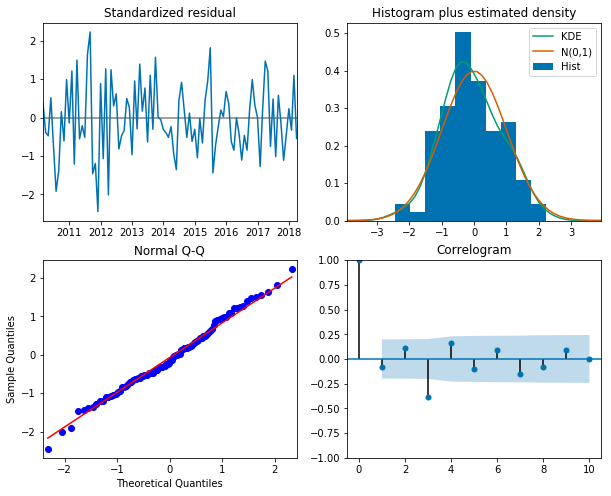

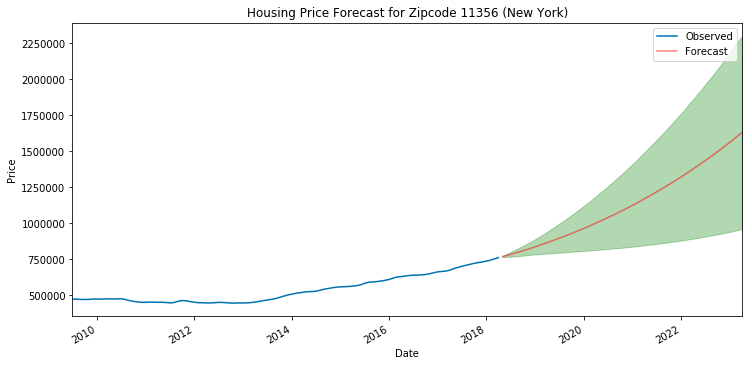

***********************************************************
Zipcode 77016, Houston
ARIMA (4, 2, 1) - MSE: 320561.8, AIC: 1511.7
ROI 1-YR: 17.17%
ROI 3-YR: 51.51%
ROI 5-YR: 85.86%


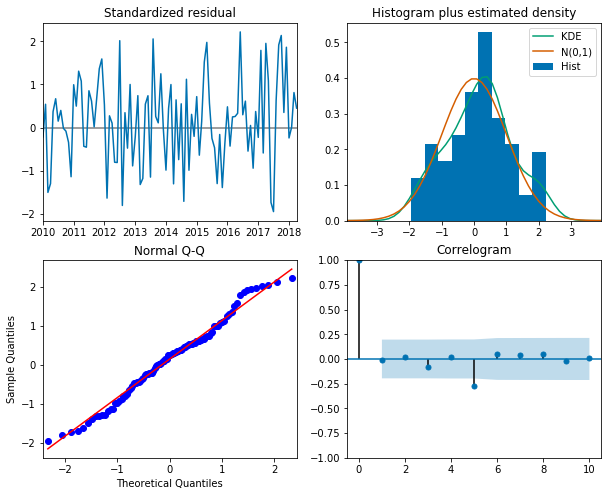

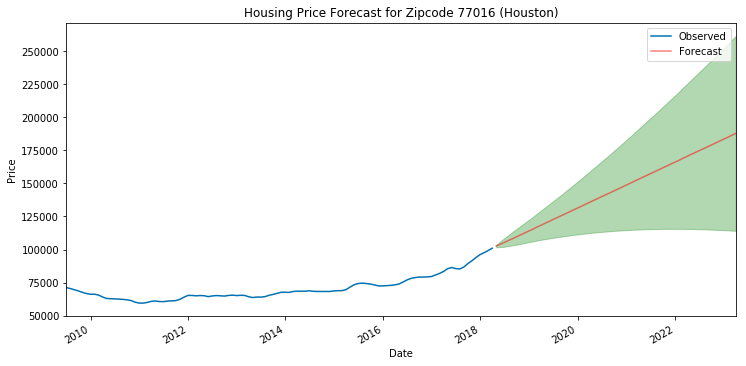

***********************************************************
Zipcode 10303, New York
ARIMA (8, 2, 1) - MSE: 680256.9, AIC: 1577.8
ROI 1-YR: 15.71%
ROI 3-YR: 47.34%
ROI 5-YR: 78.97%


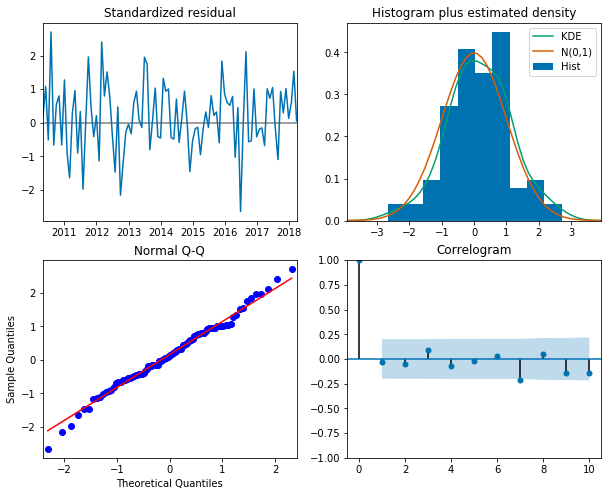

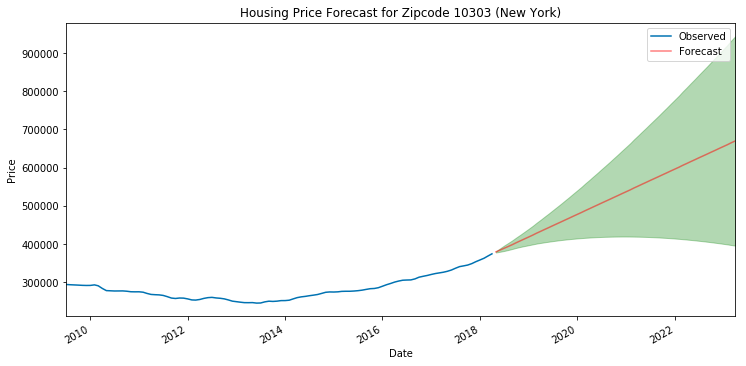

***********************************************************
Zipcode 77021, Houston
ARIMA (4, 2, 1) - MSE: 299443.1, AIC: 1535.3
ROI 1-YR: 15.1%
ROI 3-YR: 45.93%
ROI 5-YR: 76.78%


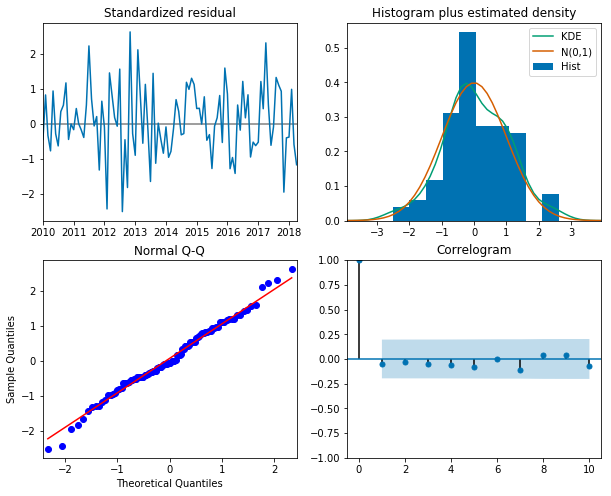

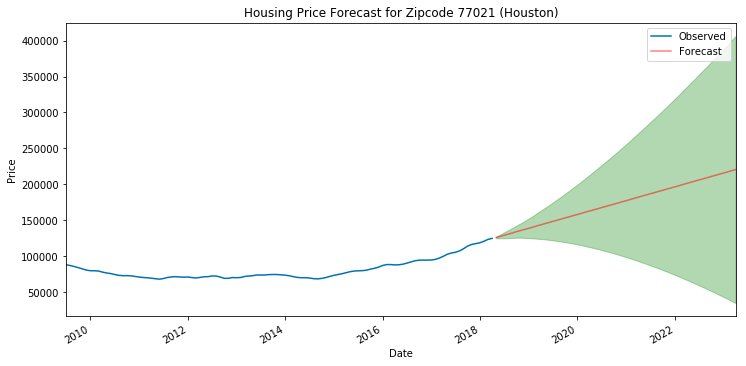

***********************************************************
Zipcode 10463, New York
ARIMA (4, 2, 1) - MSE: 5740805.6, AIC: 1939.1
ROI 1-YR: 14.1%
ROI 3-YR: 43.09%
ROI 5-YR: 72.07%


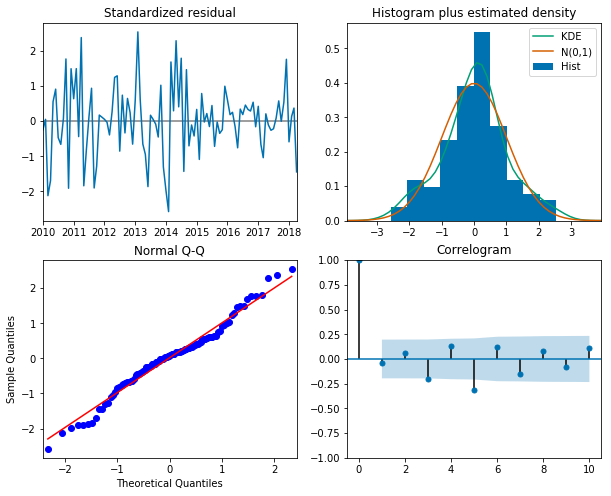

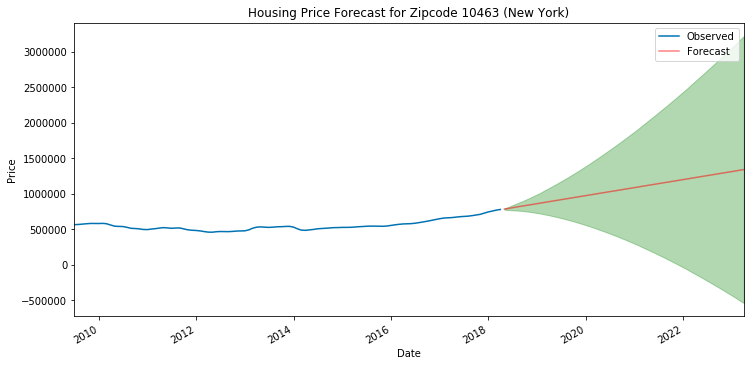

In [50]:
data = ROI_5_top5
futures= {}

for i in range(len(data)):
    zipcode = data['RegionID'].iloc[i]
    X = subset_data(zipcode, date_since='2009-07-01')
    arima_order = data['Parameters'].iloc[i]

#         output = evaluate_arima(X, arima_order)[-1]
    model = sm.tsa.statespace.SARIMAX(X,
                                  order=arima_order,
                                  freq = 'MS',
                                  enforce_stationarity = False,
                                  enforce_invertibility= False)
    output = model.fit(disp=0)
    print('***********************************************************')
    print('Zipcode {}, {}'.format(data['RegionName'].iloc[i], data['City'].iloc[i]))
    print('ARIMA {} - MSE: {}, AIC: {}'.format(arima_order, 
                                               np.round(data['MSE'].iloc[i], 1), 
                                               np.round(data['AIC'].iloc[i], 1)))
    print('ROI 1-YR: {}%'.format(np.round(data['ROI_1'].iloc[i] * 100
                                          ,2)))
    print('ROI 3-YR: {}%'.format(np.round(data['ROI_3'].iloc[i] * 100
                                          ,2)))
    print('ROI 5-YR: {}%'.format(np.round(data['ROI_5'].iloc[i] * 100
                                          ,2)))
    output.plot_diagnostics(figsize=(10,8))
    
    # plot forecast
    future = output.get_forecast(steps=60)
    futures[zipcode] = future
    future_conf = future.conf_int()
    plt.figure(figsize=(12,6))
    
    plt.plot(X,label='Observed')
    future.predicted_mean.plot(label='Forecast', color='r', alpha=0.5)

    plt.fill_between(x = future_conf.index, 
                     y1=future_conf.iloc[:,0], 
                     y2=future_conf.iloc[:,1], 
                     color='g', alpha=0.3)

    # Set axes labels
    plt.title('Housing Price Forecast for Zipcode {} ({})'.format(data['RegionName'].iloc[i], 
                                                                  data['City'].iloc[i]))
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

### 5b. Subset Zipcodes with Smallest MSE

In [52]:
# Subset 10 zipcodes in with smallest MSE.
ny_10 = output_merged.loc[output_merged['City'] == 'New York'].sort_values(by='MSE', axis=0)[:10]
la_10 = output_merged.loc[output_merged['City'] == 'Los Angeles'].sort_values(by='MSE', axis=0)[:10]
houston_10 = output_merged.loc[output_merged['City'] == 'Houston'].sort_values(by='MSE', axis=0)[:10]
ny_10_pred = get_predictions(ny_10)
la_10_pred = get_predictions(la_10)
houston_10_pred = get_predictions(houston_10)

# Combine results
top3_10 = pd.concat([ny_10, la_10, houston_10], axis=0)
top3_10_pred = pd.concat([ny_10_pred, la_10_pred, houston_10_pred], axis=0)
top3_10_pred = pd.merge(left = top3_10_pred,
                        right = top3_10[['RegionID', 'RegionName', 'City', 'MSE', 'AIC']],
                        how = 'left',
                        on = 'RegionID')
top3_10_pred.describe()

RegionID     2018-04-01     2019-04-01    2021-04-01    2023-04-01  \
count     30.000000      30.000000      30.000000  3.000000e+01  3.000000e+01   
mean   83273.766667  382256.666667  408245.424367  4.659594e+05  5.303358e+05   
std    15423.562477  211347.404287  227551.839886  2.659704e+05  3.124293e+05   
min    61779.000000  101900.000000  110109.124952  1.209360e+05  1.224267e+05   
25%    62095.750000  137400.000000  147033.117063  1.685279e+05  1.873719e+05   
50%    91705.500000  395700.000000  419401.926300  4.894298e+05  5.970896e+05   
75%    95999.000000  527750.000000  579209.682516  6.852005e+05  7.895282e+05   
max    96450.000000  815900.000000  879142.121316  1.021105e+06  1.185387e+06   

           ROI_1      ROI_3      ROI_5    RegionName           MSE  \
count  30.000000  30.000000  30.000000     30.000000  3.000000e+01   
mean    0.063759   0.204397   0.360022  59510.900000  6.475041e+05   
std     0.037529   0.123792   0.222872  35321.171681  6.420227e+05   
min    -0.005808  -0.016237  -0.026666  10303.000000  7.026047e+04   
25%     0.049603   0.145518   0.255671  11393.250000  1.513789e+05   
50%     0.065361   0.206818   0.363397  77056.500000  4.710691e+05   
75%     0.091143   0.310836   0.530265  90018.000000  7.506005e+05   
max     0.157139   0.473384   0.789662  91605.000000  2.124329e+06   

               AIC  
count    30.000000  
mean   1559.976600  
std     128.351889  
min    1320.488714  
25%    1479.291081  
50%    1560.437226  
75%    1636.974944  
max    1804.420207

In [53]:
ROI_1_top5 = top3_10_pred.sort_values(by='ROI_1',ascending=False)[:5]
ROI_3_top5 = top3_10_pred.sort_values(by='ROI_3',ascending=False)[:5]
ROI_5_top5 = top3_10_pred.sort_values(by='ROI_5',ascending=False)[:5]
print('Top 5 ROI 1 year :', set(ROI_1_top5['RegionID']))
print('Top 5 ROI 3 years:', set(ROI_3_top5['RegionID']))
print('Top 5 ROI 5 years:', set(ROI_5_top5['RegionID']))
print()
print('Top ROI Zipocdes for top3_10_pred:', set(ROI_1_top5['RegionID']).union(
                                            set(ROI_3_top5['RegionID'])).union(
                                            set(ROI_5_top5['RegionID'])))

Top 5 ROI 1 year : {95984, 61779, 61780, 61781, 62107}
Top 5 ROI 3 years: {96040, 95983, 95984, 61779, 96028}
Top 5 ROI 5 years: {96040, 95983, 95984, 61779, 96028}

Top ROI Zipocdes for top3_10_pred: {96040, 95983, 95984, 61779, 61780, 61781, 62107, 96028}


In [54]:
ROI_1_top5

RegionID  Parameters  2018-04-01     2019-04-01     2021-04-01  \
1      61779   (8, 2, 1)    374500.0  433348.504751  551782.288828   
0      62107   (6, 2, 2)    547100.0  603898.667650  721225.839070   
2      61781   (8, 2, 1)    521600.0  575544.423122  687878.192127   
11     95984  (10, 0, 2)    358400.0  394717.862818  484432.928402   
3      61780   (6, 2, 0)    529800.0  582934.272592  695416.049464   

       2023-04-01     ROI_1     ROI_3     ROI_5  RegionName         City  \
1   670228.420411  0.157139  0.473384  0.789662       10303     New York   
0   838284.973901  0.103818  0.318271  0.532234       11421     New York   
2   800012.629558  0.103421  0.318785  0.533767       10305     New York   
11  594275.955779  0.101333  0.351654  0.658136       90003  Los Angeles   
3   807604.898596  0.100291  0.312601  0.524358       10304     New York   

              MSE          AIC  
1   680256.935249  1577.816748  
0   620897.330424  1615.425843  
2   774048.396687  1552.312694  
11  293488.150313  1486.646477  
3   802381.122958  1589.398641

In [55]:
ROI_5_top5

RegionID  Parameters  2018-04-01     2019-04-01     2021-04-01  \
1      61779   (8, 2, 1)    374500.0  433348.504751  551782.288828   
11     95984  (10, 0, 2)    358400.0  394717.862818  484432.928402   
12     95983   (8, 0, 0)    362300.0  396444.628901  487589.159325   
10     96040   (6, 0, 0)    367200.0  401269.909959  491270.519277   
15     96028   (8, 0, 1)    479600.0  526325.936786  639354.190103   

       2023-04-01     ROI_1     ROI_3     ROI_5  RegionName         City  \
1   670228.420411  0.157139  0.473384  0.789662       10303     New York   
11  594275.955779  0.101333  0.351654  0.658136       90003  Los Angeles   
12  599903.224685  0.094244  0.345816  0.655819       90002  Los Angeles   
10  601570.205452  0.092783  0.337883  0.638263       90059  Los Angeles   
15  777175.222255  0.097427  0.333099  0.620465       90047  Los Angeles   

              MSE          AIC  
1   680256.935249  1577.816748  
11  293488.150313  1486.646477  
12  396982.136453  1509.434964  
10  240454.874664  1513.360833  
15  502843.928360  1578.260687

I decided to go with biggest 1Y ROIs because the uncertainty increases further in time. The predictions in 1-year time horizon would be more accurate, compared to those in 3-5 years.

***********************************************************
Zipcode 10303, New York
ARIMA (8, 2, 1) - MSE: 680256.9, AIC: 1577.8
ROI 1-YR: 15.71%
ROI 3-YR: 47.34%
ROI 5-YR: 78.97%


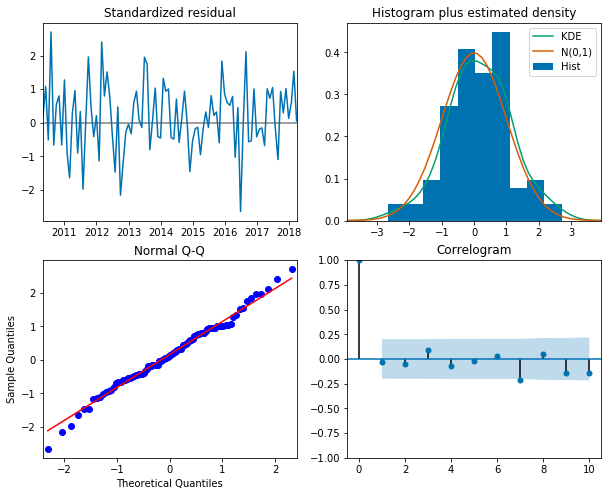

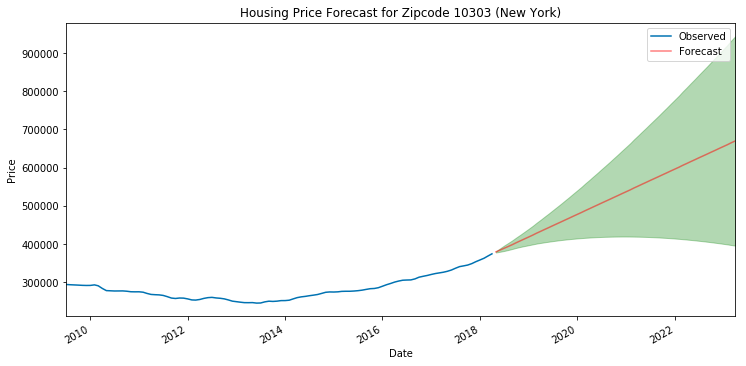

***********************************************************
Zipcode 11421, New York
ARIMA (6, 2, 2) - MSE: 620897.3, AIC: 1615.4
ROI 1-YR: 10.38%
ROI 3-YR: 31.83%
ROI 5-YR: 53.22%


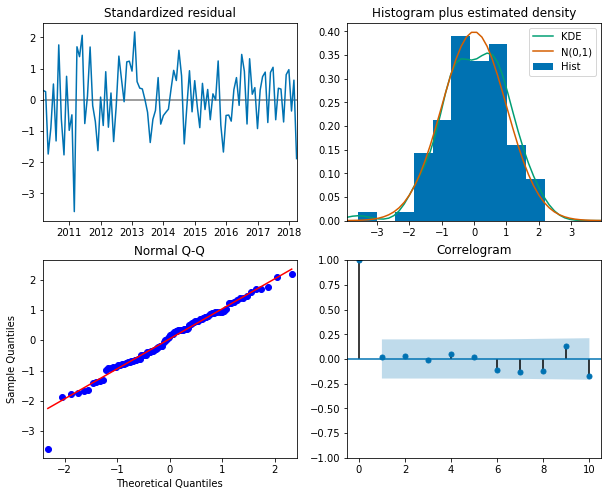

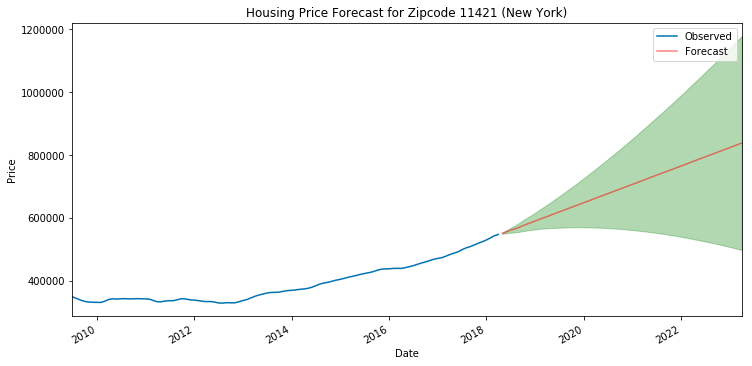

***********************************************************
Zipcode 10305, New York
ARIMA (8, 2, 1) - MSE: 774048.4, AIC: 1552.3
ROI 1-YR: 10.34%
ROI 3-YR: 31.88%
ROI 5-YR: 53.38%


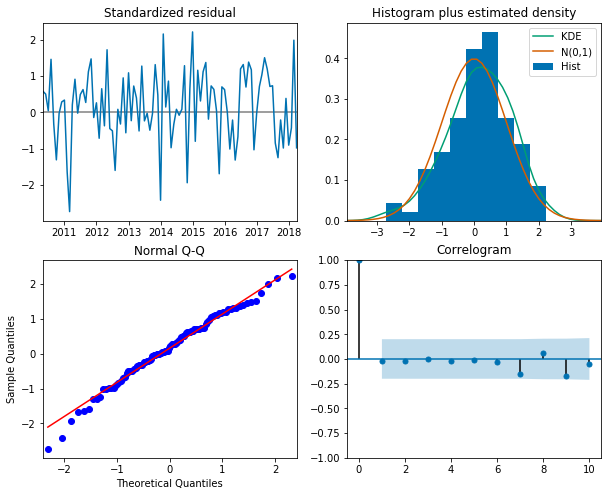

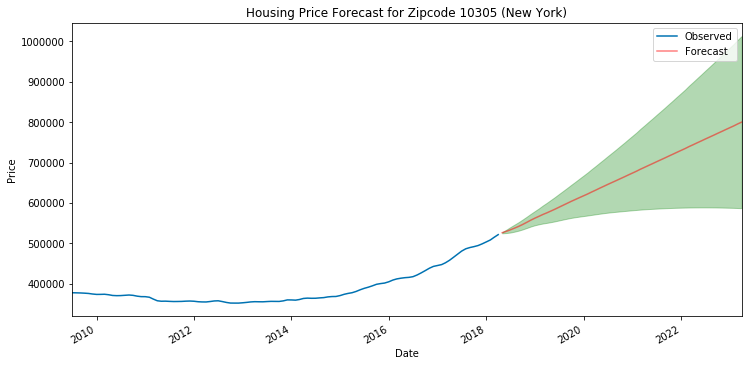

***********************************************************
Zipcode 90003, Los Angeles
ARIMA (10, 0, 2) - MSE: 293488.2, AIC: 1486.6
ROI 1-YR: 10.13%
ROI 3-YR: 35.17%
ROI 5-YR: 65.81%


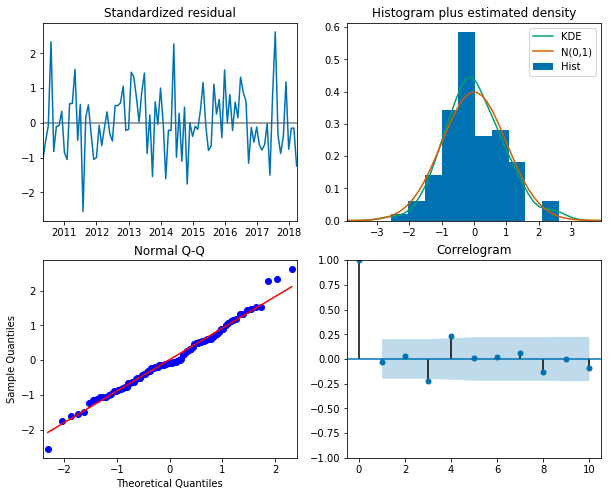

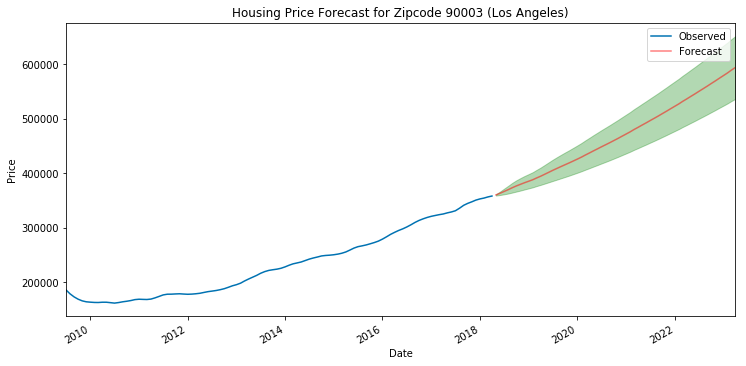

***********************************************************
Zipcode 10304, New York
ARIMA (6, 2, 0) - MSE: 802381.1, AIC: 1589.4
ROI 1-YR: 10.03%
ROI 3-YR: 31.26%
ROI 5-YR: 52.44%


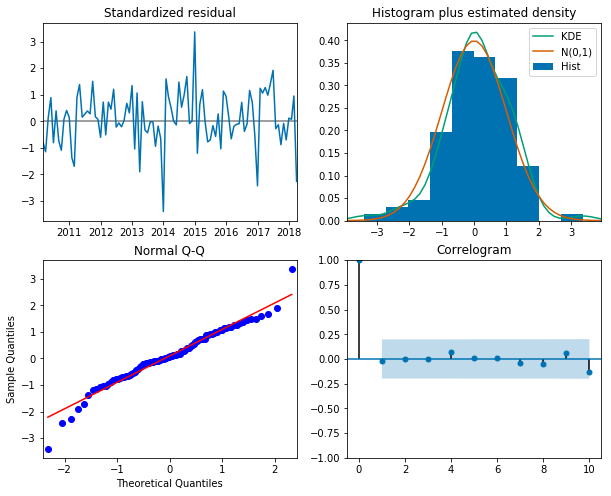

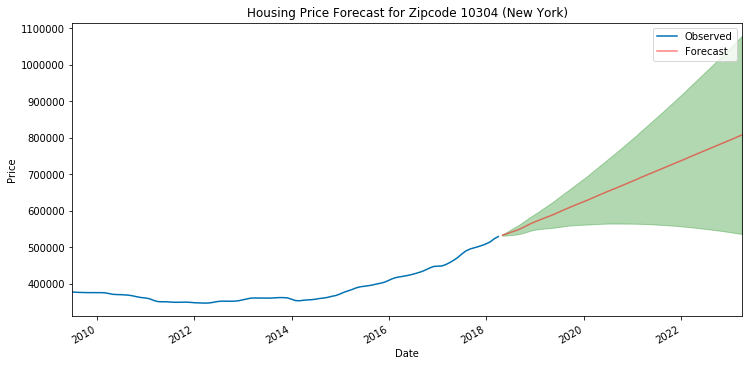

In [56]:
data = ROI_1_top5 
futures= {}

for i in range(len(data)):
    zipcode = data['RegionID'].iloc[i]
    X = subset_data(zipcode, date_since='2009-07-01')
    arima_order = data['Parameters'].iloc[i]

#         output = evaluate_arima(X, arima_order)[-1]
    model = sm.tsa.statespace.SARIMAX(X,
                                  order=arima_order,
                                  freq = 'MS',
                                  enforce_stationarity = False,
                                  enforce_invertibility= False)
    output = model.fit(disp=0)
    print('***********************************************************')
    print('Zipcode {}, {}'.format(data['RegionName'].iloc[i], data['City'].iloc[i]))
    print('ARIMA {} - MSE: {}, AIC: {}'.format(arima_order, 
                                               np.round(data['MSE'].iloc[i], 1), 
                                               np.round(data['AIC'].iloc[i], 1)))
    print('ROI 1-YR: {}%'.format(np.round(data['ROI_1'].iloc[i] * 100
                                          ,2)))
    print('ROI 3-YR: {}%'.format(np.round(data['ROI_3'].iloc[i] * 100
                                          ,2)))
    print('ROI 5-YR: {}%'.format(np.round(data['ROI_5'].iloc[i] * 100
                                          ,2)))
    output.plot_diagnostics(figsize=(10,8))
    
    # plot forecast
    future = output.get_forecast(steps=60)
    futures[zipcode] = future
    future_conf = future.conf_int()
    plt.figure(figsize=(12,6))
    
    plt.plot(X,label='Observed')
    future.predicted_mean.plot(label='Forecast', color='r', alpha=0.5)

    plt.fill_between(x = future_conf.index, 
                     y1=future_conf.iloc[:,0], 
                     y2=future_conf.iloc[:,1], 
                     color='g', alpha=0.3)

    # Set axes labels
    plt.title('Housing Price Forecast for Zipcode {} ({})'.format(data['RegionName'].iloc[i], 
                                                                  data['City'].iloc[i]))
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [57]:
results = ROI_1_top5[['RegionName', 'City', 
                      '2018-04-01', '2019-04-01', '2021-04-01', '2023-04-01',
                      'ROI_1','ROI_3','ROI_5']]
results.columns = ['Zipcode', 'City', '2018', '2019', '2021', '2023', '1Y ROI', '3Y ROI', '5Y ROI']
results['1Y ROI'] = np.round(results['1Y ROI']*100,2).astype(str)+"%"
results['3Y ROI'] = np.round(results['3Y ROI']*100,2).astype(str)+"%"
results['5Y ROI'] = np.round(results['5Y ROI']*100,2).astype(str)+"%"
results

Zipcode         City      2018           2019           2021  \
1     10303     New York  374500.0  433348.504751  551782.288828   
0     11421     New York  547100.0  603898.667650  721225.839070   
2     10305     New York  521600.0  575544.423122  687878.192127   
11    90003  Los Angeles  358400.0  394717.862818  484432.928402   
3     10304     New York  529800.0  582934.272592  695416.049464   

             2023  1Y ROI  3Y ROI  5Y ROI  
1   670228.420411  15.71%  47.34%  78.97%  
0   838284.973901  10.38%  31.83%  53.22%  
2   800012.629558  10.34%  31.88%  53.38%  
11  594275.955779  10.13%  35.17%  65.81%  
3   807604.898596  10.03%  31.26%  52.44%

In [250]:
#top3_10_pred.to_csv('top3_30zip_ROI.csv')

#### 5b-Misc. Subset 20 zipcodes with smallest MSE

When we subset to 20 zipcodes with smallest MSE, we get same set of 5 zipcodes for all 1Y, 3Y and 5Y ROI. However, the confidence intervals of the predictions, especially for 10463 (New York), I will be more restrictive to the models with smaller MSE.

In [112]:
# Subset 20 zipcodes in each city with smallest MSE.
ny_20 = output_merged.loc[output_merged['City'] == 'New York'].sort_values(by='MSE', axis=0)[:20]
la_20 = output_merged.loc[output_merged['City'] == 'Los Angeles'].sort_values(by='MSE', axis=0)[:20]
houston_20 = output_merged.loc[output_merged['City'] == 'Houston'].sort_values(by='MSE', axis=0)[:20]

ny_20_pred = get_predictions(ny_20)
la_20_pred = get_predictions(la_20)
houston_20_pred = get_predictions(houston_20)

# Combine results
top3_20 = pd.concat([ny_20, la_20, houston_20], axis=0)
top3_20_pred = pd.concat([ny_20_pred, la_20_pred, houston_20_pred], axis=0)
top3_20_pred = pd.merge(left = top3_20_pred,
                        right = top3_20[['RegionID', 'RegionName', 'City', 'MSE', 'AIC']],
                        how = 'left',
                        on = 'RegionID')
top3_20_pred.describe()

RegionID     2018-04-01    2019-04-01    2021-04-01    2023-04-01  \
count     60.000000      60.000000  6.000000e+01  6.000000e+01  6.000000e+01   
mean   83275.800000  419921.666667  4.504197e+05  5.191714e+05  5.969698e+05   
std    15272.206396  240912.978938  2.609536e+05  3.107051e+05  3.747762e+05   
min    61779.000000   99400.000000  1.054960e+05  1.179676e+05  1.224267e+05   
25%    62101.250000  141000.000000  1.500324e+05  1.798476e+05  2.111093e+05   
50%    91714.500000  424750.000000  4.469253e+05  5.147908e+05  6.007367e+05   
75%    96006.250000  600625.000000  6.462501e+05  7.127824e+05  8.136356e+05   
max    96451.000000  941200.000000  1.017415e+06  1.170348e+06  1.629326e+06   

           ROI_1      ROI_3      ROI_5    RegionName           MSE  \
count  60.000000  60.000000  60.000000     60.000000  6.000000e+01   
mean    0.070888   0.226616   0.400121  59520.600000  1.128845e+06   
std     0.039029   0.131760   0.245286  34943.301306  1.324657e+06   
min    -0.014670  -0.022096  -0.026666  10303.000000  7.026047e+04   
25%     0.051050   0.147963   0.249835  11409.750000  2.577438e+05   
50%     0.070129   0.237147   0.406810  77065.500000  6.358042e+05   
75%     0.093065   0.318399   0.544220  90025.250000  1.581198e+06   
max     0.171693   0.536697   1.139347  91606.000000  6.629337e+06   

               AIC  
count    60.000000  
mean   1586.249486  
std     177.747282  
min     736.357086  
25%    1496.354445  
50%    1575.480196  
75%    1724.042461  
max    1939.149704

In [113]:
ROI_1_top5 = top3_20_pred.sort_values(by='ROI_1',ascending=False)[:5]
ROI_3_top5 = top3_20_pred.sort_values(by='ROI_3',ascending=False)[:5]
ROI_5_top5 = top3_20_pred.sort_values(by='ROI_5',ascending=False)[:5]
print('Top 5 ROI 1 year :', set(ROI_1_top5['RegionID']))
print('Top 5 ROI 3 years:', set(ROI_3_top5['RegionID']))
print('Top 5 ROI 5 years:', set(ROI_5_top5['RegionID']))
print()
print('Top ROI Zipocdes for top3_20_pred:', set(ROI_1_top5['RegionID']).union(
                                            set(ROI_3_top5['RegionID'])).union(
                                            set(ROI_5_top5['RegionID'])))

Top 5 ROI 1 year : {61803, 91665, 61779, 62068, 91670}
Top 5 ROI 3 years: {61803, 91665, 61779, 62068, 91670}
Top 5 ROI 5 years: {61803, 91665, 61779, 62068, 91670}

Top ROI Zipocdes for top3_20_pred: {61803, 91665, 61779, 62068, 91670}


***********************************************************
Zipcode 77016, Houston
ARIMA (4, 2, 1) - MSE: 320561.8, AIC: 1511.7
ROI 1-YR: 17.17%
ROI 3-YR: 51.51%
ROI 5-YR: 85.86%


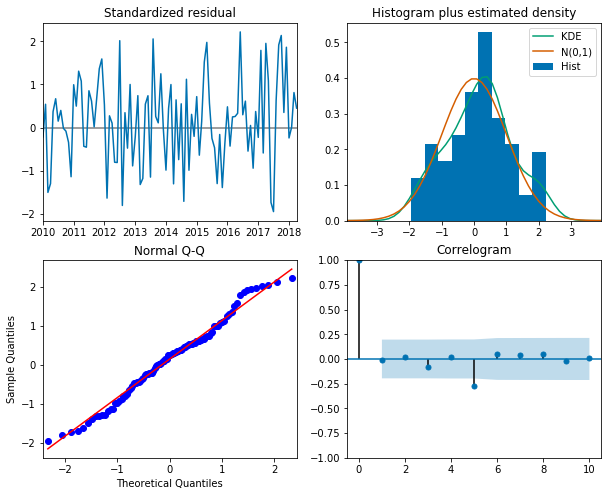

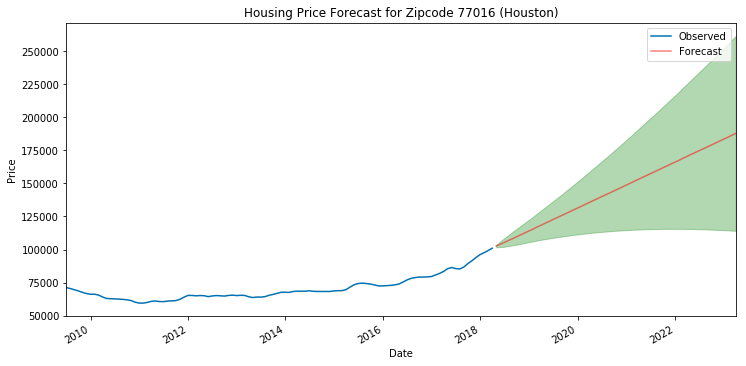

***********************************************************
Zipcode 10303, New York
ARIMA (8, 2, 1) - MSE: 680256.9, AIC: 1577.8
ROI 1-YR: 15.71%
ROI 3-YR: 47.34%
ROI 5-YR: 78.97%


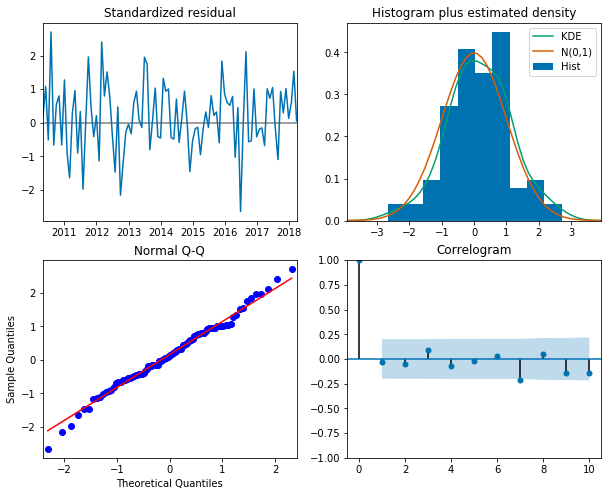

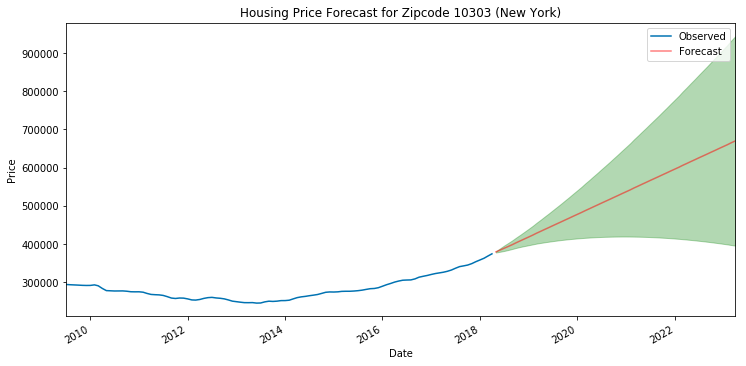

***********************************************************
Zipcode 77021, Houston
ARIMA (4, 2, 1) - MSE: 299443.1, AIC: 1535.3
ROI 1-YR: 15.1%
ROI 3-YR: 45.93%
ROI 5-YR: 76.78%


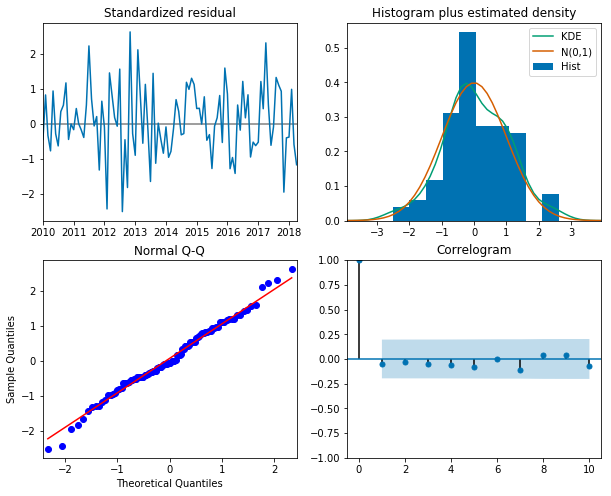

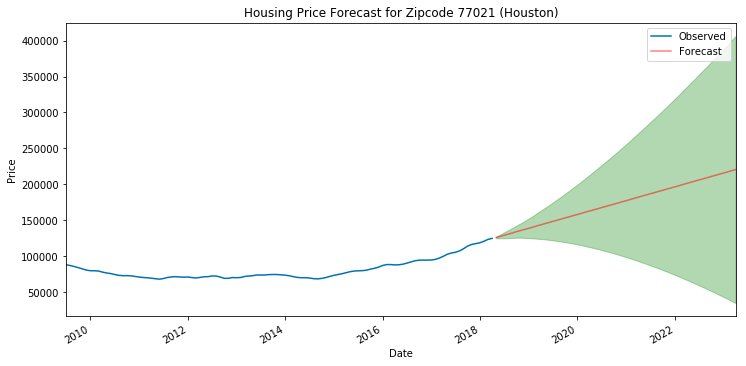

***********************************************************
Zipcode 10463, New York
ARIMA (4, 2, 1) - MSE: 5740805.6, AIC: 1939.1
ROI 1-YR: 14.1%
ROI 3-YR: 43.09%
ROI 5-YR: 72.07%


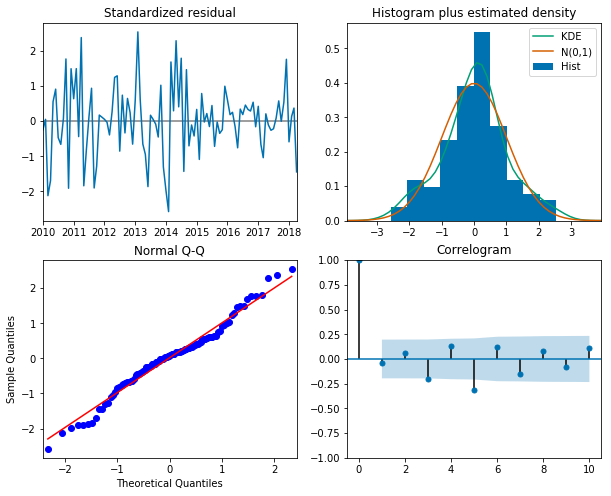

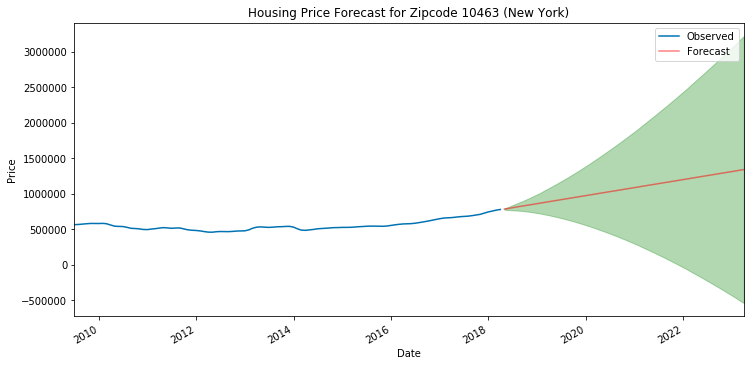

***********************************************************
Zipcode 11356, New York
ARIMA (8, 0, 1) - MSE: 2702927.5, AIC: 1755.1
ROI 1-YR: 13.64%
ROI 3-YR: 53.67%
ROI 5-YR: 113.93%


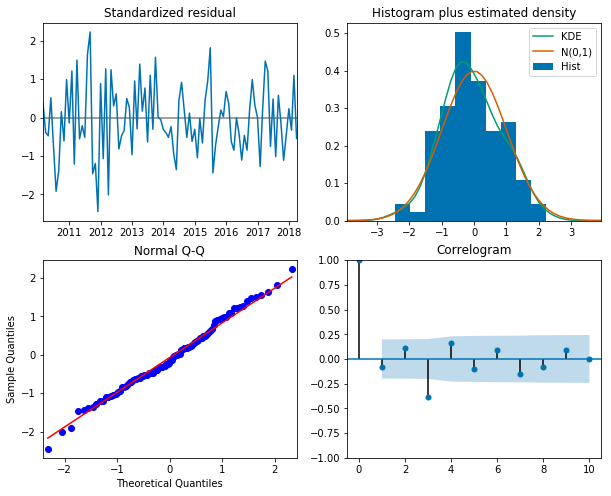

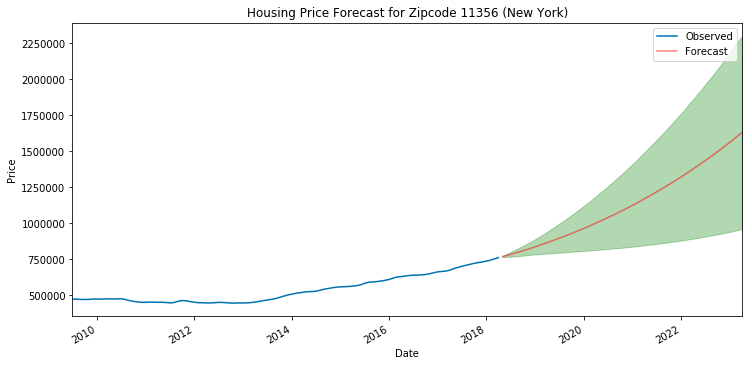

In [114]:
data = ROI_1_top5
futures_20 = {}

for i in range(len(data)):
    zipcode = data['RegionID'].iloc[i]
    X = subset_data(zipcode, date_since='2009-07-01')
    arima_order = data['Parameters'].iloc[i]

#         output = evaluate_arima(X, arima_order)[-1]
    model = sm.tsa.statespace.SARIMAX(X,
                                  order=arima_order,
                                  freq = 'MS',
                                  enforce_stationarity = False,
                                  enforce_invertibility= False)
    output = model.fit(disp=0)
    print('***********************************************************')
    print('Zipcode {}, {}'.format(data['RegionName'].iloc[i], data['City'].iloc[i]))
    print('ARIMA {} - MSE: {}, AIC: {}'.format(arima_order, 
                                               np.round(data['MSE'].iloc[i], 1), 
                                               np.round(data['AIC'].iloc[i], 1)))
    print('ROI 1-YR: {}%'.format(np.round(data['ROI_1'].iloc[i] * 100
                                          ,2)))
    print('ROI 3-YR: {}%'.format(np.round(data['ROI_3'].iloc[i] * 100
                                          ,2)))
    print('ROI 5-YR: {}%'.format(np.round(data['ROI_5'].iloc[i] * 100
                                          ,2)))
    output.plot_diagnostics(figsize=(10,8))
    
    # plot forecast
    future = output.get_forecast(steps=60)
    futures_20[zipcode] = future
    future_conf = future.conf_int()
    plt.figure(figsize=(12,6))
    
    plt.plot(X,label='Observed')
    future.predicted_mean.plot(label='Forecast', color='r', alpha=0.5)

    plt.fill_between(x = future_conf.index, 
                     y1=future_conf.iloc[:,0], 
                     y2=future_conf.iloc[:,1], 
                     color='g', alpha=0.3)

    # Set axes labels
    plt.title('Housing Price Forecast for Zipcode {} ({})'.format(data['RegionName'].iloc[i], 
                                                                  data['City'].iloc[i]))
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [87]:
# top3_20_pred.to_csv('top3_60zip_ROI.csv')

### 5c. Identify Zipcodes with Highest Projected Growth

In [58]:
futures

{61779: <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper at 0x1c1ebecf60>,
 62107: <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper at 0x1c21654cc0>,
 61781: <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper at 0x1c2044d0b8>,
 95984: <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper at 0x1c21a7d898>,
 61780: <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper at 0x1c212e5550>}

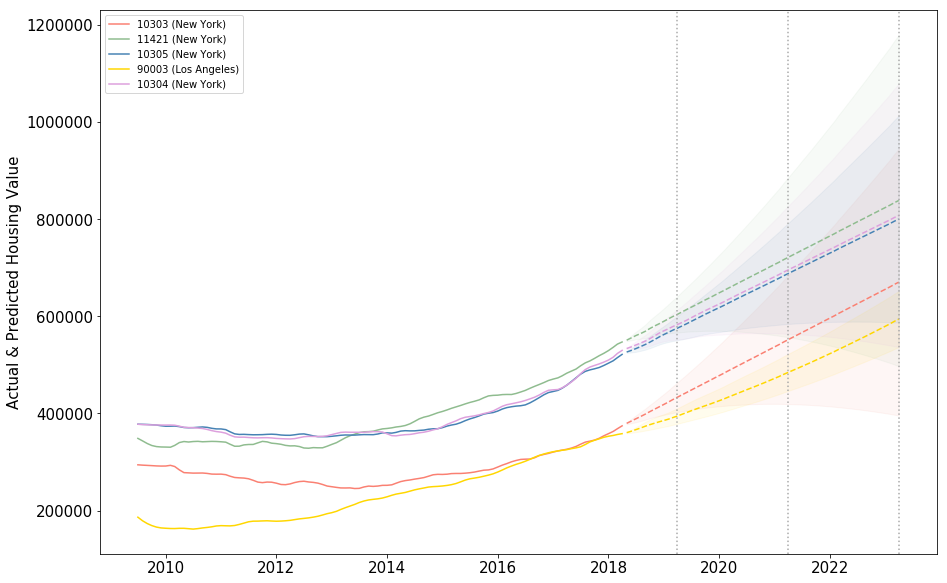

In [59]:
# plot prediction of the 5 zipcodes chosen
plt.figure(figsize=(15,10))
colors = ['salmon', 'darkseagreen', 'steelblue', 'gold', 'plum']

for indx, i in enumerate(futures):
    name = '{} ({})'.format(data.loc[data['RegionID'] == i]['RegionName'].item(),
                            data.loc[data['RegionID'] == i]['City'].item())
    
    plt.plot(subset_data(i, date_since='2009-07-01'), 
             label=name,
             color = colors[indx])
    plt.plot(futures[i].predicted_mean, 
             linestyle='--',
             color = colors[indx])
    
    conf = futures[i].conf_int()
    plt.fill_between(x = conf.index, 
                     y1=conf.iloc[:,0], 
                     y2=conf.iloc[:,1], 
                     color=colors[indx], alpha=0.07)


plt.axvline(x='2019-04-01', c='darkgrey', linestyle='dotted')
plt.axvline(x='2021-04-01', c='darkgrey', linestyle='dotted')
plt.axvline(x='2023-04-01', c='darkgrey', linestyle='dotted')

plt.xticks(size=15)
plt.yticks(size=15)

plt.ylabel('Actual & Predicted Housing Value', size=15)

plt.legend()
plt.show()

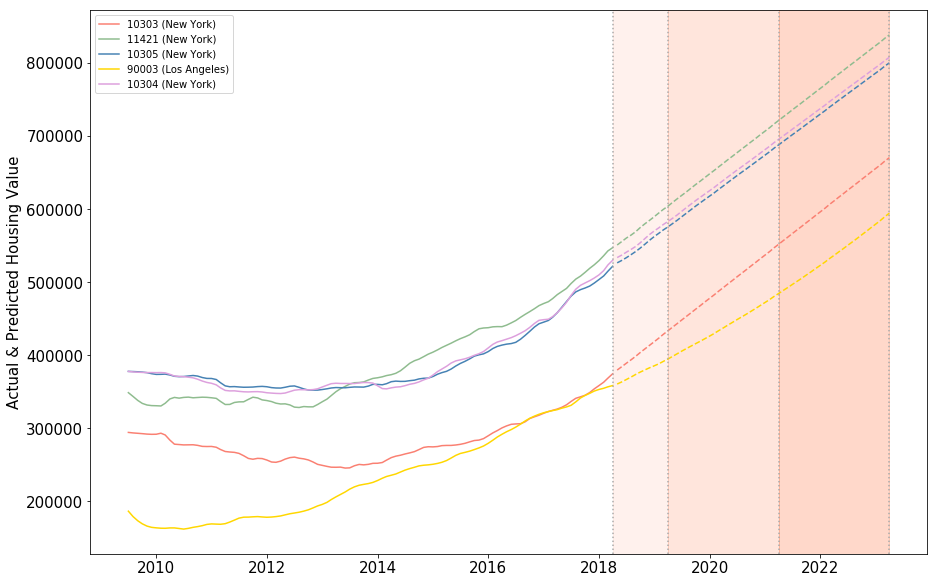

In [60]:
# plot prediction of the 5 zipcodes chosen
plt.figure(figsize=(15,10))
colors = ['salmon', 'darkseagreen', 'steelblue', 'gold', 'plum']

for indx, i in enumerate(futures):
    name = '{} ({})'.format(data.loc[data['RegionID'] == i]['RegionName'].item(),
                            data.loc[data['RegionID'] == i]['City'].item())
    
    plt.plot(subset_data(i, date_since='2009-07-01'), 
             label=name,
             color = colors[indx])
    plt.plot(futures[i].predicted_mean, 
             linestyle='--',
             color = colors[indx])

plt.axvline(x='2018-04-01', c='darkgrey', linestyle='dotted')
plt.axvline(x='2019-04-01', c='darkgrey', linestyle='dotted')
plt.axvline(x='2021-04-01', c='darkgrey', linestyle='dotted')
plt.axvline(x='2023-04-01', c='darkgrey', linestyle='dotted')

plt.axvspan('2018-04-01', '2019-04-01', ymin=0, ymax=800000, alpha=0.1, color='coral')
plt.axvspan('2019-04-01', '2021-04-01', ymin=0, ymax=800000, alpha=0.2, color='coral')
plt.axvspan('2021-04-01', '2023-04-01', ymin=0, ymax=800000, alpha=0.3, color='coral')

plt.xticks(size=15)
plt.yticks(size=15)

plt.ylabel('Actual & Predicted Housing Value', size=15)

plt.legend()
plt.show()

#### 5c-Misc. For 20 zipcodes subset with smallest MSE

In [115]:
futures_20

{91665: <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper at 0x1c2007e8d0>,
 61779: <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper at 0x1c215ab400>,
 91670: <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper at 0x1c203da1d0>,
 61803: <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper at 0x1c20098be0>,
 62068: <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper at 0x1c2061d278>}

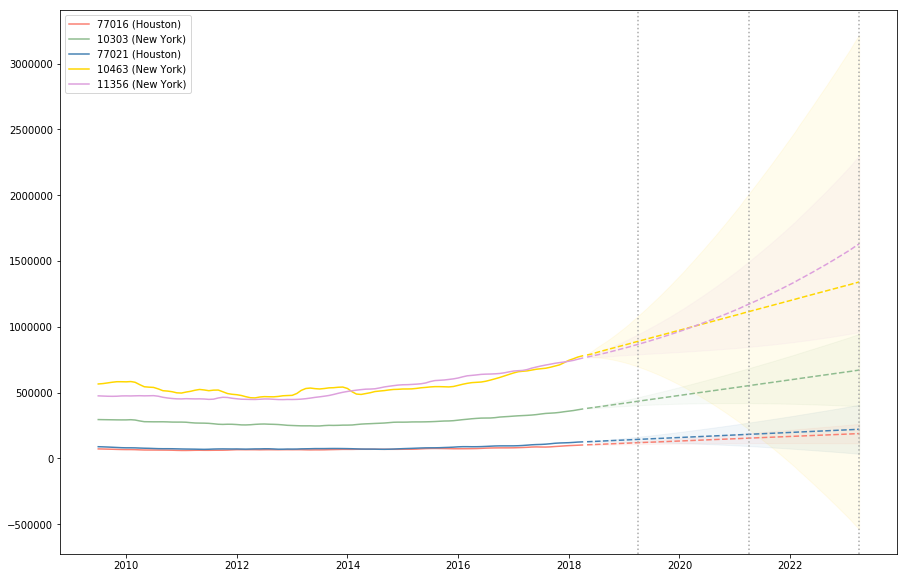

In [116]:
# plot prediction of the 5 zipcodes chosen
plt.figure(figsize=(15,10))
colors = ['salmon', 'darkseagreen', 'steelblue', 'gold', 'plum']

for indx, i in enumerate(futures_20):
    name = '{} ({})'.format(data.loc[data['RegionID'] == i]['RegionName'].item(),
                            data.loc[data['RegionID'] == i]['City'].item())
    
    plt.plot(subset_data(i, date_since='2009-07-01'), 
             label=name,
             color = colors[indx])
    plt.plot(futures_20[i].predicted_mean, 
             linestyle='--',
             color = colors[indx])
    
    conf = futures_20[i].conf_int()
    plt.fill_between(x = conf.index, 
                     y1=conf.iloc[:,0], 
                     y2=conf.iloc[:,1], 
                     color=colors[indx], alpha=0.07)


plt.axvline(x='2019-04-01', c='darkgrey', linestyle='dotted')
plt.axvline(x='2021-04-01', c='darkgrey', linestyle='dotted')
plt.axvline(x='2023-04-01', c='darkgrey', linestyle='dotted')


plt.legend()
plt.show()

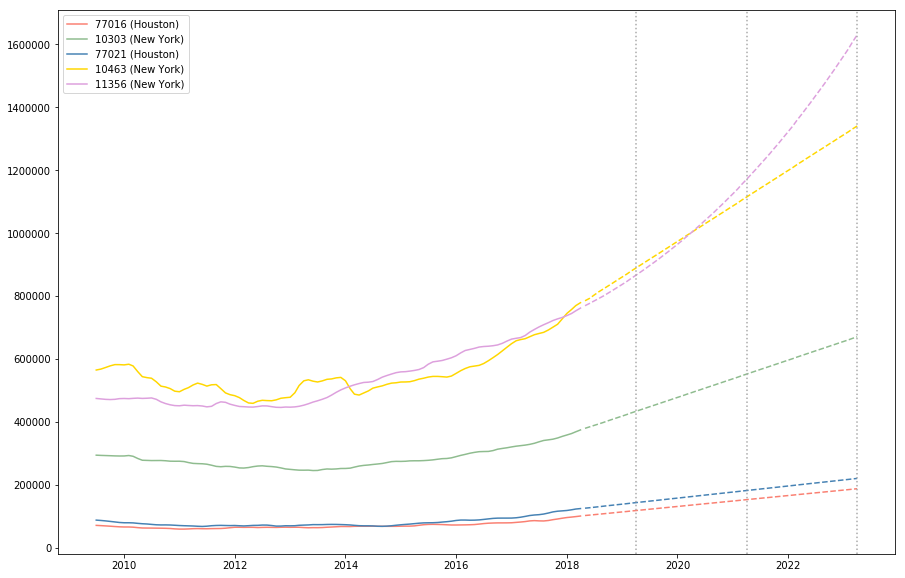

In [117]:
# plot prediction of the 5 zipcodes chosen
plt.figure(figsize=(15,10))
colors = ['salmon', 'darkseagreen', 'steelblue', 'gold', 'plum']

for indx, i in enumerate(futures_20):
    name = '{} ({})'.format(data.loc[data['RegionID'] == i]['RegionName'].item(),
                            data.loc[data['RegionID'] == i]['City'].item())
    
    plt.plot(subset_data(i, date_since='2009-07-01'), 
             label=name,
             color = colors[indx])
    plt.plot(futures_20[i].predicted_mean, 
             linestyle='--',
             color = colors[indx])

plt.axvline(x='2019-04-01', c='darkgrey', linestyle='dotted')
plt.axvline(x='2021-04-01', c='darkgrey', linestyle='dotted')
plt.axvline(x='2023-04-01', c='darkgrey', linestyle='dotted')


plt.legend()
plt.show()

### 5d. Visualize Zipcodes with Highest Projected Growth

In [61]:
list(ROI_1_top5['RegionName'].astype(str))

['10303', '11421', '10305', '90003', '10304']

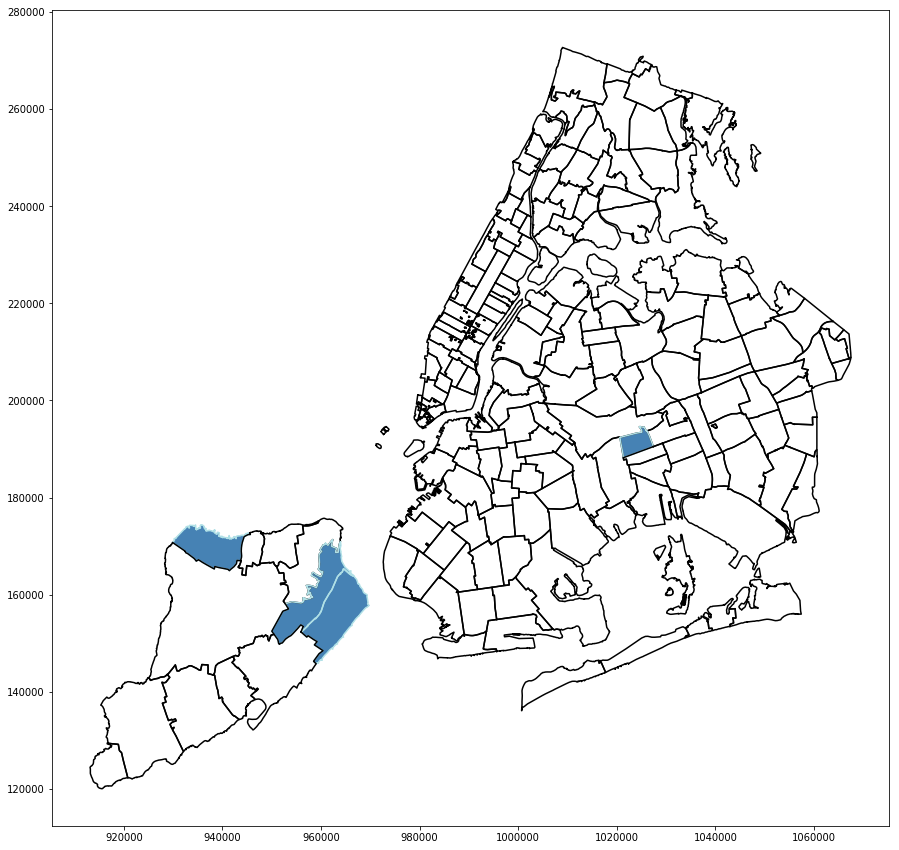

In [62]:
# Visualize the 4 NY invest targets
sf = shp.Reader("ZIP_CODE_040114.dbf")
fields = [field[0] for field in sf.fields[1:]]
invest = list(ROI_1_top5['RegionName'].astype(str))

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

for feature in sf.shapeRecords():
    geom = feature.shape.__geo_interface__
    atr = dict(zip(fields, feature.record))
    
    for i in range(len(feature.shape.parts)):
        i_start = feature.shape.parts[i]
        if i==len(feature.shape.parts)-1:
            i_end = len(feature.shape.points)
        else:
            i_end = feature.shape.parts[i+1]
            
        x = [i[0] for i in feature.shape.points[i_start:i_end]]
        y = [i[1] for i in feature.shape.points[i_start:i_end]]
        
        patches = []
        if atr['ZIPCODE'] in invest:
            ax.plot(x,y, color='powderblue')
            patches.append(Polygon(np.array(feature.shape.points[i_start:i_end]), True))
            ax.add_collection(PatchCollection(patches, facecolor= 'steelblue'))
        else:
            ax.plot(x,y, color='black')
# plt.xlim(965000 , 1025000)
# plt.ylim(180000 , 240000)
plt.show()

# Misc.

- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I**: Integrated. The use of differencing of raw observations (ex. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- **MA**: Moving average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

- **p**: The number of lag observations included in the model (lag order).
- **d**: The number of times that the raw observations  are differenced (degree of differencing).
- **q**: The size of the moving average window (order of moving average).



https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

### Facebook Prophet

In [141]:
# from fbprophet import Prophet as proph

In [142]:
# test_melted_09.reset_index(inplace=True)
# test_melted_09.columns = ['ds', 'y']
# model = proph(interval_width=0.95)
# model.fit(test_melted_13)
# future_dates = model.make_future_dataframe(periods=36, freq='MS')
# future_dates.tail()

In [144]:
# # forecast = model.predict(future_dates)
# forecast.head()

In [145]:
# forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

In [146]:
# Use prophet's plot function to plot the predictions
# model.plot(forecast, uncertainty=True)
# plt.show()

In [147]:
# Plot model components
# model.plot_components(forecast)
# plt.show()